In [1]:
#Import

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from biasmodels import MagnificationBias, GalaxyBias, EvolutionBias
from multipole_signal import Signal, Derivatives
from getdist import plots
from getdist.gaussian_mixtures import GaussianND
import fishermat as fm
import pickle as pk

#Set current directory
import os
import sys

PACKAGE_PARENT = '..'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd())))
sys.path.append(SCRIPT_DIR)
print(SCRIPT_DIR)

#Configuration
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'xtick.direction': 'out',  
          'ytick.direction': 'out',  
          'xtick.minor.visible': True,  
          'ytick.minor.visible': True,
          'xtick.major.size': 9,
          'xtick.minor.size': 4.5,
          'ytick.major.size': 9,
          'ytick.minor.size': 4.5,
          'lines.linewidth': 1.75}
plt.rcParams.update(params)

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/danielsb/Documents/GitHub


In [2]:
# Redshift bins

z_bins = np.array([0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95])

# Separations

dist = [
    np.arange(20, 164, 4),
    np.arange(32, 164, 4),
]

params_dict0 = {
    'h' : 0.6766,
    'As' : 2.05e-9,
    'ns' : 0.9665,
    'Ob' : 0.04897, # This is here the density parameter of Baryons
    'Om' : 0.3111, # This is here the density parameter of Cold Dark Matter
}

steps = [1e-3, 1e-1, 1e-4, 1e-2, 1e-2]

#myDerivatives = Derivatives(params_dict0 = params_dict0,  wide_angle = False, dist_correction = False)

# Derivatives

In [3]:
with open('derivatives.pkl', 'rb') as File:
    derivatives_dict = pk.load(File)
    
derivatives_50x50 = derivatives_dict['split_50x50']
derivatives_30x70 = derivatives_dict['split_30x70']

In [4]:
dsignal_dsbias_fit = derivatives_30x70['dsignal_dsbias']

dsignal_dgbias =  derivatives_30x70['dsignal_dgbias']

dsignal_dcosmic =  derivatives_30x70['dsignal_dcosmic']

dsignal_dnum_fit =  derivatives_30x70['dsignal_dnumev']

np.shape(dsignal_dsbias_fit), np.shape(dsignal_dgbias), np.shape(dsignal_dcosmic)

((8, 19, 324), (4, 19, 324), (5, 19, 324))

In [5]:
dsignal_dtheta_fit_all = np.concatenate([dsignal_dsbias_fit, dsignal_dnum_fit, dsignal_dgbias, dsignal_dcosmic])

np.shape(dsignal_dtheta_fit_all)

(21, 19, 324)

## Remove the DIPOLE

In [6]:
n_sep = len(dist[0])

print('Number of separations per multipole = ', n_sep)

Number of separations per multipole =  36


In [7]:
index_dipole = list(range(3*n_sep,4*n_sep))

print(index_dipole)

[108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143]


In [8]:
dsignal_dtheta_fit_ndip_ = np.concatenate([dsignal_dsbias_fit, dsignal_dnum_fit, dsignal_dgbias, dsignal_dcosmic])

dsignal_dtheta_fit_ndip = np.delete(dsignal_dtheta_fit_ndip_, index_dipole, axis=2)

np.shape(dsignal_dtheta_fit_ndip)

(21, 19, 288)

## Remove the octupole

In [9]:
n_sep = len(dist[0])

print('Number of separations per multipole = ', n_sep)

Number of separations per multipole =  36


In [10]:
dsignal_dsbias_fit_noct = dsignal_dsbias_fit[:,:,:-n_sep]

dsignal_dgbias_noct = dsignal_dgbias[:,:,:-n_sep]

dsignal_dcosmic_noct = dsignal_dcosmic[:,:,:-n_sep]

dsignal_dnum_fit_noct = dsignal_dnum_fit[:,:,:-n_sep]

np.shape(dsignal_dsbias_fit_noct), np.shape(dsignal_dgbias_noct), np.shape(dsignal_dcosmic_noct), np.shape(dsignal_dnum_fit_noct)

((8, 19, 288), (4, 19, 288), (5, 19, 288), (4, 19, 288))

In [11]:
dsignal_dtheta_fit_noct = np.concatenate([dsignal_dsbias_fit_noct, dsignal_dnum_fit_noct, dsignal_dgbias_noct, dsignal_dcosmic_noct])

np.shape(dsignal_dtheta_fit_noct)

(21, 19, 288)

# Analysis with $m = 2.0$

## NO OCTUPOLE

In [12]:
# Create the Cov Matrix for sB, sF, nevol

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

sB_4fit = np.array([0.32517608, 0.64417726, 0.16141884, 0.13330365])
sF_4fit = np.array([-0.19376095,  1.0747336,  -0.07806247, -0.00558005])
nevol_fid = np.array([7.94599875, -12.03752387,   2.29927261, -15.83887369])

num_fit = nevol_fid

dsB_19bins = sB_4fit * errB[0] 
dsF_19bins = sF_4fit * errF[0]

dnum_19bins = num_fit * errB[1]

Cov_all_19bins = np.diag(np.concatenate([dsB_19bins**2, dsF_19bins**2, dnum_19bins**2]))

Inv_Cov_all_19bins = np.linalg.inv(Cov_all_19bins)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_fit_all), len(dsignal_dtheta_fit_all)])

Inv_Cov_prior_all[:len(Inv_Cov_all_19bins), :len(Inv_Cov_all_19bins)] = Inv_Cov_all_19bins

np.shape(Cov_all_19bins)

(12, 12)

In [13]:
Cov_multipoles_19bins = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[30,70])

np.shape(Cov_multipoles_19bins), type(Cov_multipoles_19bins)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 

Population splitted in 30% BRIGHT - 70% FAINT 


 ... Success! ... 



((19, 324, 324), list)

In [14]:
Cov_multipoles_noct_19bins = [Cov_multipoles_19bins[k][:-n_sep,:-n_sep] for k,_ in enumerate(z_bins)]

np.shape(Cov_multipoles_noct_19bins)

(19, 288, 288)

In [15]:
Inv_Cov_multipoles_noct_19bins = [np.linalg.inv(Cov_multipoles_noct_19bins[k]) for k,_ in enumerate(z_bins)]

Fisher_Matrix_multipoles_noct_19bins = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_noct, inv_cov = Inv_Cov_multipoles_noct_19bins, z_bins = z_bins)
Fisher_Matrix_noct_19bins = Fisher_Matrix_multipoles_noct_19bins + Inv_Cov_prior_all

Sigma_Matrix_noct_19bins = np.linalg.inv(Fisher_Matrix_noct_19bins)

np.shape(Sigma_Matrix_noct_19bins)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

#### Constraints

In [16]:
#Absolute Errors

Abs_Errors_noct_19bins = np.sqrt(np.diag(Sigma_Matrix_noct_19bins))

# Fiducial values

sbias_fid = np.concatenate([sB_4fit, sF_4fit])
num_fid = num_fit
gbias_fid = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sbias_fid, num_fid, gbias_fid, cosmic_fid])

# Relative errors

Rel_Errors_noct_19bins = np.abs(Abs_Errors_noct_19bins/params_fid)

params_errors_noct_19bins = Rel_Errors_noct_19bins * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sbias = ', params_errors_noct_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_noct_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])
print()
print('gbias = ', params_errors_noct_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))])
print()
print('cosmic = ', params_errors_noct_19bins[(len(sbias_fid) + len(num_fid)+len(gbias_fid)):])


------------ Relative errors * 100 ------------

sbias =  [41.57521167 39.4364059  44.66445194 24.08245588 47.96981649 20.87794989
 49.53447705 49.98038228]

number =  [41.31563133 37.20731969 33.77342062 31.39472632]

gbias =  [0.51981087 0.43534727 0.15658404 0.26562449]

cosmic =  [1.07742765 0.68912812 0.87021321 1.11099198 0.4794206 ]


#### Predictions

##### Magnification bias

In [17]:
# Magnification bias fit

def magbias_fit(params, x):
    a, b, c, d = params
    return  a + b * x + c * np.log(x) + d * (np.log(x))**2

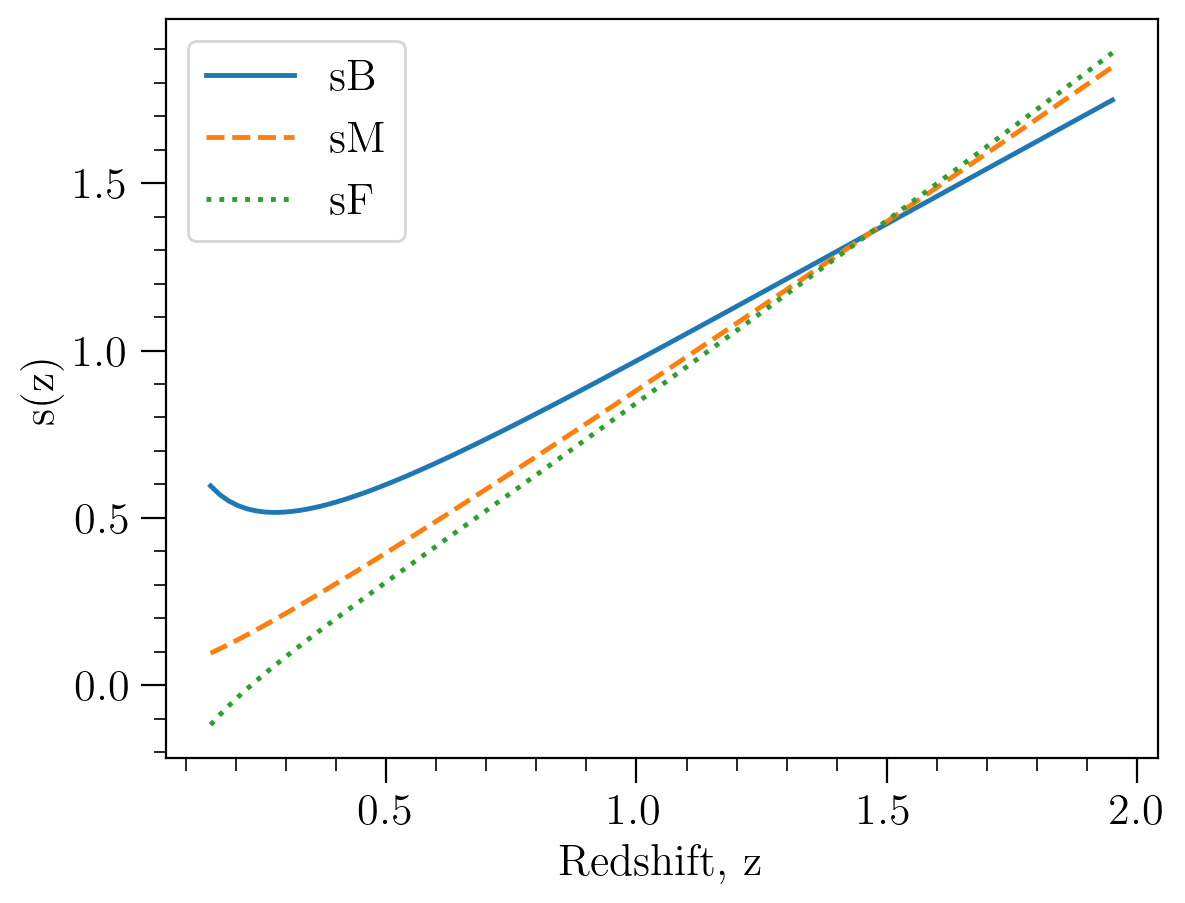

In [18]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 10/3

sB_fid = magbias_fit(sB_4fit, z_lin)
sM_fid = magbias_fit(sF_4fit, z_lin)
sF_fid = sM_fid * (m_split/(m_split-1)) - sB_fid/(m_split-1)

plt.plot(z_lin, sB_fid, '-', label=r'sB')
plt.plot(z_lin, sM_fid, '--', label=r'sM')
plt.plot(z_lin, sF_fid, ':', label=r'sF')

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();


###### Compare the two observables

In [19]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_noct = Sigma_Matrix_noct_19bins[:4, :4]
cov_sM_noct = Sigma_Matrix_noct_19bins[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sB_pars_samples_noct = np.random.multivariate_normal(sB_4fit, cov_sB_noct, num_samples)
sM_pars_samples_noct = np.random.multivariate_normal(sF_4fit, cov_sM_noct, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_noct = np.array([magbias_fit(pars, z_lin) for pars in sB_pars_samples_noct])
sM_samples_noct = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_noct])

# Calculate the 68% confidence interval
sB_lower_bound_noct = np.percentile(sB_samples_noct, 16, axis=0)
sB_upper_bound_noct = np.percentile(sB_samples_noct, 84, axis=0)
sM_lower_bound_noct = np.percentile(sM_samples_noct, 16, axis=0)
sM_upper_bound_noct = np.percentile(sM_samples_noct, 84, axis=0)

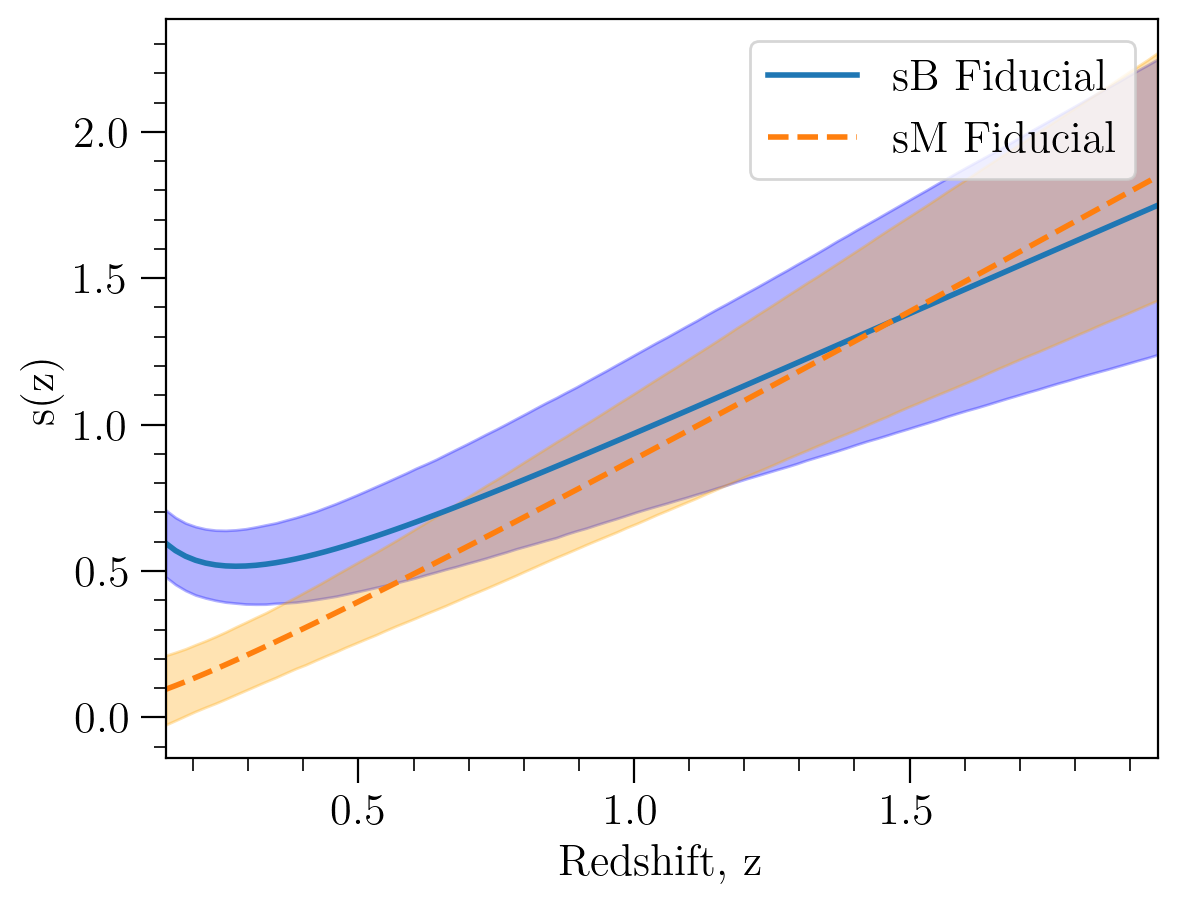

In [20]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0)
plt.plot(z_lin, sM_fid, '--', label=r'sM Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='blue', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='orange', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();

###### Compare with priors

In [21]:
# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_priors = Cov_all_19bins[:4, :4]
cov_sM_priors = Cov_all_19bins[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sB_pars_samples_priors = np.random.multivariate_normal(sB_4fit, cov_sB_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sF_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_pars_samples_priors])
sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval
sB_lower_bound_priors = np.percentile(sB_samples_priors, 16, axis=0)
sB_upper_bound_priors = np.percentile(sB_samples_priors, 84, axis=0)
sM_lower_bound_priors = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors = np.percentile(sM_samples_priors, 84, axis=0)

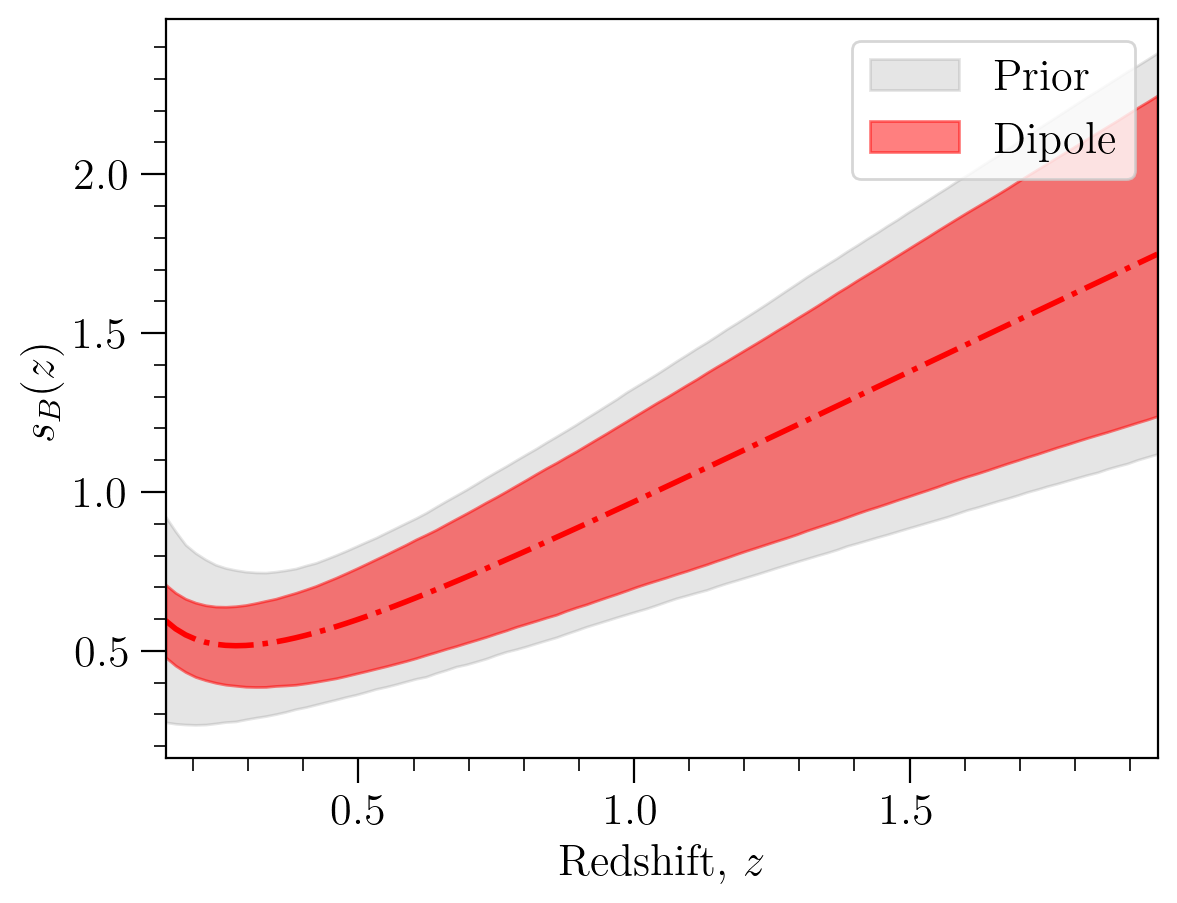

In [22]:
plt.plot(z_lin, sB_fid, '-.', lw = 2.0, color='red')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='black', alpha=0.1, label= 'Prior')
plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='red', alpha=0.5, label = 'Dipole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_B(z)$');
plt.title(r'')
plt.legend();

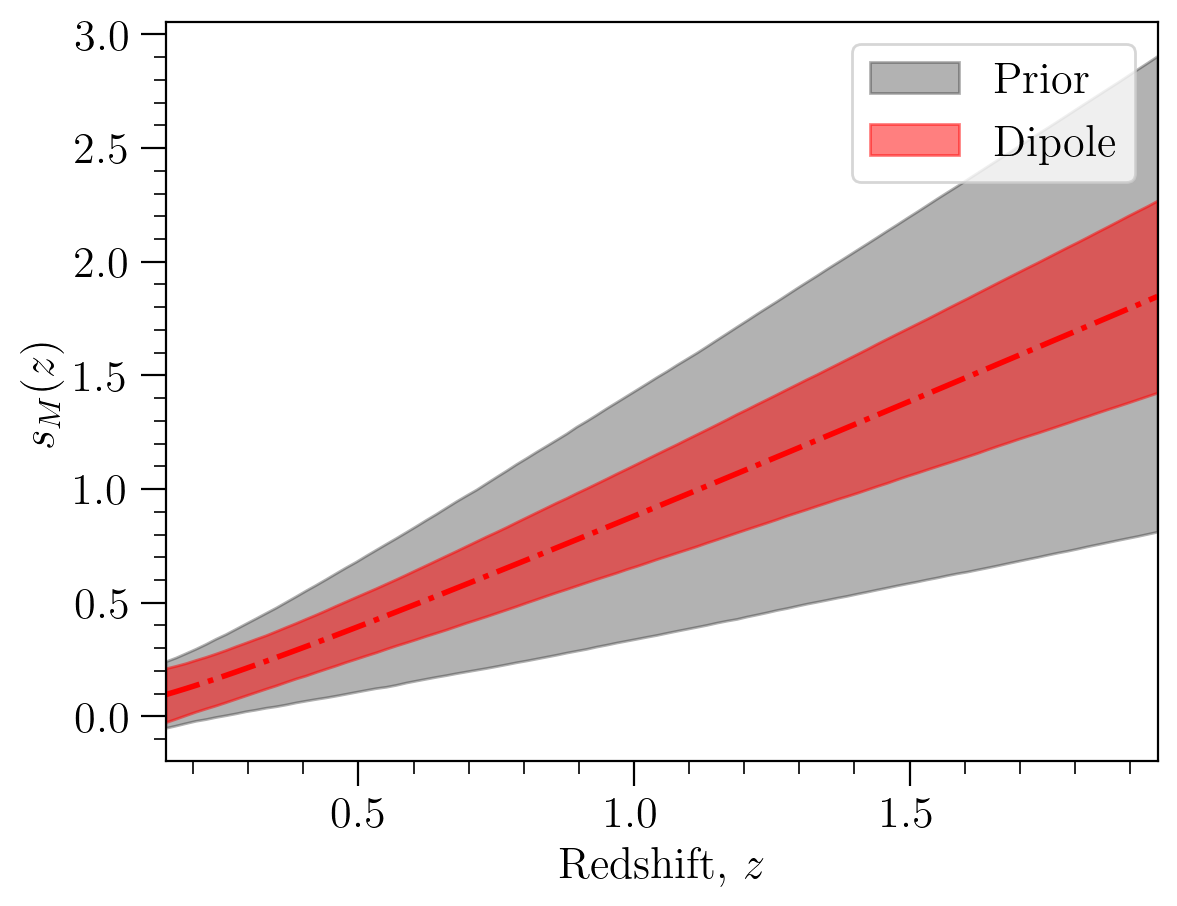

In [23]:
plt.plot(z_lin, sM_fid, '-.', lw = 2.0, color='red')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label='Prior')
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='red', alpha=0.5, label='Dipole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.title(r'');
plt.legend();

###### Magnification bias of the Faint

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_m$ parameters.

In [24]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_noct = Sigma_Matrix_noct_19bins[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sbias_pars_samples_noct = np.random.multivariate_normal(sbias_fid, cov_sbias_noct, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_noct = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_noct])
sM_samples_noct = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_noct])

# Compute the sF for each sample
sF_samples_noct = sM_samples_noct*m_split/(m_split-1) - sB_samples_noct/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_noct = np.percentile(sF_samples_noct, 16, axis=0)
sF_upper_bound_noct = np.percentile(sF_samples_noct, 84, axis=0)

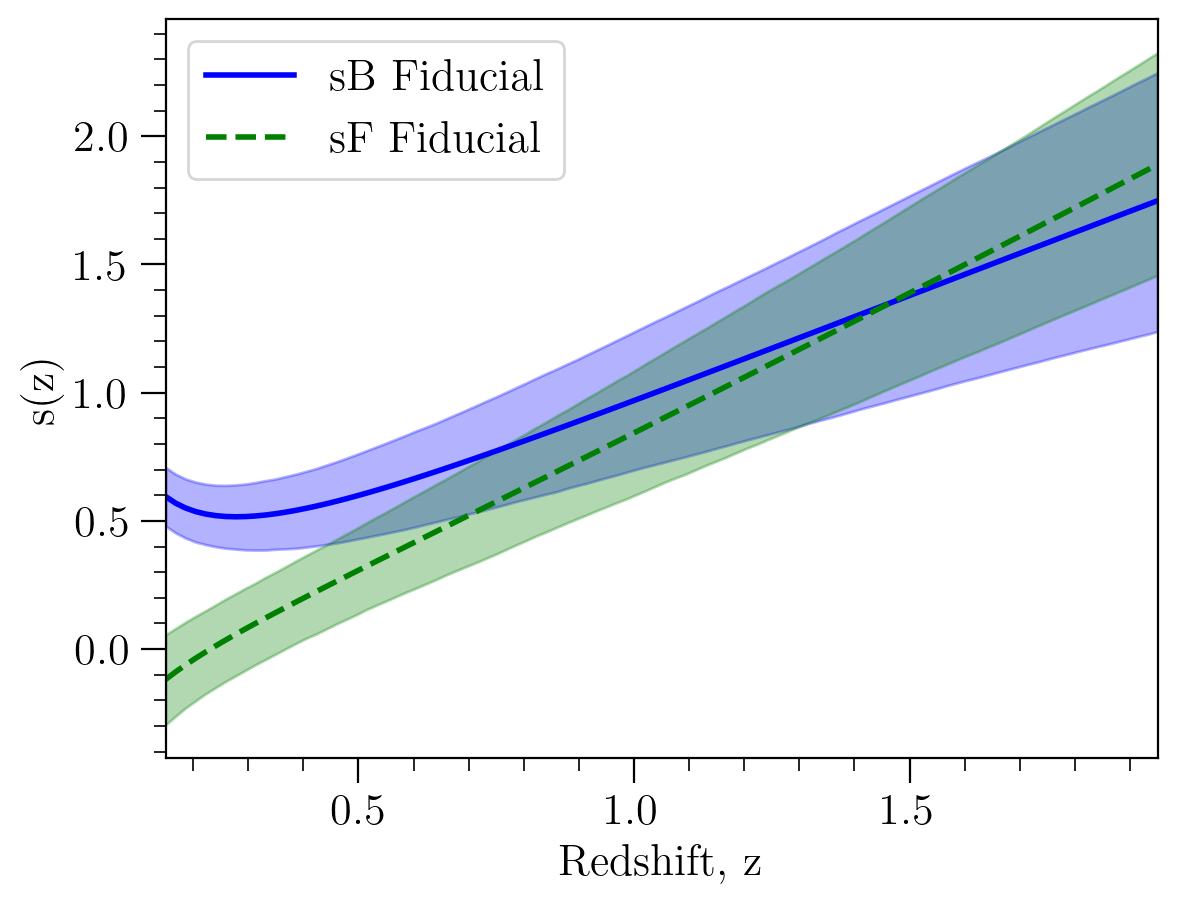

In [25]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0, color='blue')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 2.0, color='green')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='blue', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='green', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();

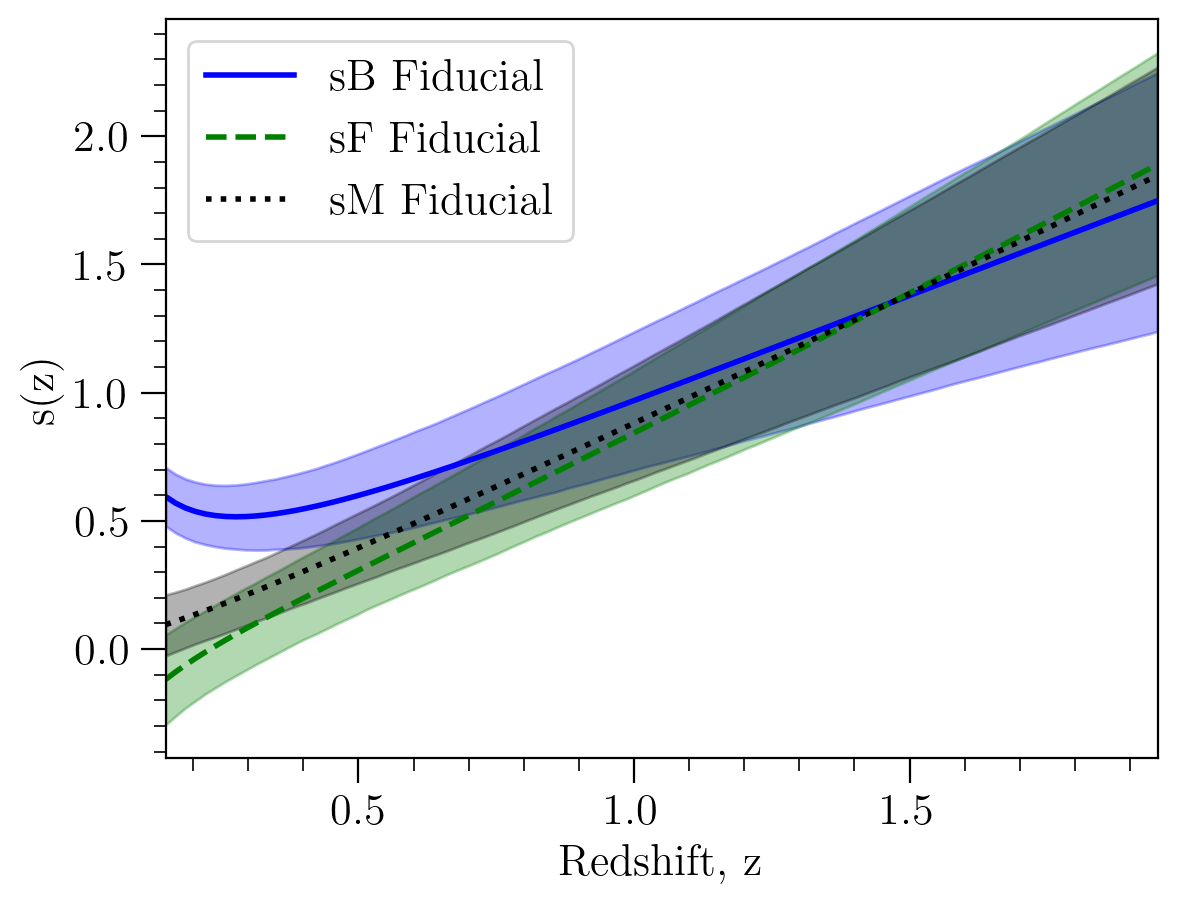

In [26]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0, color='blue')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 2.0, color='green')
plt.plot(z_lin, sM_fid, ':', label=r'sM Fiducial', lw = 2.0, color='black')


# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='blue', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='green', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='black', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();

Compare with priors

In [27]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_priors = Cov_all_19bins[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sbias_pars_samples_priors = np.random.multivariate_normal(sbias_fid, cov_sbias_priors, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_priors = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_priors])
sM_samples_priors = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_priors])

# Compute the sF for each sample
sF_samples_priors = sM_samples_priors*m_split/(m_split-1) - sB_samples_priors/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_priors = np.percentile(sF_samples_priors, 16, axis=0)
sF_upper_bound_priors = np.percentile(sF_samples_priors, 84, axis=0)

Text(0.5, 1.0, 'Prediction vs Prior')

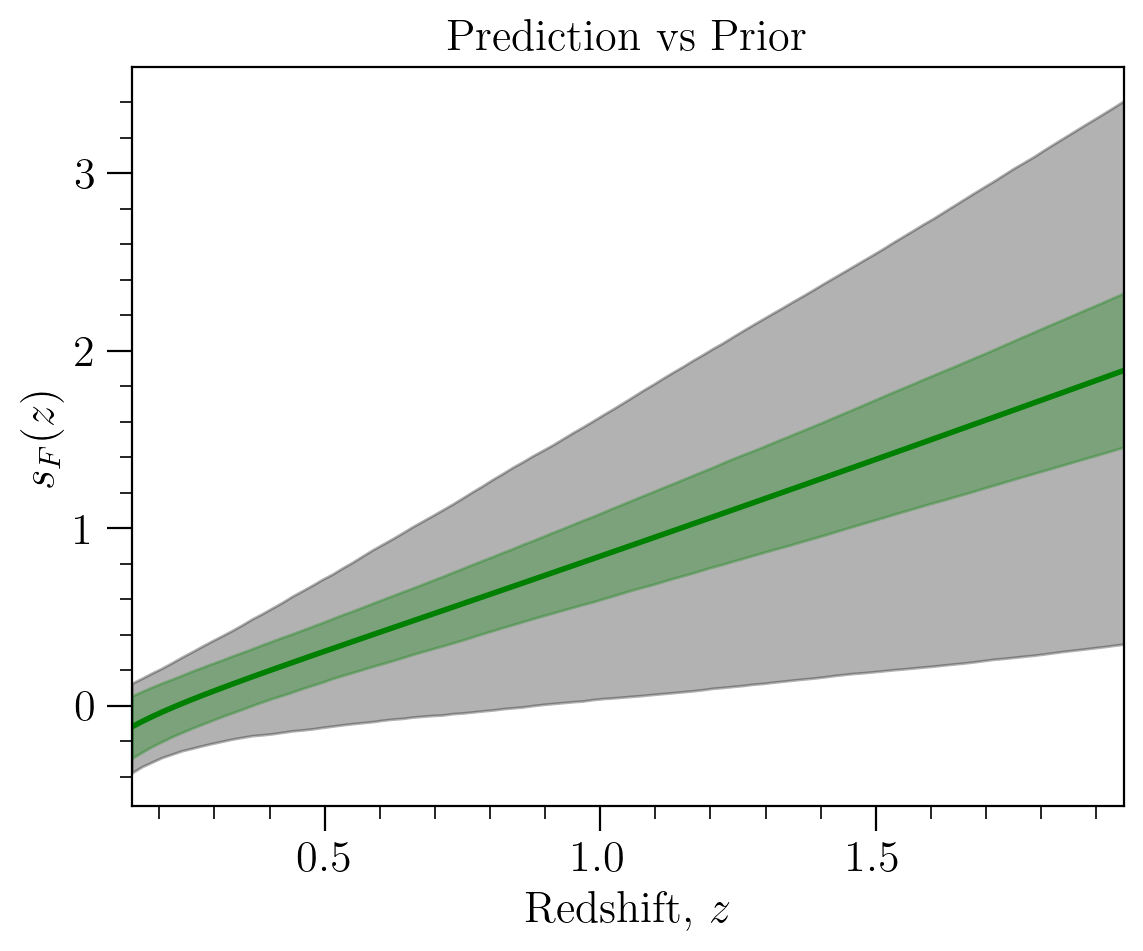

In [28]:
plt.plot(z_lin, sF_fid, '-', lw = 2.0, color='green')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='green', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_F(z)$');
plt.title(r'Prediction vs Prior')

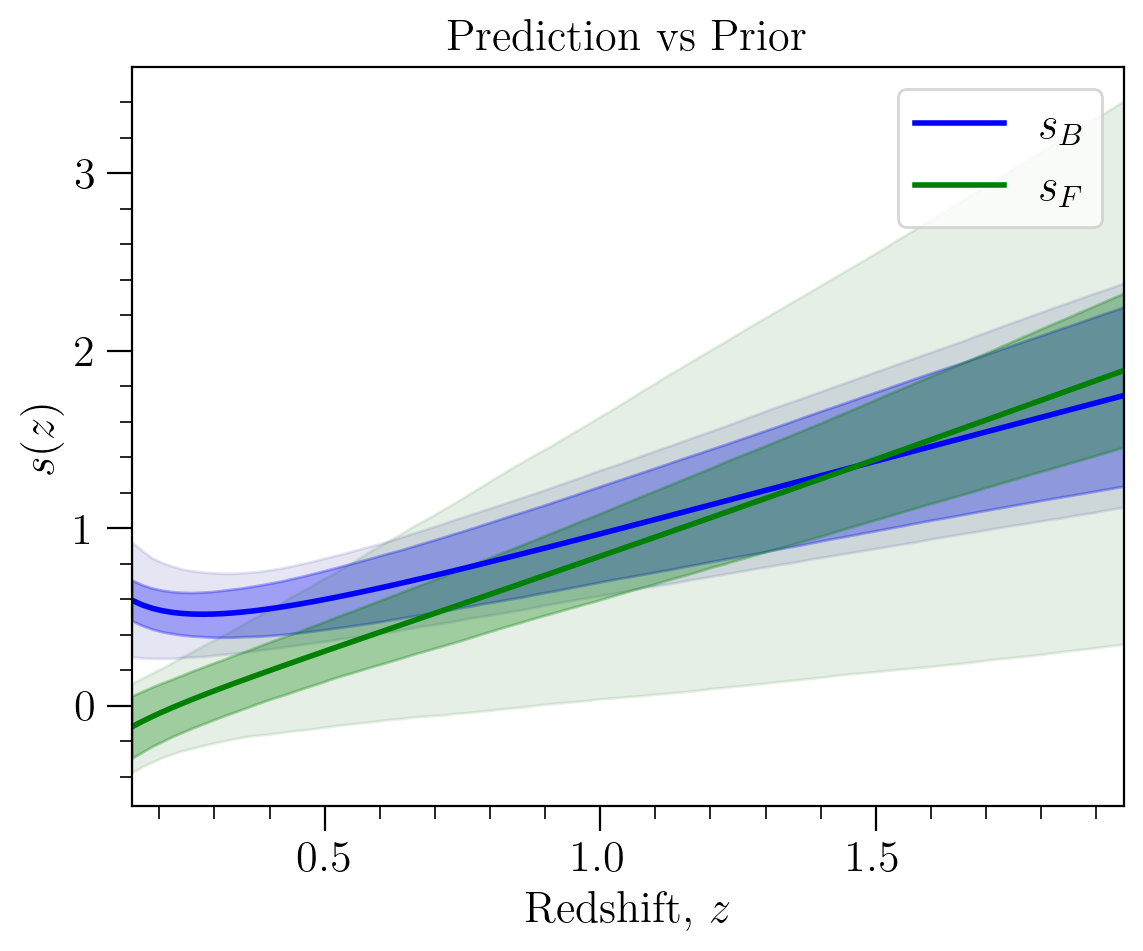

In [29]:
plt.plot(z_lin, sB_fid, '-', lw = 2.0, color='blue', label=r'$s_B$')
plt.plot(z_lin, sF_fid, '-', lw = 2.0, color='green', label=r'$s_F$')


# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='darkblue', alpha=0.1)
plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='blue', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='darkgreen', alpha=0.1)
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='green', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s(z)$');
plt.title(r'Prediction vs Prior');
plt.legend();

##### Number evolution

In [30]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

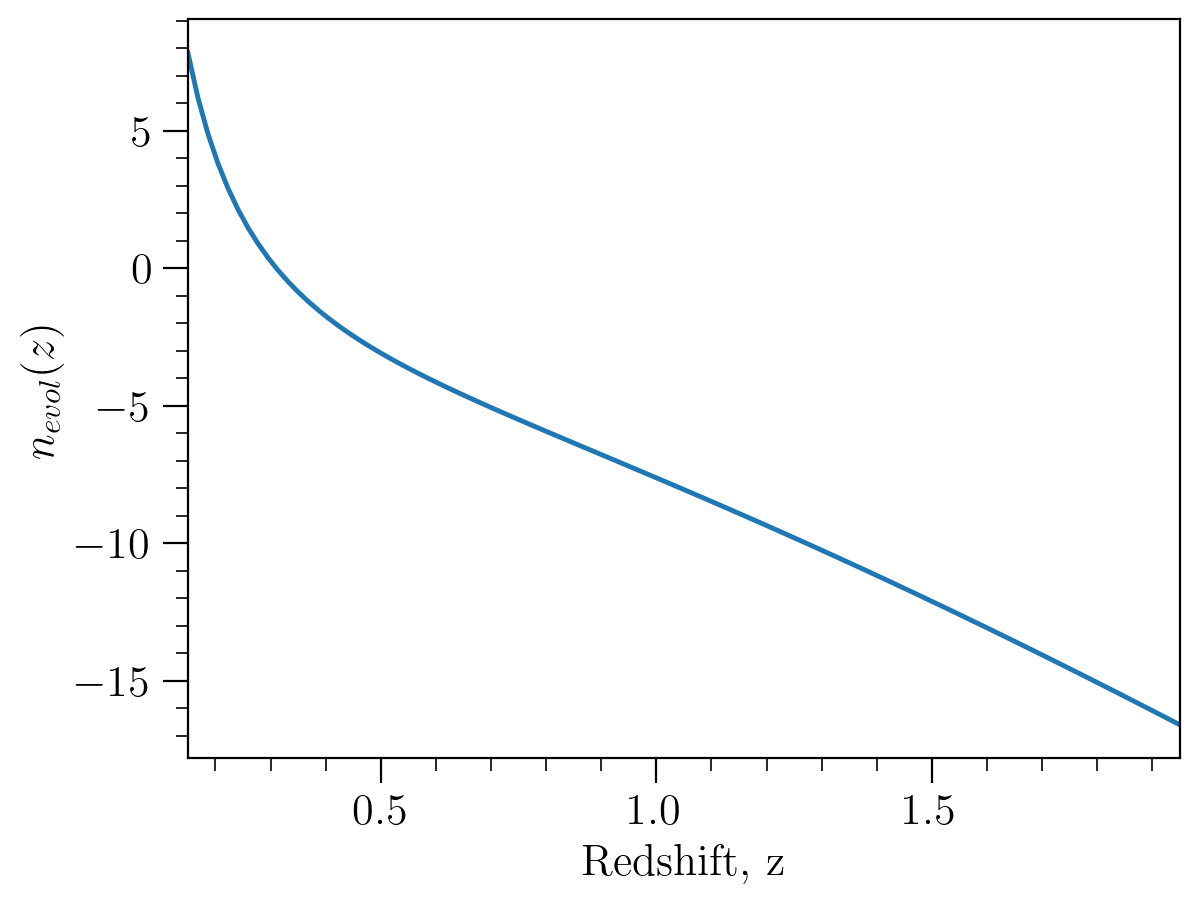

In [31]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 10/3

num_evol_fid = nevol_fit(nevol_fid, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');

In [32]:
# Select the marginalized covariance matrix for the number evolution
cov_numevol_noct = Sigma_Matrix_noct_19bins[8:12, 8:12]
cov_numevol_priors = Cov_all_19bins[8:12, 8:12]


# Generate parameter samples from multivariate normal distribution
num_samples = 5000
nevol_pars_samples_noct = np.random.multivariate_normal(nevol_fid, cov_numevol_noct, num_samples)
nevol_samples_priors = np.random.multivariate_normal(nevol_fid, cov_numevol_priors, num_samples)

# Evaluate fitting function for each parameter sample
nevol_samples_noct = np.array([nevol_fit(pars, z_lin) for pars in nevol_pars_samples_noct])
nevol_samples_priors = np.array([nevol_fit(pars, z_lin) for pars in nevol_samples_priors])

# Calculate the 68% confidence interval
nevol_lower_bound_noct = np.percentile(nevol_samples_noct, 16, axis=0)
nevol_upper_bound_noct = np.percentile(nevol_samples_noct, 84, axis=0)
nevol_lower_bound_priors = np.percentile(nevol_samples_priors, 16, axis=0)
nevol_upper_bound_priors = np.percentile(nevol_samples_priors, 84, axis=0)

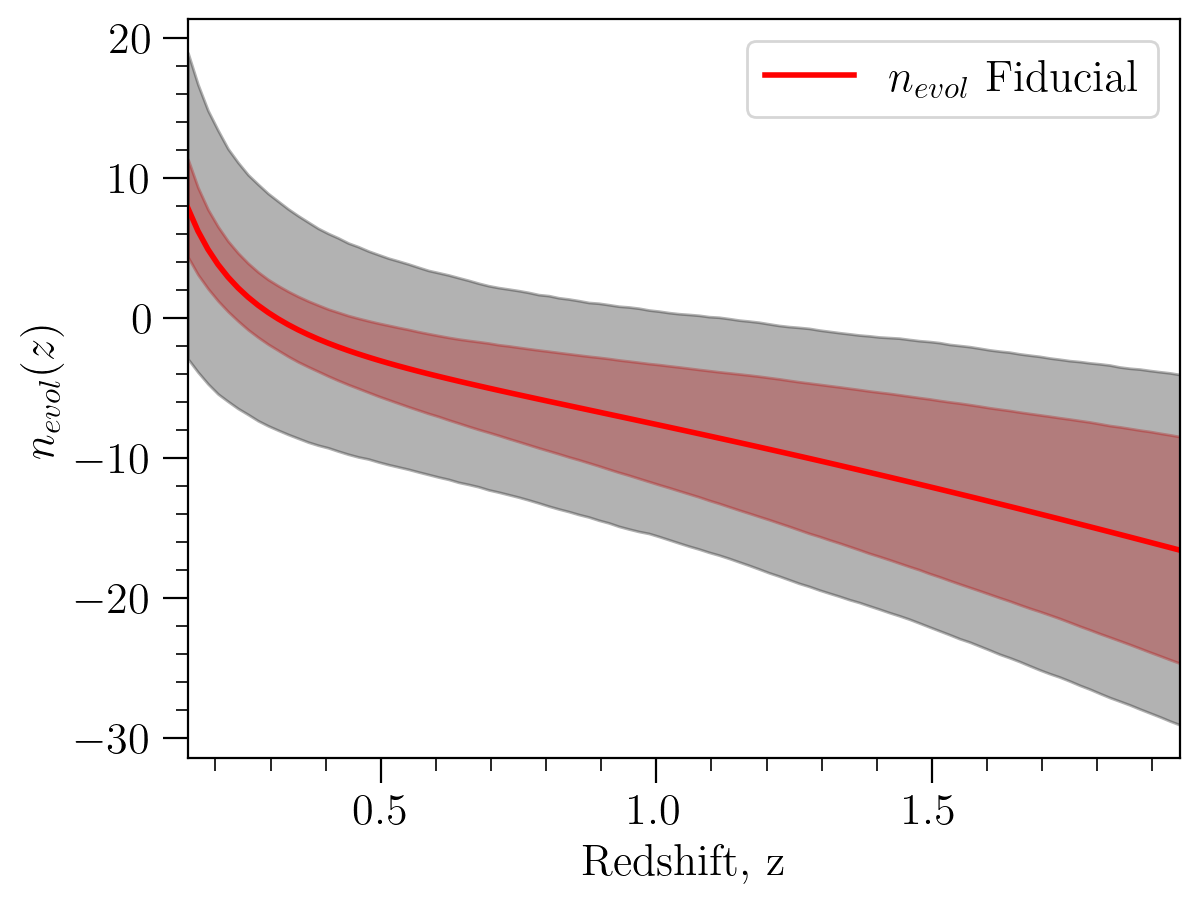

In [33]:
plt.plot(z_lin, num_evol_fid, '-', color='red', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_lower_bound_noct, nevol_upper_bound_noct, color='red', alpha=0.3)
plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3)


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.legend();

##### Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [34]:
m_split = 10/3

myEvolBias = EvolutionBias(n_split=m_split)

dlogH = myEvolBias.dlogH
rHterm = myEvolBias.rHterm
dFstar = myEvolBias.dLogFstar
dFcut = myEvolBias.dLogFcut

In [35]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

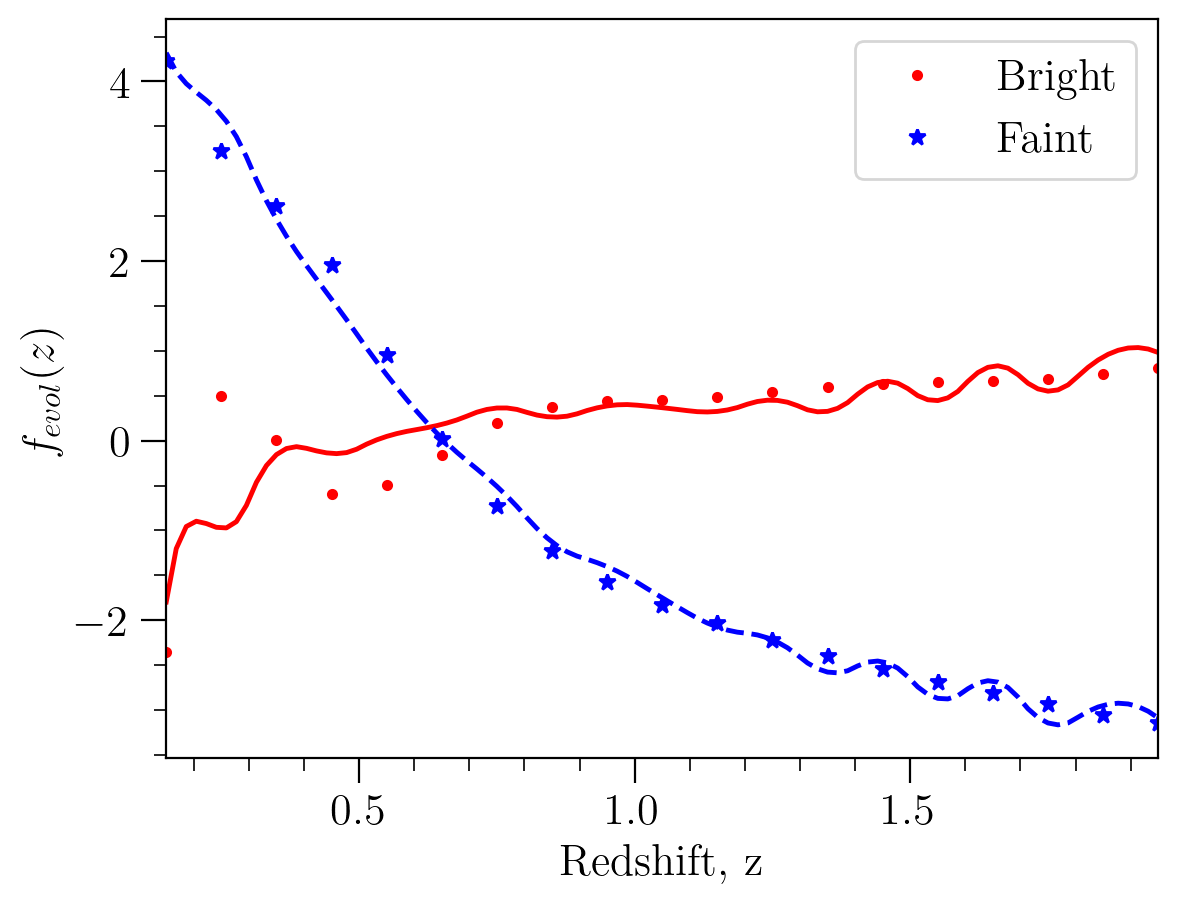

In [36]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_B_fid = fevol_bright(pars_s = sbias_fid, pars_n = nevol_fid, z = z_lin)
fevol_F_fid = fevol_faint(pars_s = sbias_fid, pars_n = nevol_fid, z = z_lin)

plt.plot(z_lin, fevol_B_fid, 'r-')
plt.plot(z_lin, fevol_F_fid, 'b--')

feB = myEvolBias.fevol_bright(z_bins)
feF = myEvolBias.fevol_faint(z_bins)

plt.plot(z_bins, feB, 'r.', label='Bright')
plt.plot(z_bins, feF, 'b*', label='Faint')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$f_{evol}(z)$');
plt.legend();

In [37]:
# Select the marginalized covariance matrix for the number evolution

cov_all_noct = Sigma_Matrix_noct_19bins[:12, :12]
cov_all_priors_noct = Cov_all_19bins[:12, :12]

all_fid = np.concatenate([sbias_fid, nevol_fid])

# Generate parameter samples from multivariate normal distribution

num_samples = 5000
all_pars_samples_noct = np.random.multivariate_normal(all_fid, cov_all_noct, num_samples)
all_pars_samples_priors = np.random.multivariate_normal(all_fid, cov_all_priors_noct, num_samples)

# Evaluate fitting function for each parameter sample

fevol_B_samples_noct = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_noct])
fevol_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_priors])
fevol_F_samples_noct = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_noct])
fevol_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_priors])

# Calculate the 68% confidence intervals

fevol_B_lower_bound_noct = np.percentile(fevol_B_samples_noct, 16, axis=0)
fevol_B_upper_bound_noct = np.percentile(fevol_B_samples_noct, 84, axis=0)
fevol_B_lower_bound_priors = np.percentile(fevol_B_samples_priors, 16, axis=0)
fevol_B_upper_bound_priors = np.percentile(fevol_B_samples_priors, 84, axis=0)

fevol_F_lower_bound_noct = np.percentile(fevol_F_samples_noct, 16, axis=0)
fevol_F_upper_bound_noct = np.percentile(fevol_F_samples_noct, 84, axis=0)
fevol_F_lower_bound_priors = np.percentile(fevol_F_samples_priors, 16, axis=0)
fevol_F_upper_bound_priors = np.percentile(fevol_F_samples_priors, 84, axis=0)

Text(0, 0.5, '$f^{evol}_B(z)$')

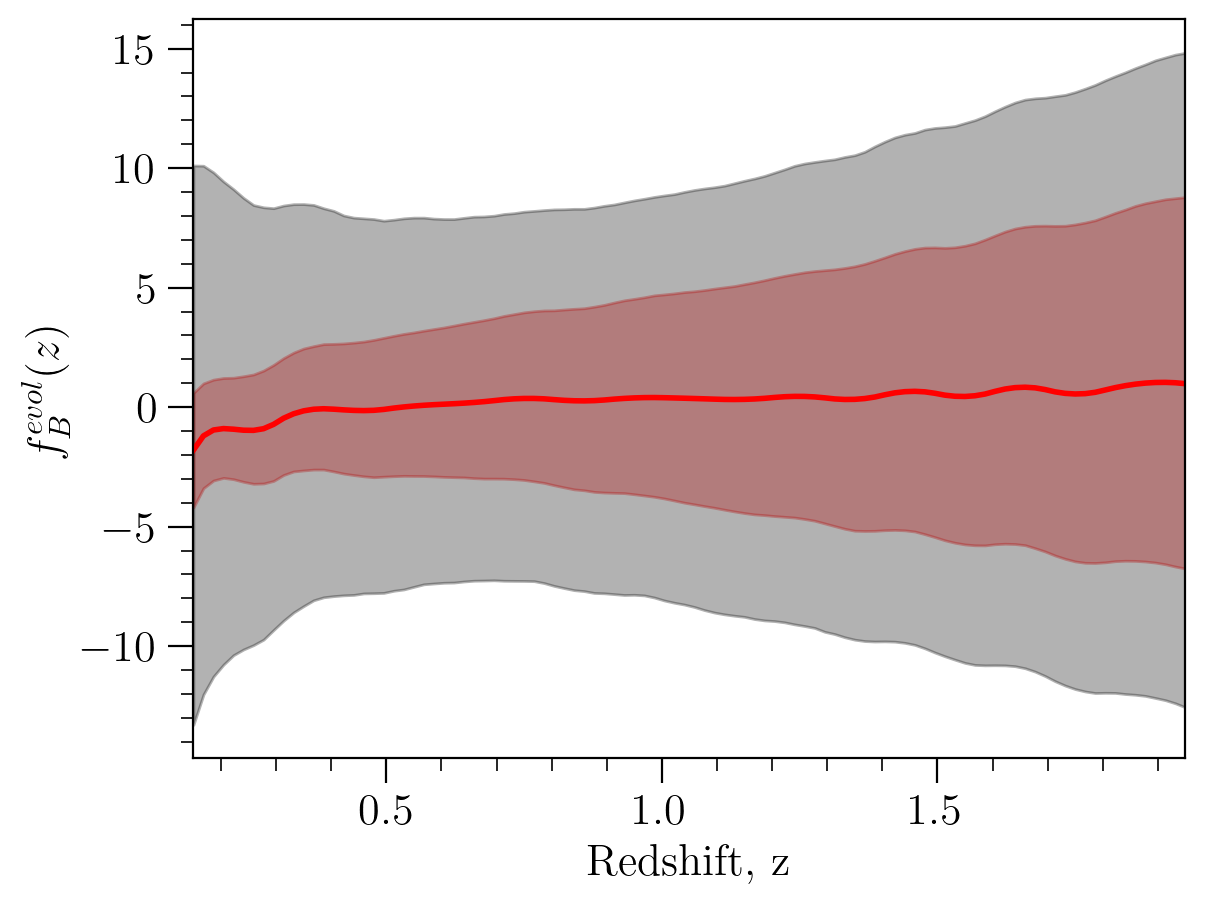

In [40]:
plt.plot(z_lin, fevol_B_fid, '-', color='red', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_B_lower_bound_noct, fevol_B_upper_bound_noct, color='red', alpha=0.3)
plt.fill_between(z_lin, fevol_B_lower_bound_priors, fevol_B_upper_bound_priors, color='black', alpha=0.3)


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_B(z)$')

Text(0, 0.5, '$f^{evol}_F(z)$')

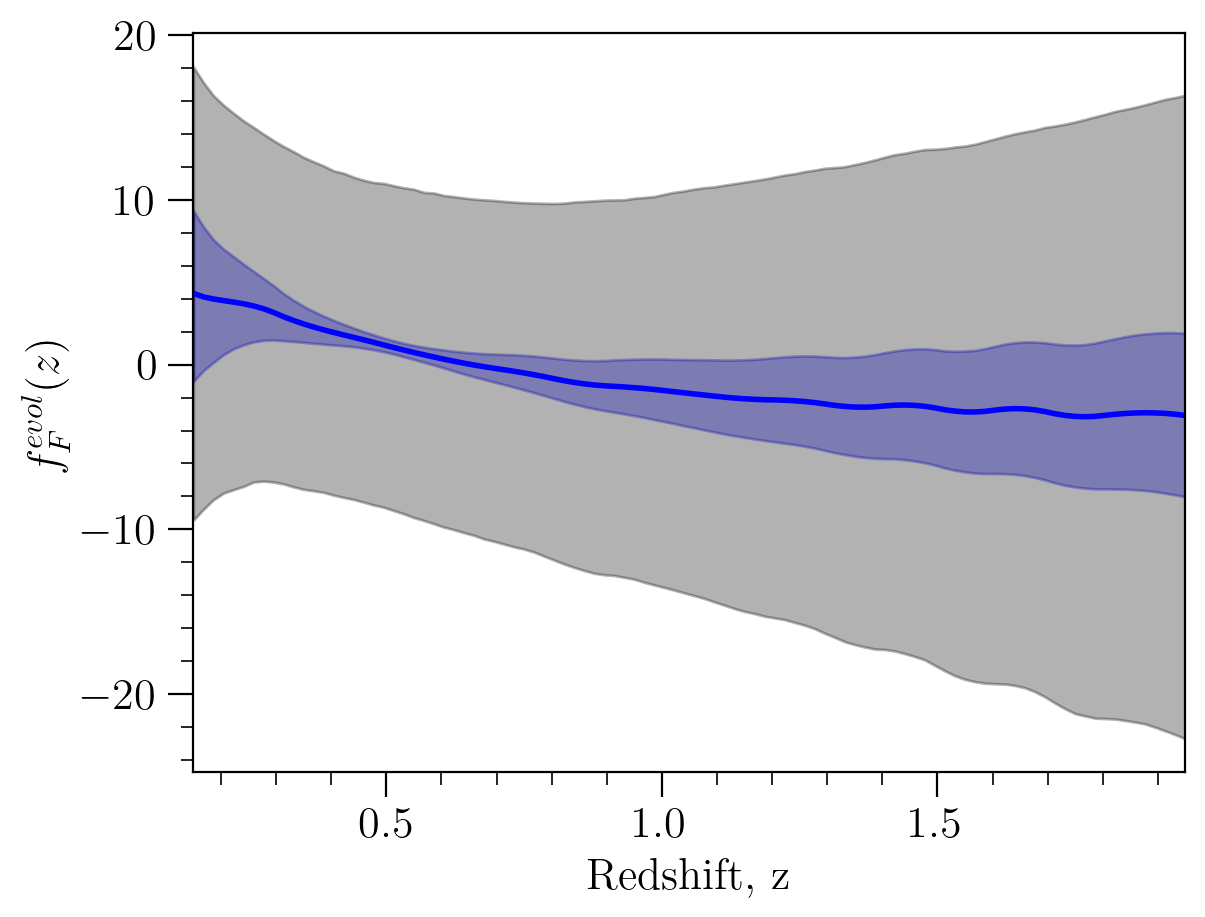

In [41]:
plt.plot(z_lin, fevol_F_fid, '-', color='blue', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_F_lower_bound_noct, fevol_F_upper_bound_noct, color='blue', alpha=0.3)
plt.fill_between(z_lin, fevol_F_lower_bound_priors, fevol_F_upper_bound_priors, color='black', alpha=0.3)

plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_F(z)$')

## NO DIPOLE

In [42]:
# Create the Cov Matrix for sB, sF, nevol

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

sB_4fit = np.array([0.32517608, 0.64417726, 0.16141884, 0.13330365])
sF_4fit = np.array([-0.19376095,  1.0747336,  -0.07806247, -0.00558005])
nevol_fid = np.array([7.94599875, -12.03752387,   2.29927261, -15.83887369])

num_fit = nevol_fid

dsB_19bins = sB_4fit * errB[0] 
dsF_19bins = sF_4fit * errF[0]

dnum_19bins = num_fit * errB[1]

Cov_all_19bins = np.diag(np.concatenate([dsB_19bins**2, dsF_19bins**2, dnum_19bins**2]))

Inv_Cov_all_19bins = np.linalg.inv(Cov_all_19bins)

Inv_Cov_prior_all = np.zeros([len(dsignal_dtheta_fit_all), len(dsignal_dtheta_fit_all)])

Inv_Cov_prior_all[:len(Inv_Cov_all_19bins), :len(Inv_Cov_all_19bins)] = Inv_Cov_all_19bins

np.shape(Cov_all_19bins)

(12, 12)

In [43]:
Cov_multipoles_19bins = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, split=[30,70])

np.shape(Cov_multipoles_19bins), type(Cov_multipoles_19bins)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 

Population splitted in 30% BRIGHT - 70% FAINT 


 ... Success! ... 



((19, 324, 324), list)

In [44]:
# REMOVE DIPOLE

Cov_ndip_19bins = np.delete(Cov_multipoles_19bins, index_dipole, axis=1)
Cov_ndip_19bins = np.delete(Cov_ndip_19bins, index_dipole, axis=2)

np.shape(Cov_ndip_19bins)

(19, 288, 288)

In [45]:
Inv_Cov_multipoles_ndip_19bins = [np.linalg.inv(Cov_ndip_19bins[k]) for k,_ in enumerate(z_bins)]

Fisher_Matrix_multipoles_ndip_19bins = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_ndip, inv_cov = Inv_Cov_multipoles_ndip_19bins, z_bins = z_bins)
Fisher_Matrix_ndip_19bins = Fisher_Matrix_multipoles_ndip_19bins + Inv_Cov_prior_all

Sigma_Matrix_ndip_19bins = np.linalg.inv(Fisher_Matrix_ndip_19bins)

np.shape(Sigma_Matrix_ndip_19bins)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

#### Compare FISHER MATRICES

In [46]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_noct_19bins[:12,:12]]))

5971.116958562471	3198.7667948801854	-5440.491364710829	8927.573694086166	-6449.298358930175	-6151.251975442635	-1193.3574128325786	5846.222329988491	-223.2665453320819	-229.47341739874057	267.8332487926422	-67.57067588196844
3198.7667948801864	2597.059932738158	-1170.8379666981812	1696.3000252899913	-6151.251975442634	-5372.333347017376	891.7040330084855	125.4168777307639	-229.47341739874062	-193.49190849721927	-223.26654533208185	-100.15239057666305
-5440.49136471083	-1170.8379666981805	9081.088952247224	-15773.687317298805	-1193.3574128325786	891.7040330084852	5846.222329988487	-13149.981948352293	-99.5922976043062	35.570431739147	-1234.9113651413788	-122.04777305704562
8927.573694086164	1696.3000252899894	-15773.687317298794	29343.946600248277	5846.222329988484	125.41687773076183	-13149.98194835229	25486.713942103837	350.3421839567217	21.899468157679408	2585.5723205710624	322.02656665772093
-6449.298358930176	-6151.251975442635	-1193.3574128325777	5846.222329988487	36259.5397464481

In [47]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Fisher_Matrix_ndip_19bins[:12,:12]]))

215.71829406525939	72.79160584044746	-214.61245994227687	366.9469449326754	-72.31577165555868	-80.12298631645602	-47.65216808143387	146.87695213505071	0.0	0.0	0.0	0.0
72.79160584044747	58.943325968028915	-43.44597621460514	63.6734053771143	-80.12298631645601	-68.01000791307004	10.770522123499324	11.607229424052328	0.0	0.0	0.0	0.0
-214.61245994227676	-43.4459762146051	520.4622030937294	-665.7706294043219	-47.652168081433814	10.77052212349933	146.87695213505063	-306.6157116369259	0.0	0.0	0.0	0.0
366.94694493267525	63.673405377114236	-665.7706294043221	1463.8131674430729	146.87695213505066	11.607229424052303	-306.61571163692594	586.464588090141	0.0	0.0	0.0	0.0
-72.31577165555859	-80.122986316456	-47.652168081433935	146.8769521350508	454.49813404088684	180.70458496139133	-270.55027310145806	299.1387787175044	0.0	0.0	0.0	0.0
-80.122986316456	-68.01000791307003	10.770522123499317	11.607229424052317	180.70458496139133	120.43641203883948	-97.34073192069039	92.30344850185307	0.0	0.0	0.0	0.0
-47

In [48]:
# Print Fisher ELEMENTS 

import pandas as pd

row_names = {
    0: r"$s_{B,0}$",
    1: r"sB_1",
    2: r"sB_2",
    3: r"sB_3",
    4: r"sM_0",
    5: r"sM_2",
    6: r"sM_3",
    7: r"sM_4"
}

fisher_s = {
    "DIPOLE" : np.diag(Fisher_Matrix_noct_19bins[:8,:8]),
    "OCTUPOLE" : np.diag(Fisher_Matrix_ndip_19bins[:8,:8]),
    "R. Factor" : np.diag(Fisher_Matrix_noct_19bins[:8,:8])/np.diag(Fisher_Matrix_ndip_19bins[:8,:8])
}

df_fisher_s = pd.DataFrame(fisher_s, index=row_names.values())
df_fisher_s = df_fisher_s.apply(pd.Series.round, args=[2])

df_fisher_s

DIPOLE   OCTUPOLE  R. Factor
$s_{B,0}$    5971.12     215.72      27.68
sB_1         2597.06      58.94      44.06
sB_2         9081.09     520.46      17.45
sB_3        29343.95    1463.81      20.05
sM_0        36259.54     454.50      79.78
sM_2        13392.02     120.44     111.20
sM_3        29072.49     955.55      30.42
sM_4       176529.67  129003.29       1.37

In [49]:
index_labels_ = [name for _,name in enumerate(row_names.values())]

index_labels_

['$s_{B,0}$', 'sB_1', 'sB_2', 'sB_3', 'sM_0', 'sM_2', 'sM_3', 'sM_4']

In [50]:
index_labels = [r'$s_{B,0}$', r'$s_{B,1}$', r'$s_{B,2}$', r'$s_{B,3}$', r'$s_{M,0}$', r'$s_{M,1}$', r'$s_{M,2}$', r'$s_{M,3}$']

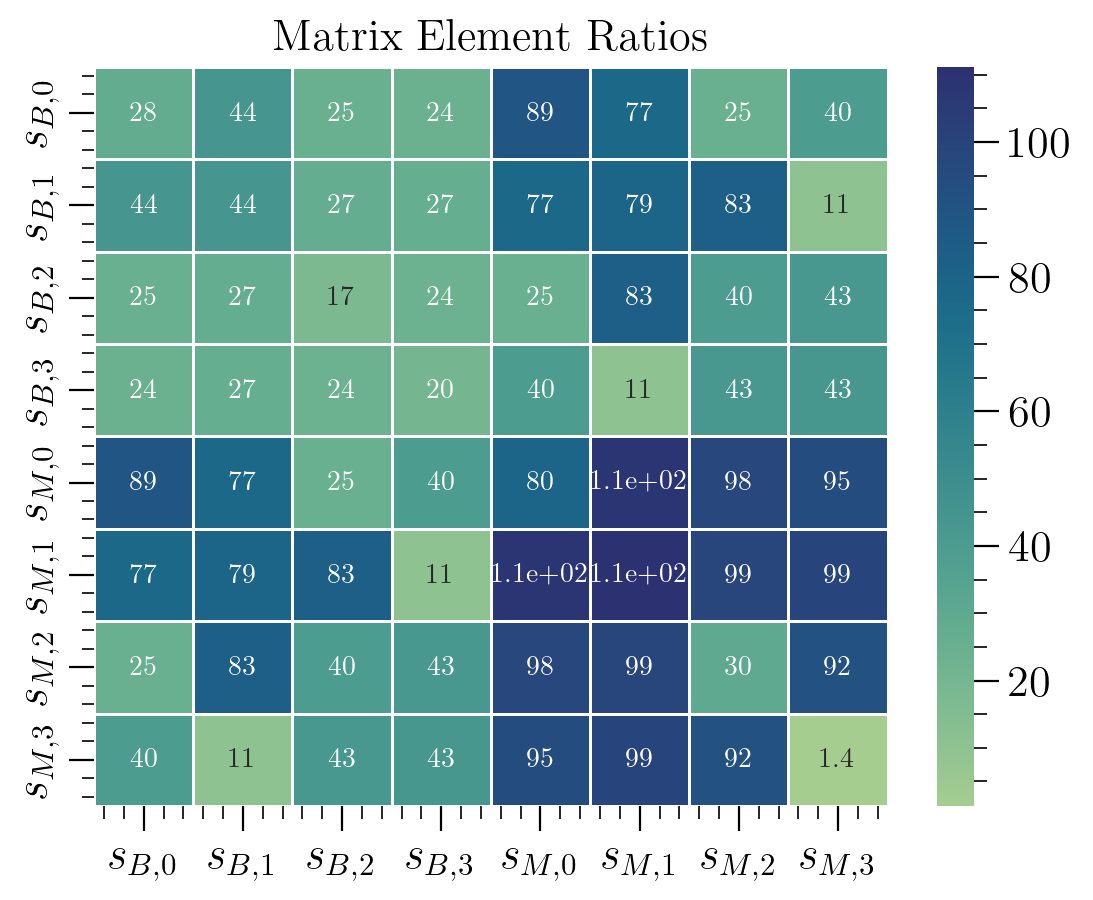

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the element-wise ratio
element_ratio = Fisher_Matrix_noct_19bins[:8,:8] / Fisher_Matrix_ndip_19bins[:8,:8]

# Create the heatmap
sns.heatmap(element_ratio, cmap='crest', annot=True, linewidths=0.5,
            xticklabels= index_labels, yticklabels=index_labels)
plt.title("Matrix Element Ratios")
#plt.xlabel("Column Index")
#plt.ylabel("Row Index")
plt.show()

In [52]:
index_labels = [r'$s_{B,0}$', r'$s_{B,1}$', r'$s_{B,2}$', r'$s_{B,3}$', r'$s_{M,0}$', r'$s_{M,1}$', r'$s_{M,2}$', r'$s_{M,3}$', r'$n^{evol}_0$', r'$n^{evol}_1$', r'$n^{evol}_2$', r'$n^{evol}_3$']

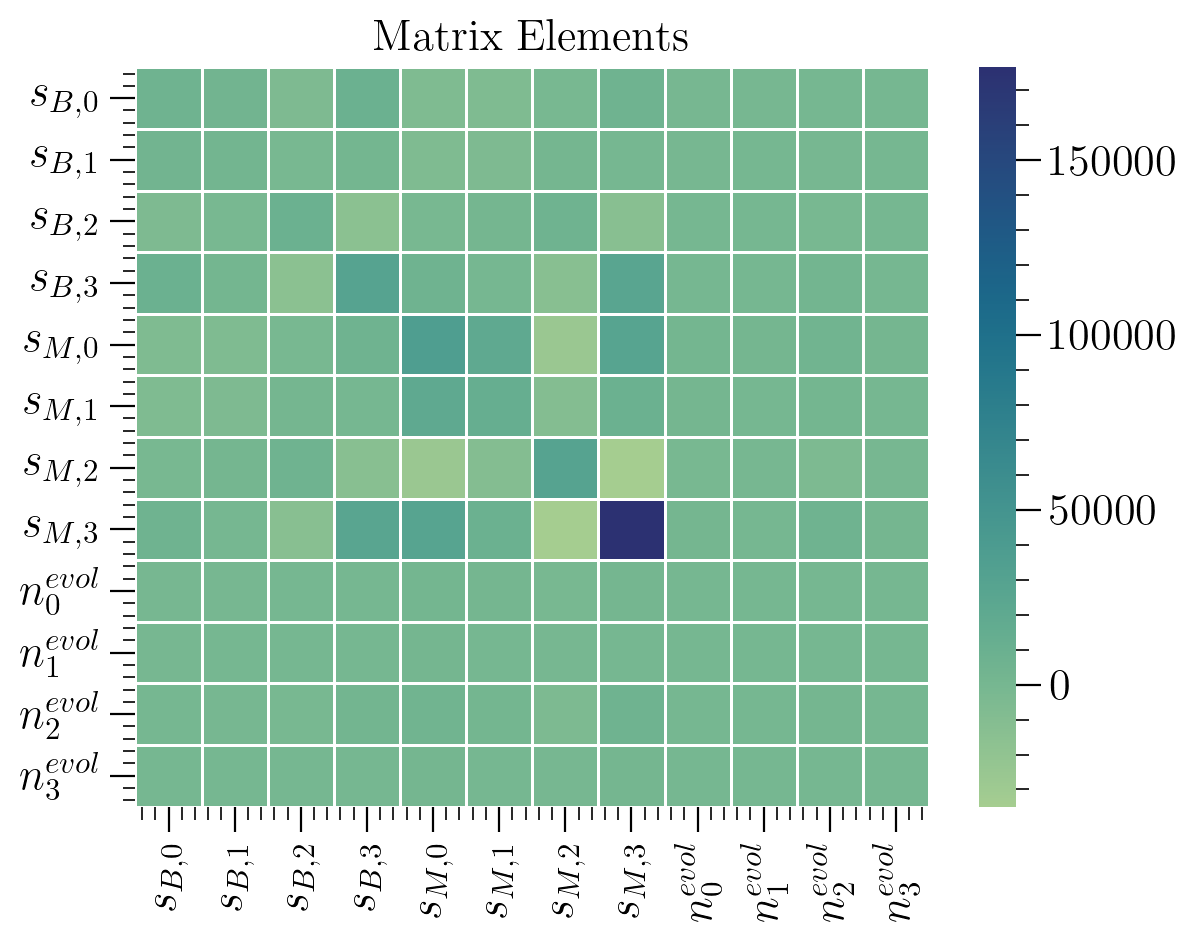

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the element-wise ratio
element_ratio = Fisher_Matrix_noct_19bins[:12,:12]

# Create the heatmap
sns.heatmap(element_ratio, cmap='crest', annot=False, linewidths=0.5,
            xticklabels= index_labels, yticklabels=index_labels)
plt.title("Matrix Elements")
#plt.xlabel("Column Index")
#plt.ylabel("Row Index")
plt.show()

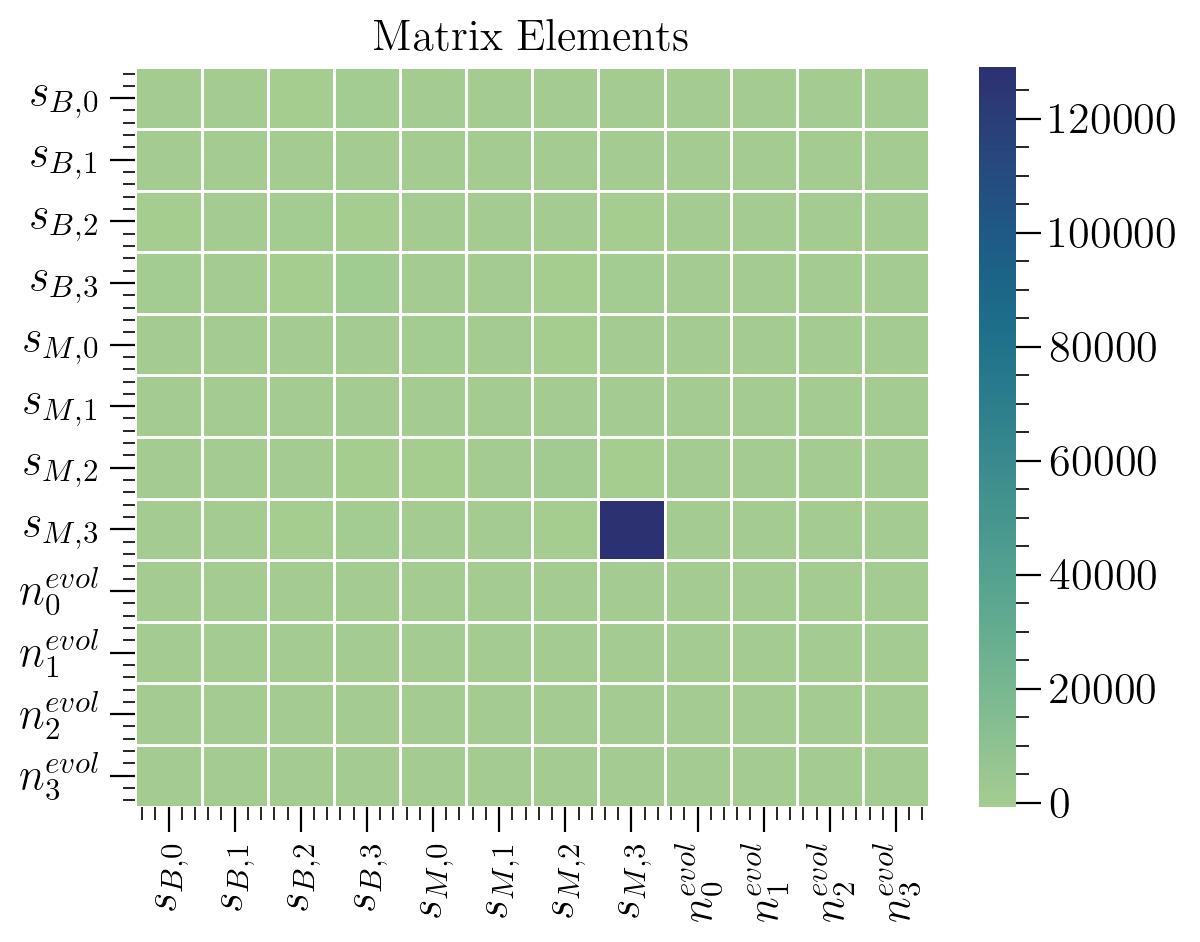

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the element-wise ratio
element_ratio = Fisher_Matrix_ndip_19bins[:12,:12]

# Create the heatmap
sns.heatmap(element_ratio, cmap='crest', annot=False, linewidths=0.5,
            xticklabels= index_labels, yticklabels=index_labels)
plt.title("Matrix Elements")
#plt.xlabel("Column Index")
#plt.ylabel("Row Index")
plt.show()

#### Constraints

In [55]:
#Absolute Errors

Abs_Errors_ndip_19bins = np.sqrt(np.diag(Sigma_Matrix_ndip_19bins))

# Fiducial values

sbias_fid = np.concatenate([sB_4fit, sF_4fit])
num_fid = num_fit
gbias_fid = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sbias_fid, num_fid, gbias_fid, cosmic_fid])

# Relative errors

Rel_Errors_ndip_19bins = np.abs(Abs_Errors_ndip_19bins/params_fid)

params_errors_ndip_19bins = Rel_Errors_ndip_19bins * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sbias = ', params_errors_ndip_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_ndip_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])
print()
print('gbias = ', params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))])
print()
print('cosmic = ', params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid)+len(gbias_fid)):])


------------ Relative errors * 100 ------------

sbias =  [41.36579942 41.06859056 44.33822199 35.12391771 42.05519527 22.41799764
 47.48736627 49.98186376]

number =  [50. 50. 50. 50.]

gbias =  [0.52039511 0.43545145 0.15660495 0.26611438]

cosmic =  [1.07784781 0.68979034 0.87050764 1.1111409  0.47990695]


#### Predictions

##### Magnification bias

###### Compare the two observables

In [56]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_ndip = Sigma_Matrix_ndip_19bins[:4, :4]
cov_sM_ndip = Sigma_Matrix_ndip_19bins[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sB_pars_samples_ndip = np.random.multivariate_normal(sB_4fit, cov_sB_ndip, num_samples)
sM_pars_samples_ndip = np.random.multivariate_normal(sF_4fit, cov_sM_ndip, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_ndip = np.array([magbias_fit(pars, z_lin) for pars in sB_pars_samples_ndip])
sM_samples_ndip = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_ndip])

# Calculate the 68% confidence interval
sB_lower_bound_ndip = np.percentile(sB_samples_ndip, 16, axis=0)
sB_upper_bound_ndip = np.percentile(sB_samples_ndip, 84, axis=0)
sM_lower_bound_ndip = np.percentile(sM_samples_ndip, 16, axis=0)
sM_upper_bound_ndip = np.percentile(sM_samples_ndip, 84, axis=0)

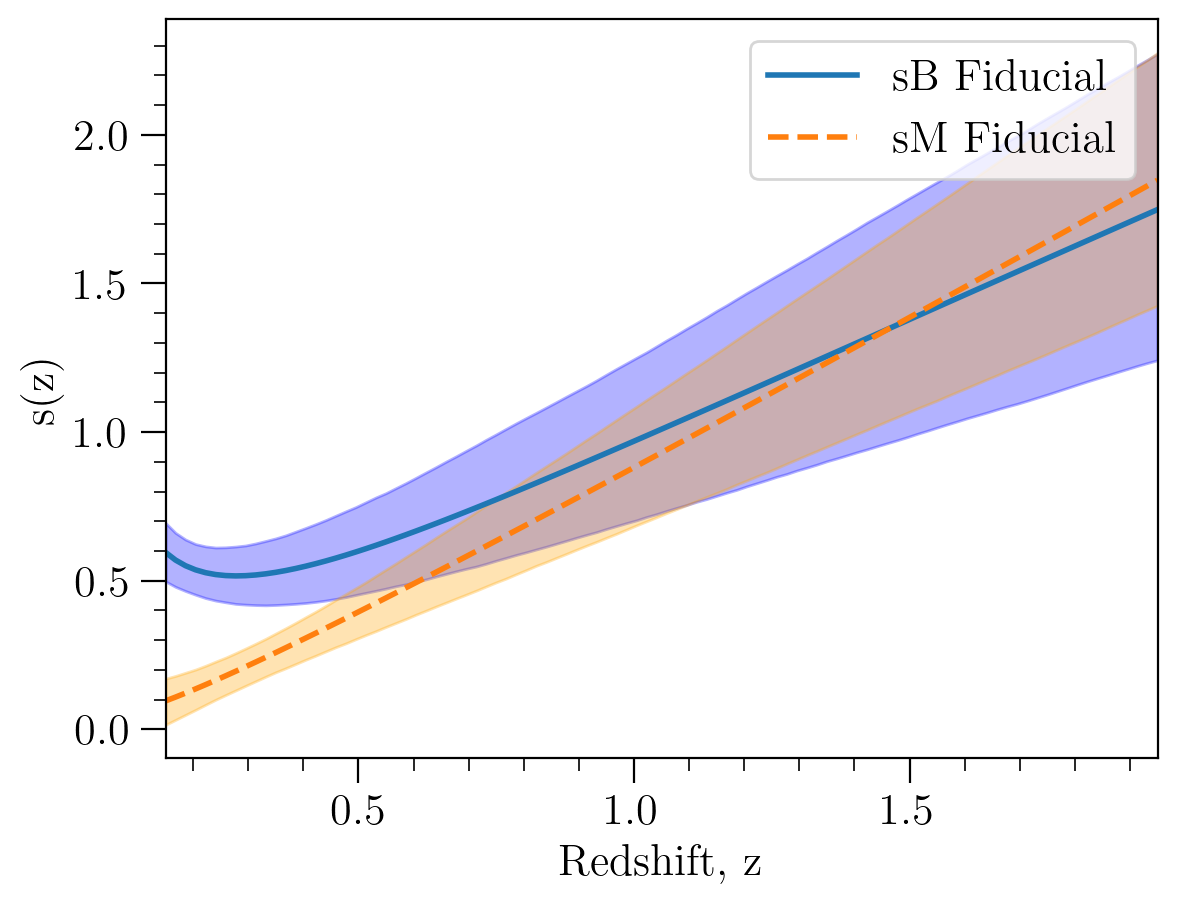

In [57]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0)
plt.plot(z_lin, sM_fid, '--', label=r'sM Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='blue', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_ndip, sM_upper_bound_ndip, color='orange', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();

###### Compare with priors

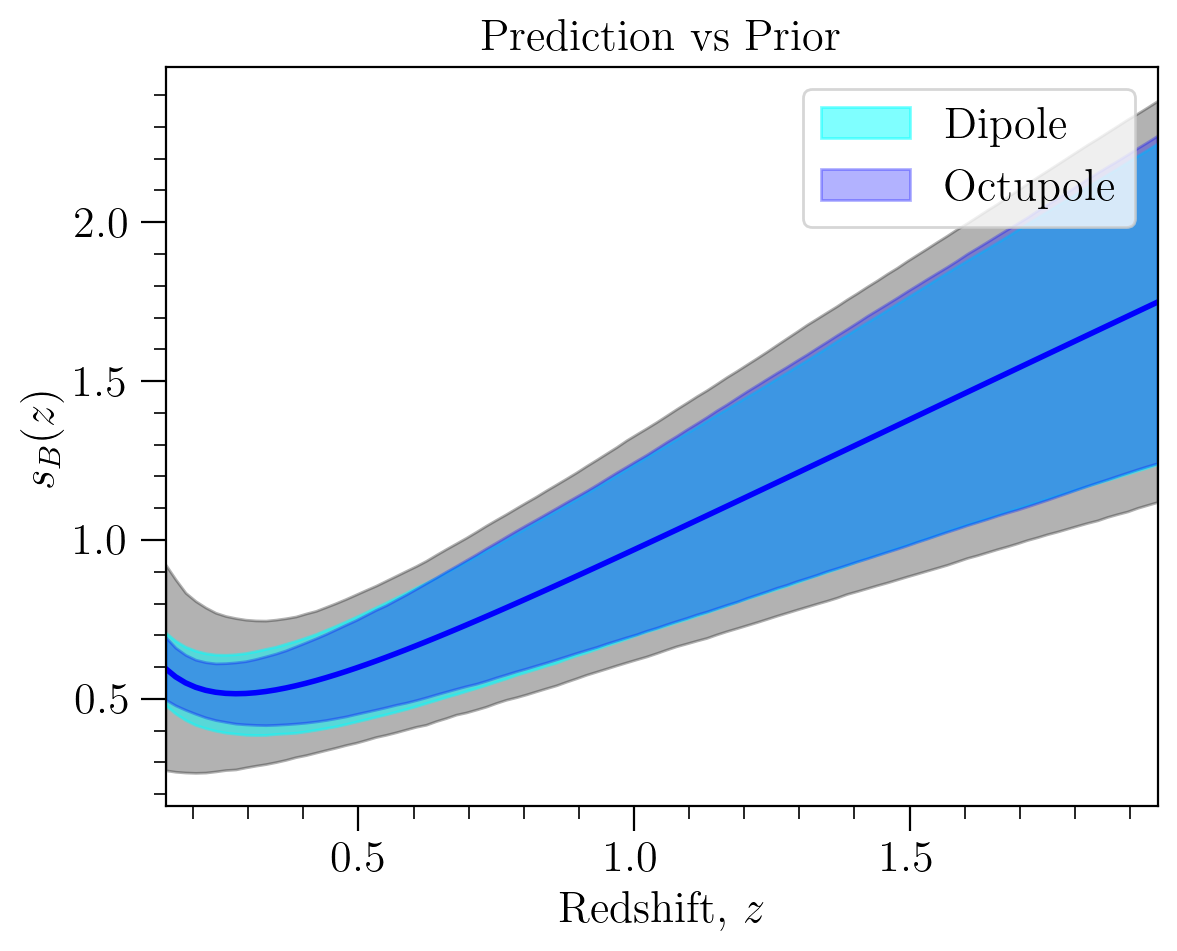

In [58]:
plt.plot(z_lin, sB_fid, '-', lw = 2.0, color='blue')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='cyan', alpha=0.5, label = 'Dipole')
plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='blue', alpha=0.3, label = 'Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_B(z)$');
plt.title(r'Prediction vs Prior')
plt.legend();

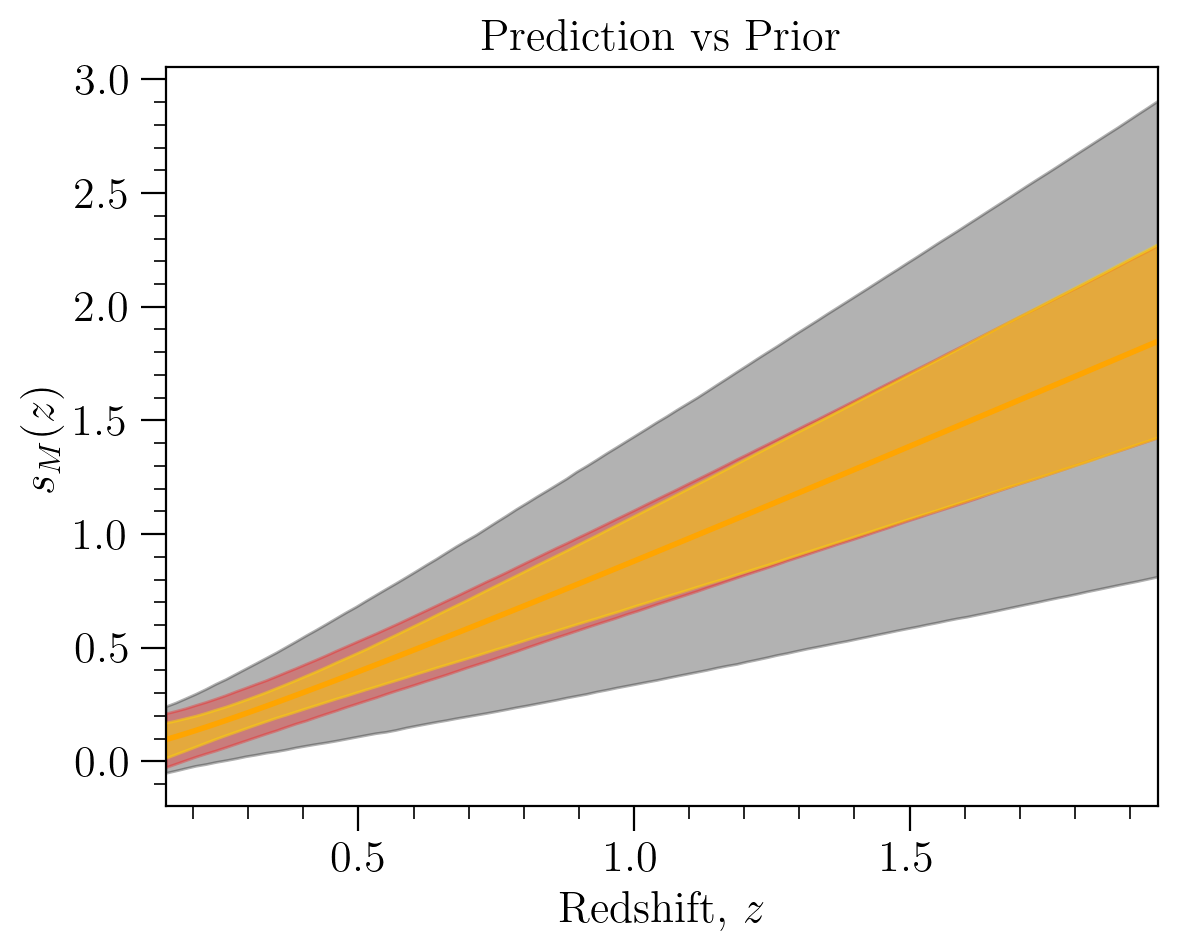

In [59]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='orange')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='red', alpha=0.3, label = 'Dipole')
plt.fill_between(z_lin, sM_lower_bound_ndip, sM_upper_bound_ndip, color='gold', alpha=0.5, label = 'Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.title(r'Prediction vs Prior');

###### Magnification bias of the Faint

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_m$ parameters.

In [60]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_ndip = Sigma_Matrix_ndip_19bins[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sbias_pars_samples_ndip = np.random.multivariate_normal(sbias_fid, cov_sbias_ndip, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_ndip = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_ndip])
sM_samples_ndip = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_ndip])

# Compute the sF for each sample
sF_samples_ndip = sM_samples_ndip*m_split/(m_split-1) - sB_samples_ndip/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_ndip = np.percentile(sF_samples_ndip, 16, axis=0)
sF_upper_bound_ndip = np.percentile(sF_samples_ndip, 84, axis=0)

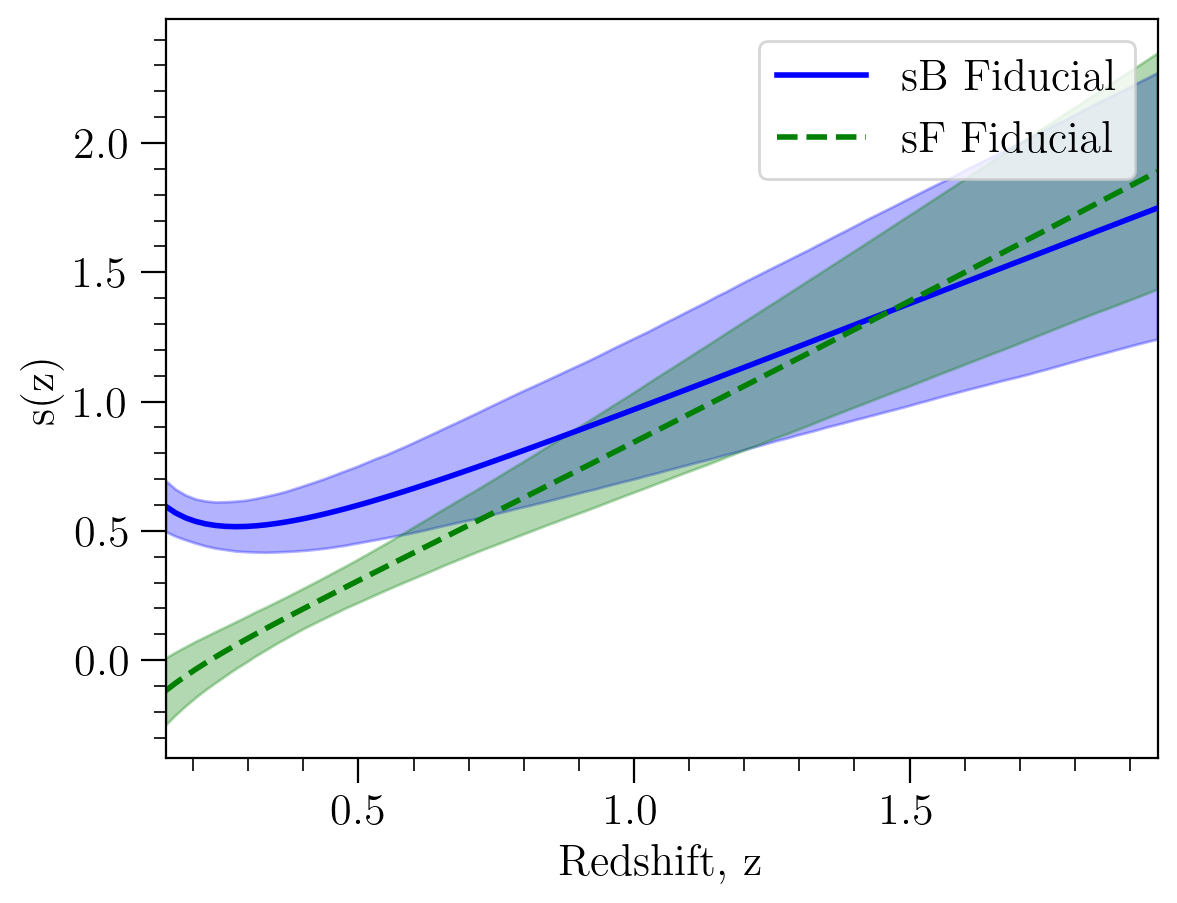

In [61]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0, color='blue')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 2.0, color='green')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='blue', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_ndip, sF_upper_bound_ndip, color='green', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();

Compare with priors

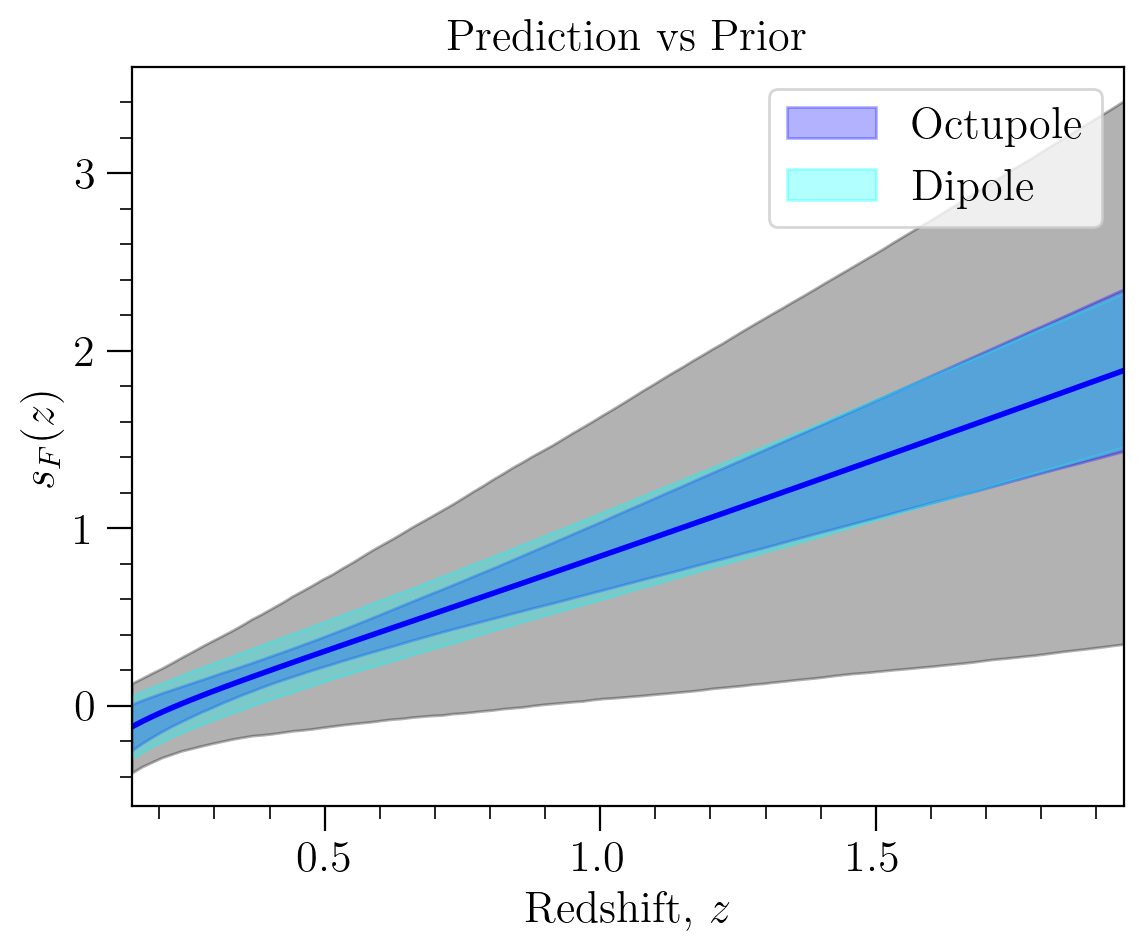

In [62]:
plt.plot(z_lin, sF_fid, '-', lw = 2.0, color='blue')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_ndip, sF_upper_bound_ndip, color='blue', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='cyan', alpha=0.3, label = 'Dipole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_F(z)$');
plt.title(r'Prediction vs Prior')
plt.legend();

##### Number evolution

In [63]:
# Select the marginalized covariance matrix for the number evolution
cov_numevol_ndip = Sigma_Matrix_ndip_19bins[8:12, 8:12]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
nevol_pars_samples_ndip = np.random.multivariate_normal(nevol_fid, cov_numevol_ndip, num_samples)

# Evaluate fitting function for each parameter sample
nevol_samples_ndip = np.array([nevol_fit(pars, z_lin) for pars in nevol_pars_samples_ndip])

# Calculate the 68% confidence interval
nevol_lower_bound_ndip = np.percentile(nevol_samples_ndip, 16, axis=0)
nevol_upper_bound_ndip = np.percentile(nevol_samples_ndip, 84, axis=0)

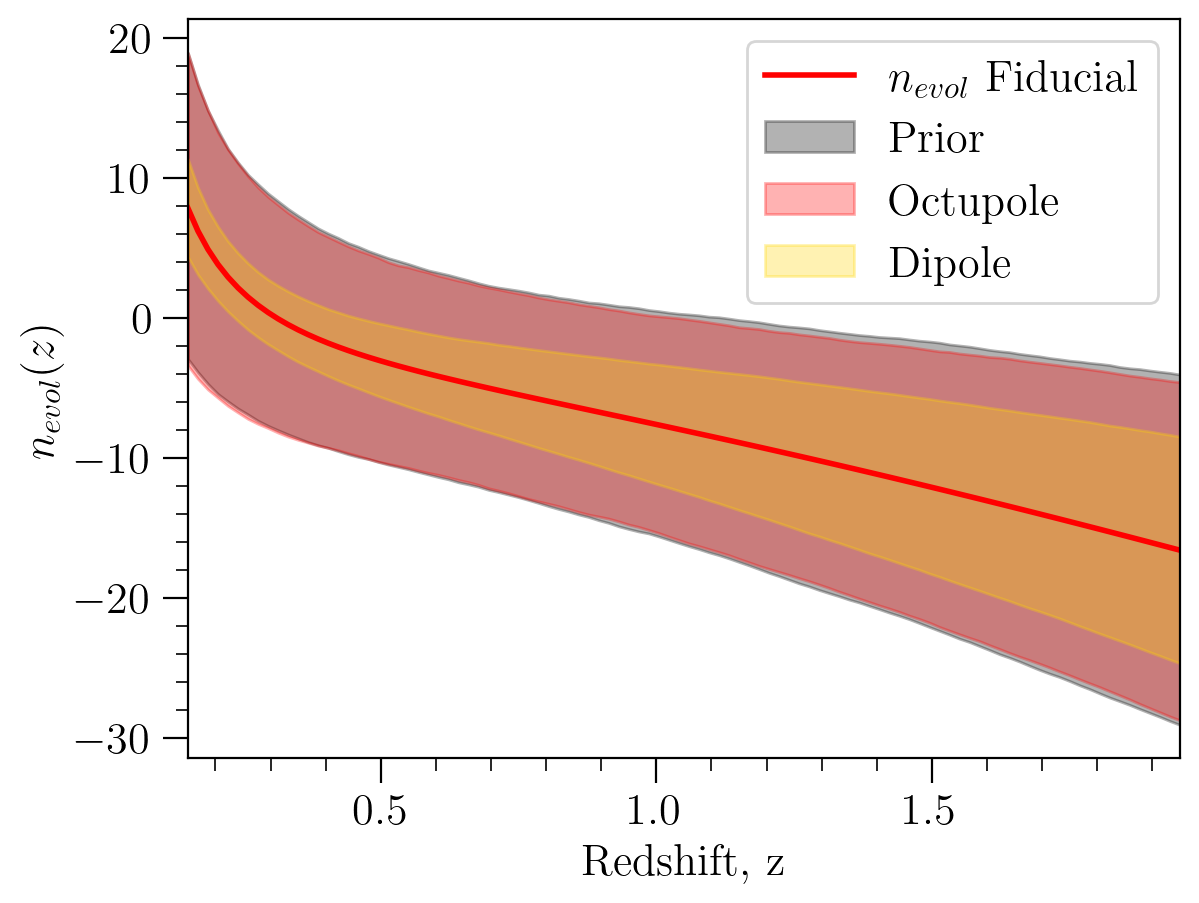

In [64]:
plt.plot(z_lin, num_evol_fid, '-', color='red', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
plt.fill_between(z_lin, nevol_lower_bound_ndip, nevol_upper_bound_ndip, color='red', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, nevol_lower_bound_noct, nevol_upper_bound_noct, color='gold', alpha=0.3, label = 'Dipole')


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.legend();

##### Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [65]:
# Select the marginalized covariance matrix for the number evolution

cov_all_ndip = Sigma_Matrix_ndip_19bins[:12, :12]

all_fid = np.concatenate([sbias_fid, nevol_fid])

# Generate parameter samples from multivariate normal distribution

num_samples = 5000
all_pars_samples_ndip = np.random.multivariate_normal(all_fid, cov_all_ndip, num_samples)

# Evaluate fitting function for each parameter sample

fevol_B_samples_ndip = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_ndip])
fevol_F_samples_ndip = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_ndip])

# Calculate the 68% confidence intervals

fevol_B_lower_bound_ndip = np.percentile(fevol_B_samples_ndip, 16, axis=0)
fevol_B_upper_bound_ndip = np.percentile(fevol_B_samples_ndip, 84, axis=0)

fevol_F_lower_bound_ndip = np.percentile(fevol_F_samples_ndip, 16, axis=0)
fevol_F_upper_bound_ndip = np.percentile(fevol_F_samples_ndip, 84, axis=0)

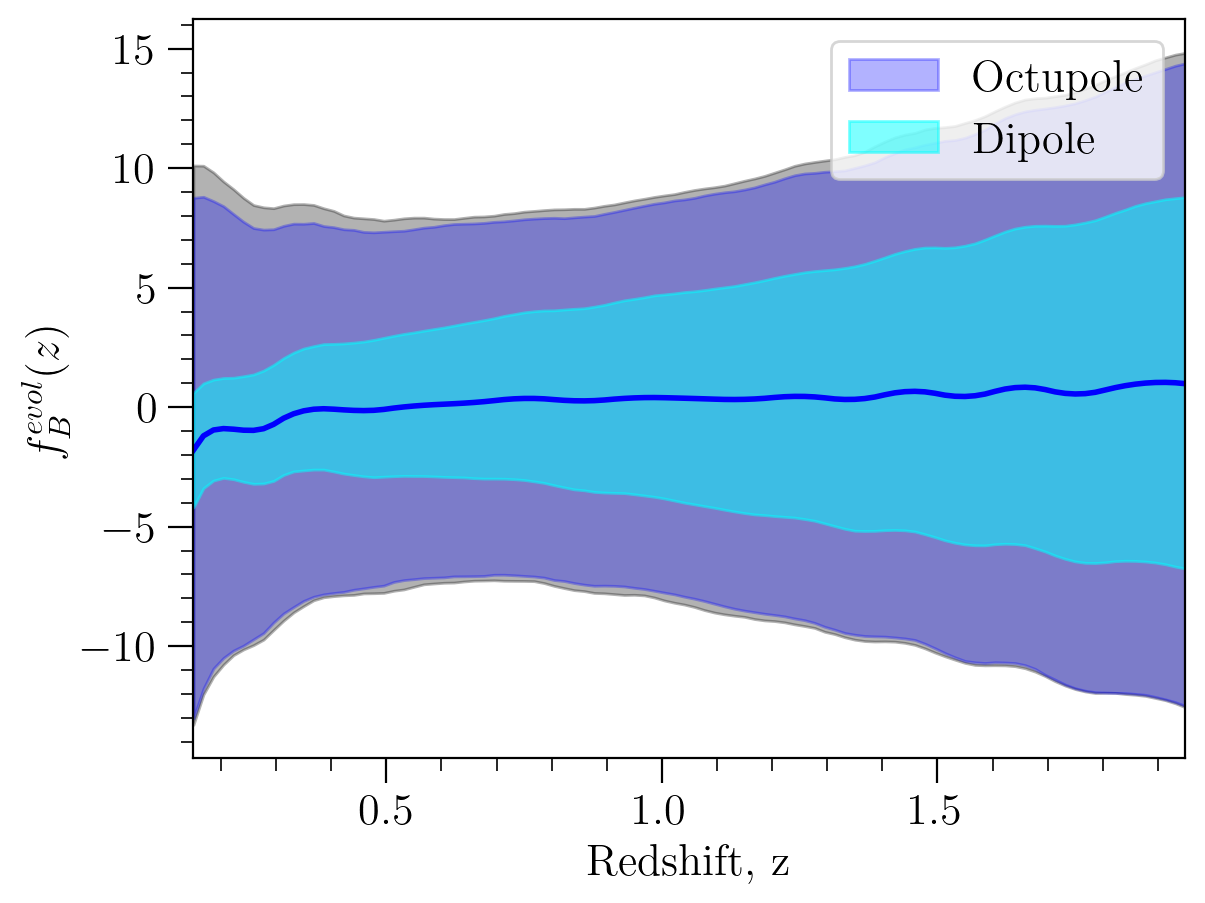

In [66]:
plt.plot(z_lin, fevol_B_fid, '-', color='blue', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_B_lower_bound_priors, fevol_B_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, fevol_B_lower_bound_ndip, fevol_B_upper_bound_ndip, color='blue', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, fevol_B_lower_bound_noct, fevol_B_upper_bound_noct, color='cyan', alpha=0.5, label = 'Dipole')


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_B(z)$')
plt.legend();

Text(0, 0.5, '$f^{evol}_F(z)$')

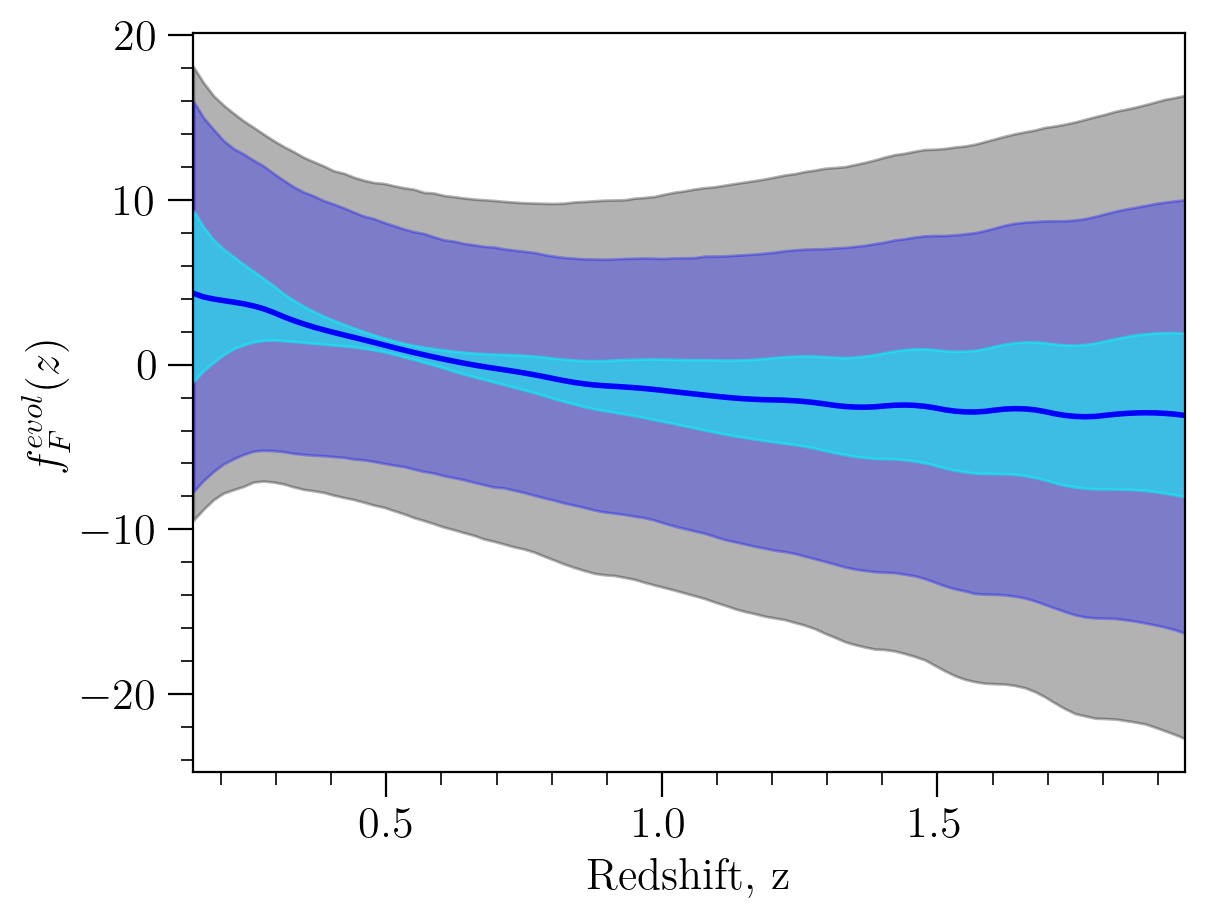

In [67]:
plt.plot(z_lin, fevol_F_fid, '-', color='blue', lw = 2.0)

# Shade the 68% confidence interval
plt.fill_between(z_lin, fevol_F_lower_bound_priors, fevol_F_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, fevol_F_lower_bound_ndip, fevol_F_upper_bound_ndip, color='blue', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, fevol_F_lower_bound_noct, fevol_F_upper_bound_noct, color='cyan', alpha=0.5, label = 'Dipole')


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_F(z)$')

## Compare DIPOLE vs OCTUPOLE when SAMPLING ALL TOGETHER

In [68]:
# Select the marginalized covariance matrix for the magnification biases

cov_ndip = Sigma_Matrix_ndip_19bins[:12,:12]
cov_noct = Sigma_Matrix_noct_19bins[:12,:12]

# Generate parameter samples from multivariate normal distribution

num_samples = 5000

sB_pars_samples_ndip = np.random.multivariate_normal(all_fid, cov_ndip, num_samples)
sM_pars_samples_ndip = np.random.multivariate_normal(all_fid, cov_ndip, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_ndip = np.array([magbias_fit(pars[:4], z_lin) for pars in sB_pars_samples_ndip])
sM_samples_ndip = np.array([magbias_fit(pars[4:8], z_lin) for pars in sM_pars_samples_ndip])

# Calculate the 68% confidence interval
sB_lower_bound_ndip = np.percentile(sB_samples_ndip, 16, axis=0)
sB_upper_bound_ndip = np.percentile(sB_samples_ndip, 84, axis=0)
sM_lower_bound_ndip = np.percentile(sM_samples_ndip, 16, axis=0)
sM_upper_bound_ndip = np.percentile(sM_samples_ndip, 84, axis=0)

# Generate parameter samples from multivariate normal distribution

sB_pars_samples_noct = np.random.multivariate_normal(all_fid, cov_noct, num_samples)
sM_pars_samples_noct = np.random.multivariate_normal(all_fid, cov_noct, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_noct = np.array([magbias_fit(pars[:4], z_lin) for pars in sB_pars_samples_noct])
sM_samples_noct = np.array([magbias_fit(pars[4:8], z_lin) for pars in sM_pars_samples_noct])

# Calculate the 68% confidence interval
sB_lower_bound_noct = np.percentile(sB_samples_noct, 16, axis=0)
sB_upper_bound_noct = np.percentile(sB_samples_noct, 84, axis=0)
sM_lower_bound_noct = np.percentile(sM_samples_noct, 16, axis=0)
sM_upper_bound_noct = np.percentile(sM_samples_noct, 84, axis=0)

In [69]:
# Compute the sF for each sample
sF_samples_ndip = sM_samples_ndip*m_split/(m_split-1) - sB_samples_ndip/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_ndip = np.percentile(sF_samples_ndip, 16, axis=0)
sF_upper_bound_ndip = np.percentile(sF_samples_ndip, 84, axis=0)

# Compute the sF for each sample
sF_samples_noct = sM_samples_noct*m_split/(m_split-1) - sB_samples_noct/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_noct = np.percentile(sF_samples_noct, 16, axis=0)
sF_upper_bound_noct = np.percentile(sF_samples_noct, 84, axis=0)

In [70]:
nevol_pars_samples_ndip = np.random.multivariate_normal(all_fid, cov_ndip, num_samples)

# Evaluate fitting function for each parameter sample
nevol_samples_ndip = np.array([nevol_fit(pars[8:12], z_lin) for pars in nevol_pars_samples_ndip])

# Calculate the 68% confidence interval
nevol_lower_bound_ndip = np.percentile(nevol_samples_ndip, 16, axis=0)
nevol_upper_bound_ndip = np.percentile(nevol_samples_ndip, 84, axis=0)

nevol_pars_samples_noct = np.random.multivariate_normal(all_fid, cov_noct, num_samples)

# Evaluate fitting function for each parameter sample
nevol_samples_noct = np.array([nevol_fit(pars[8:12], z_lin) for pars in nevol_pars_samples_noct])

# Calculate the 68% confidence interval
nevol_lower_bound_noct = np.percentile(nevol_samples_noct, 16, axis=0)
nevol_upper_bound_noct = np.percentile(nevol_samples_noct, 84, axis=0)

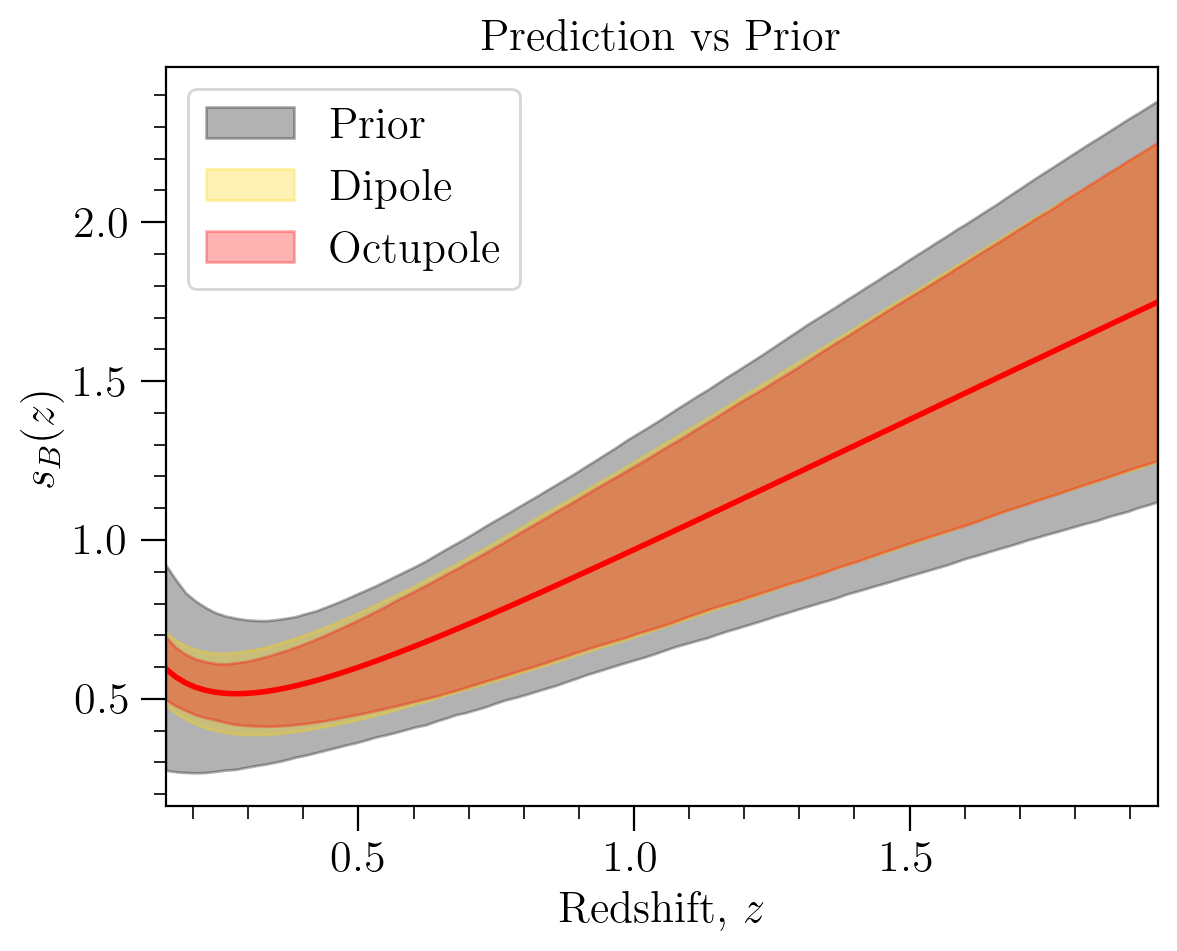

In [71]:
plt.plot(z_lin, sB_fid, '-', lw = 2.0, color='red')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='gold', alpha=0.3, label = 'Dipole')
plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='red', alpha=0.3, label = 'Octupole')


plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_B(z)$');
plt.title(r'Prediction vs Prior')
plt.legend(loc = 'upper left')

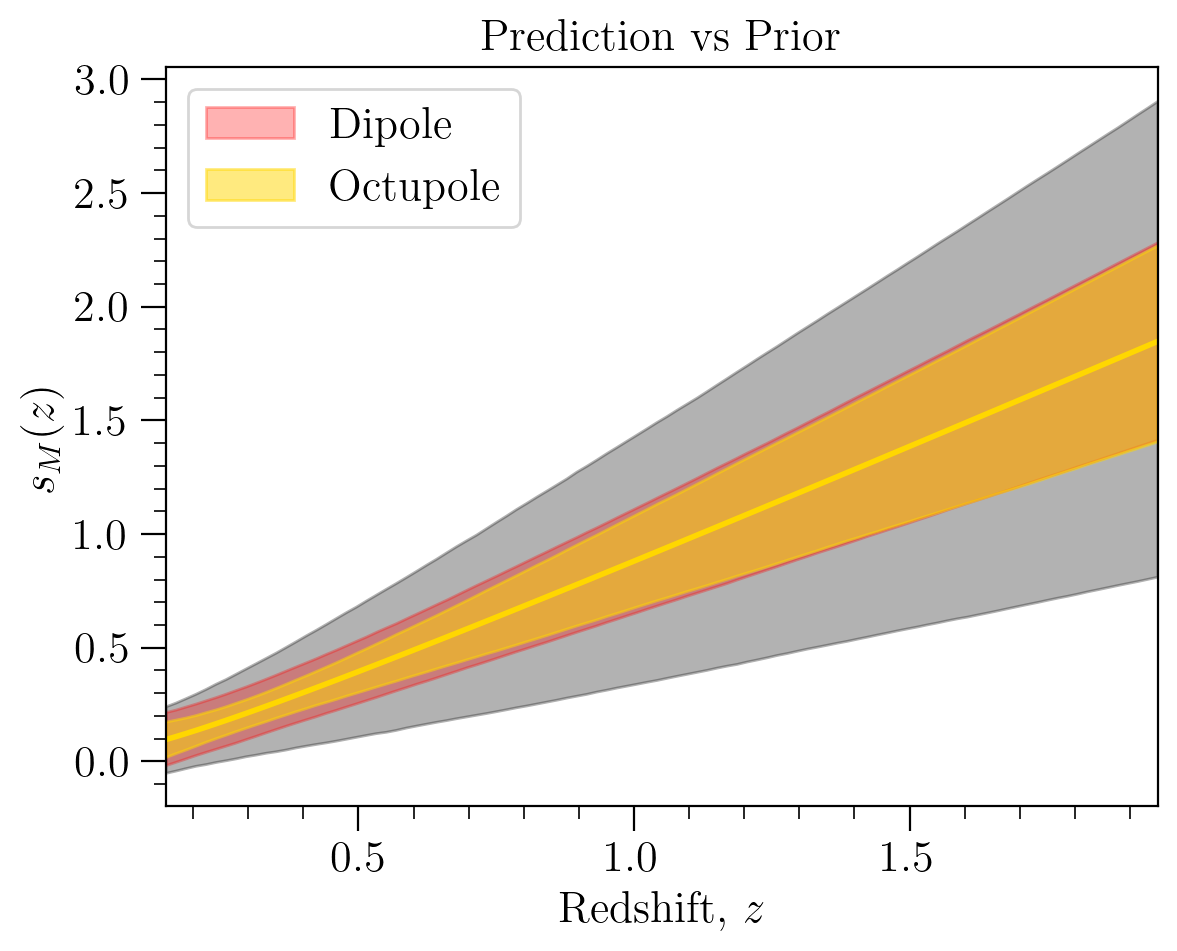

In [72]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='gold')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='red', alpha=0.3, label = 'Dipole')
plt.fill_between(z_lin, sM_lower_bound_ndip, sM_upper_bound_ndip, color='gold', alpha=0.5, label = 'Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.title(r'Prediction vs Prior');
plt.legend(loc = 'upper left');

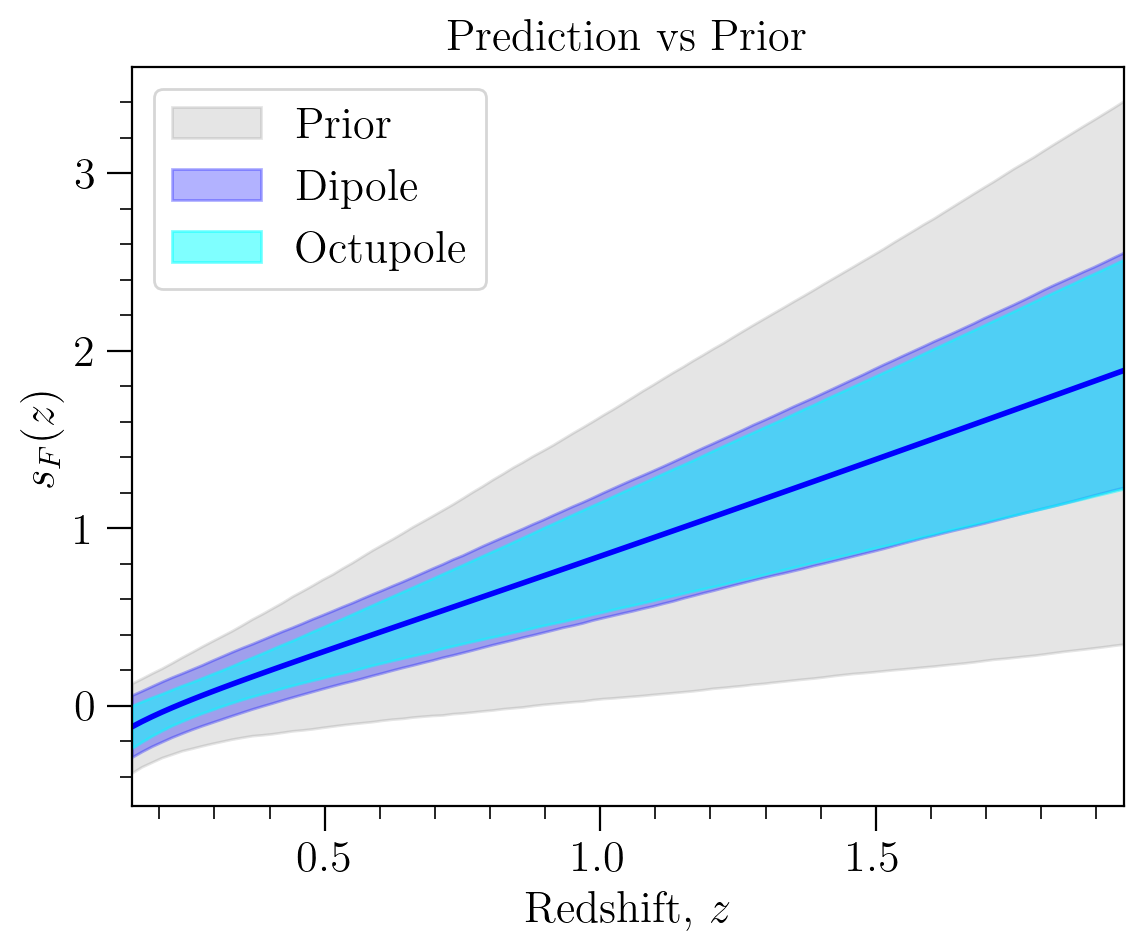

In [73]:
plt.plot(z_lin, sF_fid, '-', lw = 2.0, color='blue')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='black', alpha=0.1, label = 'Prior')
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='blue', alpha=0.3, label = 'Dipole')
plt.fill_between(z_lin, sF_lower_bound_ndip, sF_upper_bound_ndip, color='cyan', alpha=0.5, label = 'Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_F(z)$');
plt.title(r'Prediction vs Prior')
plt.legend(loc='upper left');

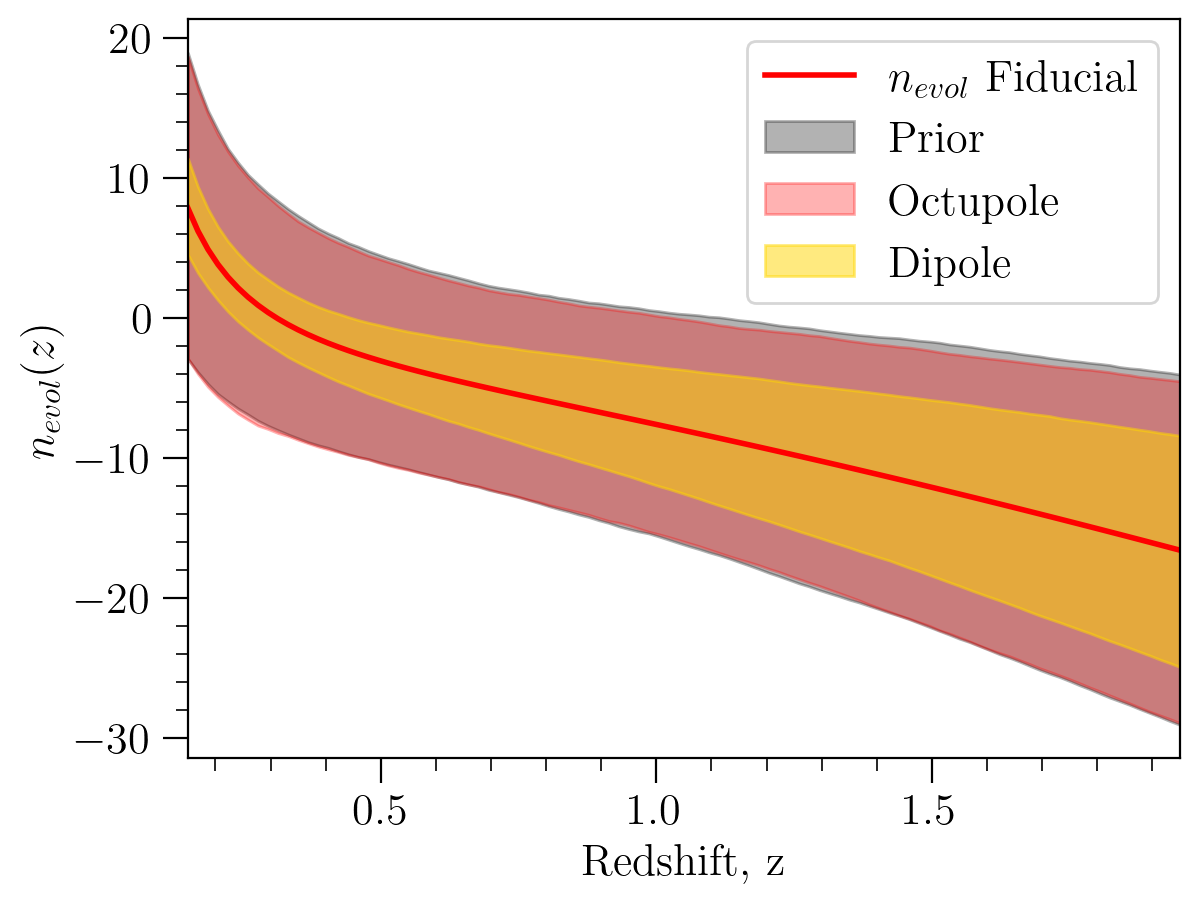

In [74]:
plt.plot(z_lin, num_evol_fid, '-', color='red', label=r'$n_{evol}$'+' Fiducial', lw = 2.0)

# Shade the 68% confidence interval
plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label = 'Prior')
plt.fill_between(z_lin, nevol_lower_bound_ndip, nevol_upper_bound_ndip, color='red', alpha=0.3, label = 'Octupole')
plt.fill_between(z_lin, nevol_lower_bound_noct, nevol_upper_bound_noct, color='gold', alpha=0.5, label = 'Dipole')


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.legend();

## Compare DIPOLE vs OCTUPOLE when REMOVING NEVOL from DIPOLE

In [75]:
index_to_remove = list(range(8,12))

index_to_remove

[8, 9, 10, 11]

In [76]:
Fisher_Dipole_ = np.delete(Fisher_Matrix_noct_19bins, index_to_remove, axis = 0)
Fisher_Dipole_ = np.delete(Fisher_Dipole_, index_to_remove, axis = 1)

np.shape(Fisher_Dipole_)

(17, 17)

In [77]:
Sigma_Matrix_Dipole = np.linalg.inv(Fisher_Dipole_)

In [78]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_Dipole[:8,:8]]))

0.00936068413566578	-0.0010543344431578206	0.004508023740327809	7.327473201170128e-05	0.00034025274117228233	0.0039019437448488676	0.0011259822569059943	-1.8250016481515544e-05
-0.0010543344431580353	0.04806086326868902	-0.0018604208721336825	-0.0013197846681129552	-0.008462431177320128	0.03231626537665976	0.0013149848205849311	2.6030403788275217e-07
0.004508023740327792	-0.0018604208721336934	0.00464124930497668	0.0013317644398305392	-0.0006982031442449228	0.001983335574991535	-5.944075465497052e-05	3.273300750077466e-06
7.32747320117592e-05	-0.0013197846681127954	0.001331764439830582	0.0007469789239736548	-0.00019169531833791652	-0.0004643953669197404	-0.00021131082566294666	3.0751201537232676e-06
0.00034025274117230564	-0.008462431177320335	-0.0006982031442449618	-0.0001916953183378726	0.004009999442675164	-0.008181818822342772	0.0012425899741152246	-5.484610335878708e-06
0.003901943744848674	0.03231626537665983	0.0019833355749915562	-0.00046439536691989094	-0.008181818822342618	0.0

In [79]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_noct_19bins[:8,:8]]))

0.018277050869886978	-0.0037616854101320063	0.002520006780554465	-0.0010157000681363794	0.0010697768471112457	0.0012495035110621532	8.620004884745403e-05	-4.964495742012127e-06
-0.003761685410134337	0.06453650397976772	-0.0006065506799471391	-0.00018864614470998154	-0.0013495238697179173	0.04956097094415578	0.00011570267540167037	2.3706614052541587e-06
0.002520006780554632	-0.0006065506799474331	0.005197954368329066	0.0015110414772819478	-0.00024339503504916806	0.00263086837979224	1.6938228191412612e-06	1.163323477601945e-06
-0.0010157000681367725	-0.00018864614470952783	0.0015110414772820397	0.0010305892987265426	-0.0002547767321238262	0.0013651224425674422	-4.1780304106299526e-05	1.100477570139966e-06
0.001069776847110571	-0.001349523869720532	-0.00024339503504938363	-0.0002547767321239241	0.008639102452317313	-0.0029958125290764416	5.7153068864516804e-05	6.432995630825745e-07
0.0012495035110583156	0.04956097094415728	0.0026308683797927456	0.001365122442566572	-0.002995812529073838	0

In [80]:
print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in Sigma_Matrix_ndip_19bins[:8,:8]]))

0.01809339340528168	-0.008052931678954184	0.002828860229008325	-0.002834134216037907	-0.0005195607717815084	0.00859636785410473	0.0003756120862591372	-4.105162060314199e-06
-0.008052931678954114	0.06998909479300093	0.00010751559740797617	-0.0004918364108451768	-0.004763211064154851	0.04267457244612932	0.0016298693030393778	-9.322941579345529e-06
0.002828860229008383	0.00010751559740785678	0.00512229977015545	0.001613134946061941	-0.00011586732739424947	0.0014940823088698113	-1.0083139634392317e-05	7.797544727983955e-07
-0.0028341342160377804	-0.0004918364108453991	0.00161313494606196	0.0021922495214569925	-0.00015482420591064397	-0.0022481512657543724	4.644647749858595e-05	-7.554374582073242e-07
-0.0005195607717815861	-0.004763211064154911	-0.00011586732739427957	-0.00015482420591063261	0.006640057160441395	-0.012483018372411702	0.0006029567841451283	-3.2399426308670894e-06
0.008596367854105133	0.04267457244612866	0.0014940823088699278	-0.0022481512657543637	-0.012483018372411541	0.058

In [81]:
# Print Fisher ELEMENTS 

import pandas as pd

row_names = {
    0: r"$s_{B,0}$",
    1: r"$s_{B,1}$",
    2: r"$s_{B,2}$",
    3: r"$s_{B,3}$",
    4: r"$s_{M,0}$",
    5: r"$s_{M,1}$",
    6: r"$s_{M,2}$",
    7: r"$s_{M,3}$"
}

sigma_s = {
    "DIPOLE (fix nevol) " : np.sqrt(np.diag(Sigma_Matrix_Dipole[:8,:8]))/np.abs(sbias_fid),
    "DIPOLE" : np.sqrt(np.diag(Sigma_Matrix_noct_19bins[:8,:8]))/np.abs(sbias_fid),
    "OCTUPOLE" : np.sqrt(np.diag(Sigma_Matrix_ndip_19bins[:8,:8]))/np.abs(sbias_fid),
}

df_sigma_s = pd.DataFrame(sigma_s, index=row_names.values())
df_sigma_s = df_sigma_s.apply(pd.Series.round, args=[5])

df_sigma_s

DIPOLE (fix nevol)    DIPOLE  OCTUPOLE
$s_{B,0}$              0.29753  0.41575   0.41366
$s_{B,1}$              0.34032  0.39436   0.41069
$s_{B,2}$              0.42205  0.44664   0.44338
$s_{B,3}$              0.20503  0.24082   0.35124
$s_{M,0}$              0.32682  0.47970   0.42055
$s_{M,1}$              0.15214  0.20878   0.22418
$s_{M,2}$              0.42345  0.49534   0.47487
$s_{M,3}$              0.49896  0.49980   0.49982

In [82]:
latex_string = df_sigma_s.to_latex(index=True, float_format='%.5f')  # Remove index if desired
print(latex_string)

\begin{tabular}{lrrr}
\toprule
 & DIPOLE (fix nevol)  & DIPOLE & OCTUPOLE \\
\midrule
$s_{B,0}$ & 0.29753 & 0.41575 & 0.41366 \\
$s_{B,1}$ & 0.34032 & 0.39436 & 0.41069 \\
$s_{B,2}$ & 0.42205 & 0.44664 & 0.44338 \\
$s_{B,3}$ & 0.20503 & 0.24082 & 0.35124 \\
$s_{M,0}$ & 0.32682 & 0.47970 & 0.42055 \\
$s_{M,1}$ & 0.15214 & 0.20878 & 0.22418 \\
$s_{M,2}$ & 0.42345 & 0.49534 & 0.47487 \\
$s_{M,3}$ & 0.49896 & 0.49980 & 0.49982 \\
\bottomrule
\end{tabular}



In [83]:
index_labels_ = [name for _,name in enumerate(row_names.values())]

index_labels_

['$s_{B,0}$',
 '$s_{B,1}$',
 '$s_{B,2}$',
 '$s_{B,3}$',
 '$s_{M,0}$',
 '$s_{M,1}$',
 '$s_{M,2}$',
 '$s_{M,3}$']

In [84]:
# Select the marginalized covariance matrix for the magnification biases

cov_dipole = Sigma_Matrix_Dipole[:8,:8]

# Generate parameter samples from multivariate normal distribution

num_samples = 5000

sB_pars_samples_dip = np.random.multivariate_normal(sbias_fid, cov_dipole, num_samples)
sM_pars_samples_dip = np.random.multivariate_normal(sbias_fid, cov_dipole, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_dip = np.array([magbias_fit(pars[:4], z_lin) for pars in sB_pars_samples_dip])
sM_samples_dip = np.array([magbias_fit(pars[4:8], z_lin) for pars in sM_pars_samples_dip])

# Calculate the 68% confidence interval
sB_lower_bound_dip = np.percentile(sB_samples_dip, 16, axis=0)
sB_upper_bound_dip = np.percentile(sB_samples_dip, 84, axis=0)
sM_lower_bound_dip = np.percentile(sM_samples_dip, 16, axis=0)
sM_upper_bound_dip = np.percentile(sM_samples_dip, 84, axis=0)

In [85]:
# Compute the sF for each sample
sF_samples_dip = sM_samples_dip*m_split/(m_split-1) - sB_samples_dip/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_dip = np.percentile(sF_samples_dip, 16, axis=0)
sF_upper_bound_dip = np.percentile(sF_samples_dip, 84, axis=0)

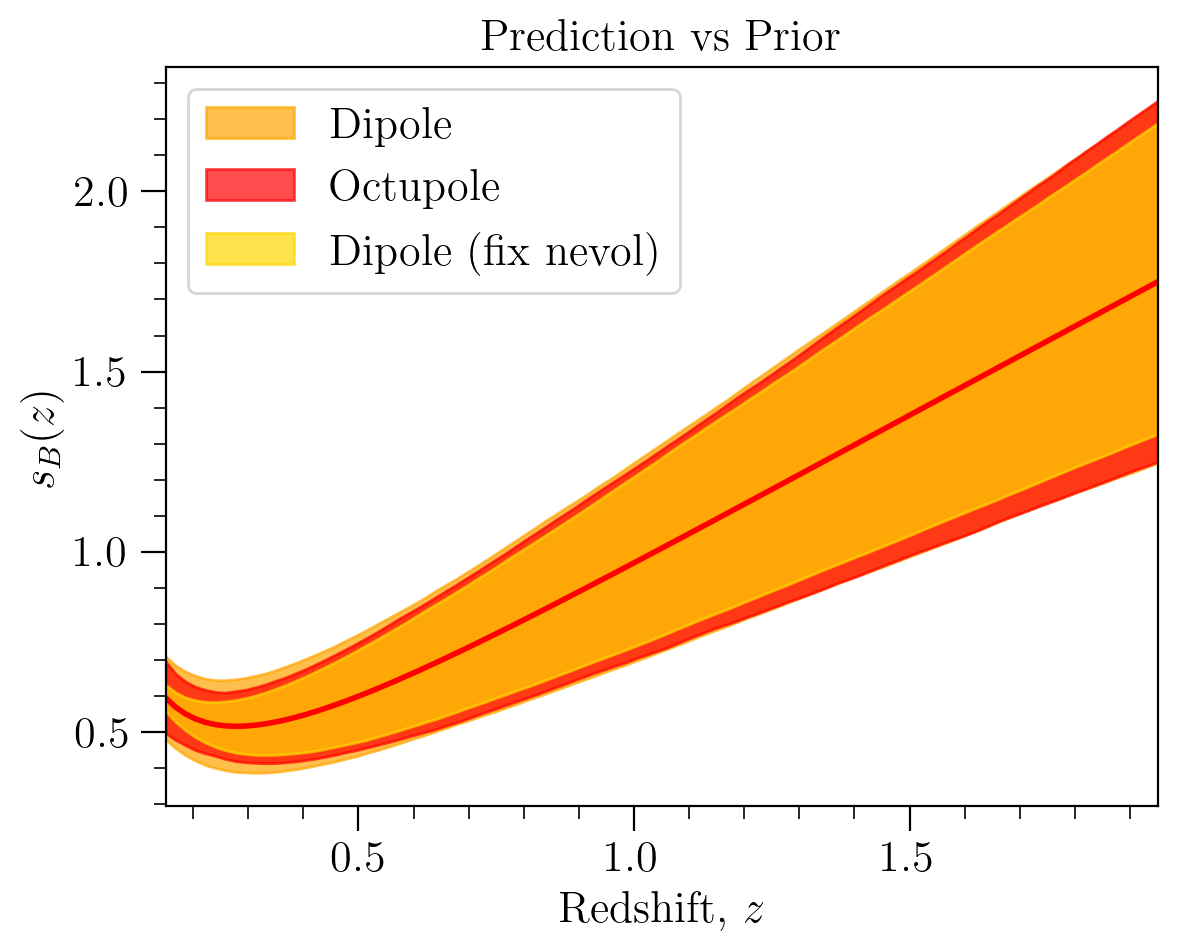

In [86]:
plt.plot(z_lin, sB_fid, '-', lw = 2.0, color='red')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='orange', alpha=0.7, label = 'Dipole')
plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='red', alpha=0.7, label = 'Octupole')
plt.fill_between(z_lin, sB_lower_bound_dip, sB_upper_bound_dip, color='gold', alpha=0.7, label = 'Dipole (fix nevol)')


plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_B(z)$');
plt.title(r'Prediction vs Prior')
plt.legend(loc = 'upper left')

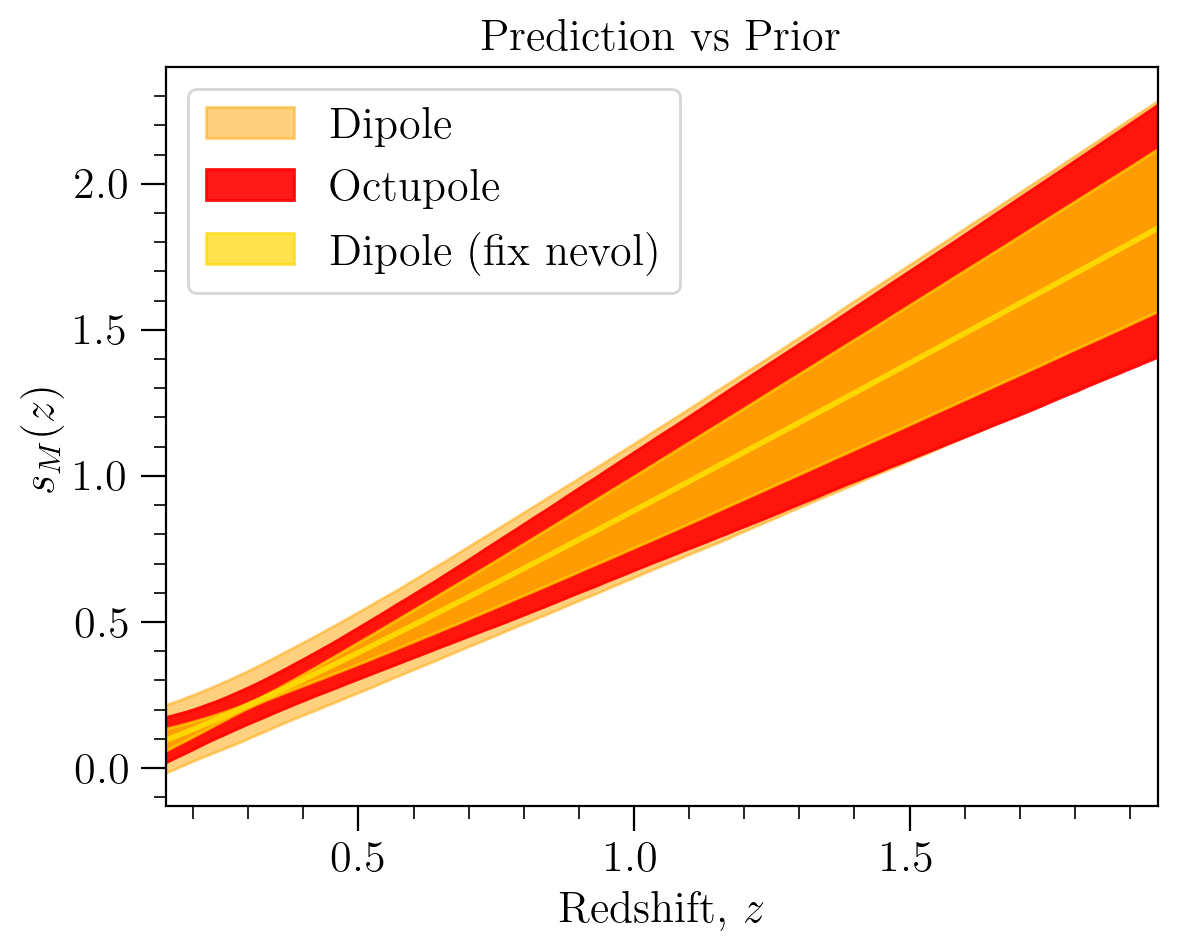

In [87]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='gold')

# Shade the 68% confidence interval
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='orange', alpha=0.5, label = 'Dipole')
plt.fill_between(z_lin, sM_lower_bound_ndip, sM_upper_bound_ndip, color='red', alpha=0.9, label = 'Octupole')
plt.fill_between(z_lin, sM_lower_bound_dip, sM_upper_bound_dip, color='gold', alpha=0.7, label = 'Dipole (fix nevol)')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
plt.title(r'Prediction vs Prior');
plt.legend(loc = 'upper left');

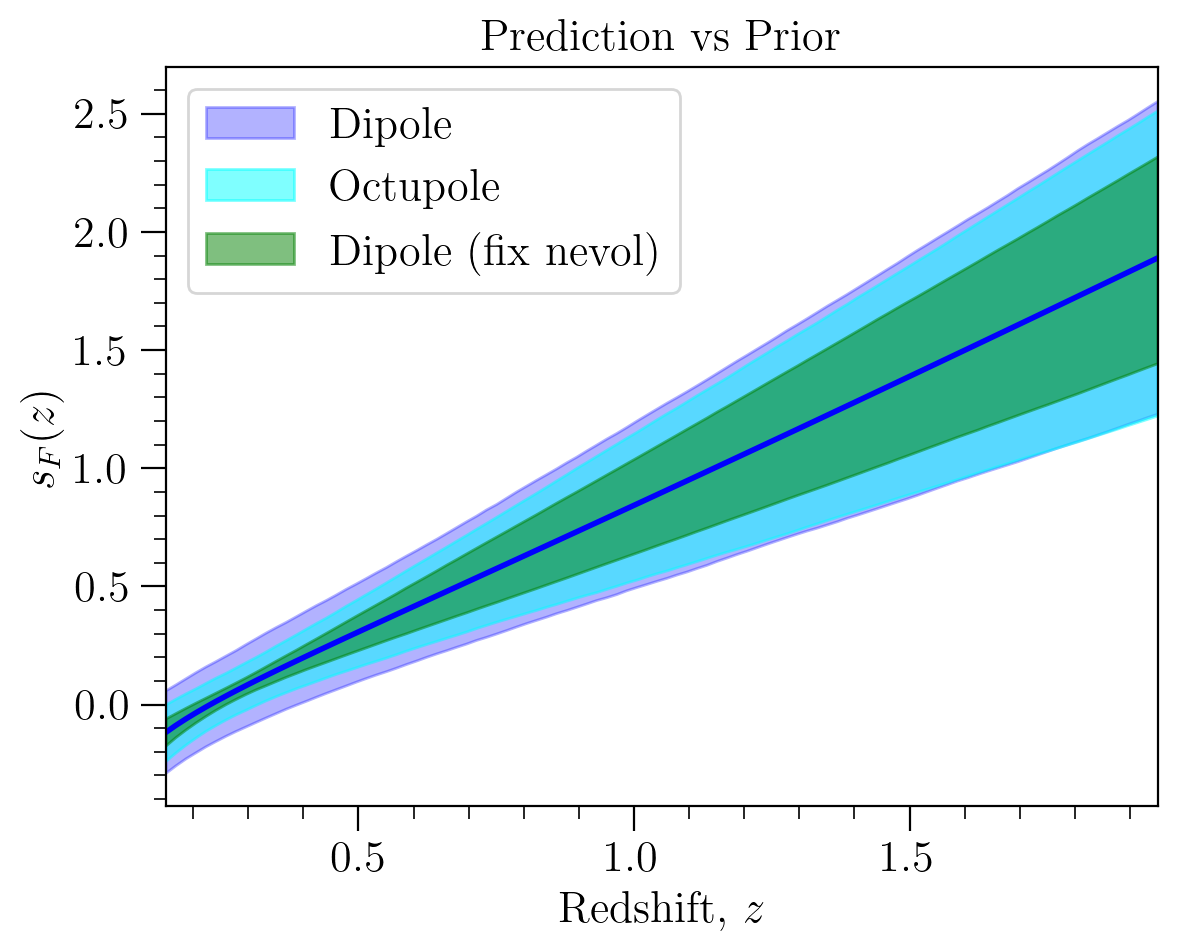

In [88]:
plt.plot(z_lin, sF_fid, '-', lw = 2.0, color='blue')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='blue', alpha=0.3, label = 'Dipole')
plt.fill_between(z_lin, sF_lower_bound_ndip, sF_upper_bound_ndip, color='cyan', alpha=0.5, label = 'Octupole')
plt.fill_between(z_lin, sF_lower_bound_dip, sF_upper_bound_dip, color='green', alpha=0.5, label = 'Dipole (fix nevol)')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_F(z)$');
plt.title(r'Prediction vs Prior')
plt.legend(loc='upper left');

## Include DIPOLE+OCTUPOLE

Include cross-variances (FULL ANALYSIS)

We include the OCTUPOLE AND DIPOLE TOGETHER in the analysis. We include now the cross correlation between the octupole and the other multipoles (it only has non-zero cross-correlations with the dipole).

In [89]:
# Create the Cov Matrix for sB, sF, fevolB, fevolF

errB = [5e-1, 5e-1] 
errF = [5e-1, 5e-1]

sB_4fit = np.array([0.32517608, 0.64417726, 0.16141884, 0.13330365])
sF_4fit = np.array([-0.19376095,  1.0747336,  -0.07806247, -0.00558005])
nevol_fid = np.array([7.94599875, -12.03752387,   2.29927261, -15.83887369])

num_fit = nevol_fid

dsB_19bins = sB_4fit * errB[0] 
dsF_19bins = sF_4fit * errF[0]
dnum_19bins = num_fit * errB[1]

Cov_all_19bins = np.diag(np.concatenate([dsB_19bins**2, dsF_19bins**2, dnum_19bins**2]))

Inv_Cov_oct_all_19bins = np.linalg.inv(Cov_all_19bins)

Inv_Cov_oct_prior_all = np.zeros([len(dsignal_dtheta_fit_all), len(dsignal_dtheta_fit_all)])
Inv_Cov_oct_prior_all[:len(Inv_Cov_oct_all_19bins), :len(Inv_Cov_oct_all_19bins)] = Inv_Cov_oct_all_19bins

Cov_oct_multipoles_19bins = np.array(Cov_multipoles_19bins)

np.shape(Cov_oct_multipoles_19bins)

(19, 324, 324)

In [90]:
# Import full Covariance Matrix

Cov_oct_multipoles_19bins = fm.cov_matrix_survey(d = dist[0], z_bins = z_bins, small_off_diagonal = True, split=[30,70], rtol=1e-4)

np.shape(Cov_oct_multipoles_19bins)


 ... Loading Covariance Matrices [MONOBB, MONOBF, MONOFF, DIPBF, QUADBB, QUADBF, QUADFF, HEXAT, OCTBF] ... 

Population splitted in 30% BRIGHT - 70% FAINT 


 ... Success! ... 



(19, 324, 324)

In [91]:
np.shape(dsignal_dtheta_fit_all)

(21, 19, 324)

In [92]:
# Fisher Matrix

Inv_Cov_oct_multipoles_19bins = np.array([np.linalg.inv(Cov_oct_multipoles_19bins[k]) for k,_ in enumerate(z_bins)])

Fisher_Matrix_oct_multipoles_19bins = fm.fisher_matrix(d_signal = dsignal_dtheta_fit_all, inv_cov = Inv_Cov_oct_multipoles_19bins, z_bins = z_bins)
Fisher_Matrix_oct_all_19bins = Fisher_Matrix_oct_multipoles_19bins + Inv_Cov_oct_prior_all

Sigma_Matrix_oct_all_19bins = np.linalg.inv(Fisher_Matrix_oct_all_19bins)

np.shape(Sigma_Matrix_oct_all_19bins)


 ... Computing the Fisher Matrix ... 

Signal & Cov must be given as functions (z,d) and (z,d,d') respectively. 


 ... Success! ... 



(21, 21)

#### Constraints

In [93]:
#Absolute Errors

Abs_Errors_oct_all_19bins = np.sqrt(np.diag(Sigma_Matrix_oct_all_19bins))

# Fiducial values

sbias_fid = np.concatenate([sB_4fit, sF_4fit])
num_fid = num_fit
gbias_fid = np.concatenate([np.array([0.554, 0.783]), np.array([0.554, 0.783])])
cosmic_fid = np.fromiter(params_dict0.values(), dtype=float)
cosmic_fid[1] = np.log(10**10 * cosmic_fid[1])

params_fid = np.concatenate([sbias_fid, num_fid, gbias_fid, cosmic_fid])

# Relative errors

Rel_Errors_oct_all_19bins = np.abs(Abs_Errors_oct_all_19bins/params_fid)

params_errors_oct_all_19bins = Rel_Errors_oct_all_19bins * 100

print()
print('------------ Relative errors * 100 ------------' )
print()
print('sbias = ', params_errors_oct_all_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])
print()
print('gbias = ', params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))])
print()
print('cosmic = ', params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid)+len(gbias_fid)):])


------------ Relative errors * 100 ------------

sbias =  [32.7709869  35.99519415 43.48386829 21.43123259 37.70664731 18.49161335
 46.45924847 49.95847261]

number =  [40.5013544  28.00600176 24.09305506 29.60954158]

gbias =  [0.5197008  0.43532272 0.15657671 0.26554043]

cosmic =  [1.07737026 0.68903007 0.87014637 1.11097259 0.47934639]


#### Comparing with and without DIPOLE

Compute the improvement in %

In [94]:
print('------------ Relative errors with octupole * 100 ------------' )
print()
print('sbias = ', params_errors_oct_all_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])

------------ Relative errors with octupole * 100 ------------

sbias =  [32.7709869  35.99519415 43.48386829 21.43123259 37.70664731 18.49161335
 46.45924847 49.95847261]

number =  [40.5013544  28.00600176 24.09305506 29.60954158]


In [95]:
print('------------ Relative errors without dipole * 100 ------------' )
print()
print('sbias = ', params_errors_ndip_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_ndip_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])

------------ Relative errors without dipole * 100 ------------

sbias =  [41.36579942 41.06859056 44.33822199 35.12391771 42.05519527 22.41799764
 47.48736627 49.98186376]

number =  [50. 50. 50. 50.]


In [96]:
print('------------ Relative errors without octupole * 100 ------------' )
print()
print('sbias = ', params_errors_noct_19bins[0:len(sbias_fid)])
print()
print('number = ', params_errors_noct_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))])

------------ Relative errors without octupole * 100 ------------

sbias =  [41.57521167 39.4364059  44.66445194 24.08245588 47.96981649 20.87794989
 49.53447705 49.98038228]

number =  [41.31563133 37.20731969 33.77342062 31.39472632]


In [97]:
print('------------ Improvement * 100 vs NO DIPOLE ------------' )
print()
print('sbias = ', (1-params_errors_oct_all_19bins[0:len(sbias_fid)]/params_errors_ndip_19bins[0:len(sbias_fid)]) * 100)
print()
print('number = ', (1-params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]/params_errors_ndip_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]) * 100)

------------ Improvement * 100 vs NO DIPOLE ------------

sbias =  [20.77758108 12.35347096  1.92690113 38.98393462 10.34009695 17.51442903
  2.16503436  0.04679927]

number =  [18.99729121 43.98799649 51.81388987 40.78091685]


In [98]:
print('------------ Improvement * 100 vs NO OCTUPOLE ------------' )
print()
print('sbias = ', (1-params_errors_oct_all_19bins[0:len(sbias_fid)]/params_errors_noct_19bins[0:len(sbias_fid)]) * 100)
print()
print('number = ', (1-params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]/params_errors_noct_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]) * 100)

------------ Improvement * 100 vs NO OCTUPOLE ------------

sbias =  [21.17662042  8.72597709  2.64322879 11.0089407  21.39505616 11.42993707
  6.2082589   0.04383652]

number =  [ 1.97086891 24.72985964 28.66267431  5.68625676]


In [99]:
import pandas as pd

row_names = {
    0: "sB_0",
    1: "sB_1",
    2: "sB_2",
    3: "sB_3",
    4: "sM_0",
    5: "sM_2",
    6: "sM_3",
    7: "sM_4"
}

constraints_s = {
    "OCTUPOLE" : params_errors_ndip_19bins[0:len(sbias_fid)],
    "DIPOLE" : params_errors_noct_19bins[0:len(sbias_fid)],
    "DIP + OCT " : params_errors_oct_all_19bins[0:len(sbias_fid)],
    #"Improvement" : (1-params_errors_oct_all_19bins[0:len(sbias_fid)]/params_errors_ndip_19bins[0:len(sbias_fid)]) * 100
}

df_s = pd.DataFrame(constraints_s, index=row_names.values())
df_s = df_s.apply(pd.Series.round, args=[2])

In [100]:
df_s

OCTUPOLE  DIPOLE  DIP + OCT 
sB_0     41.37   41.58       32.77
sB_1     41.07   39.44       36.00
sB_2     44.34   44.66       43.48
sB_3     35.12   24.08       21.43
sM_0     42.06   47.97       37.71
sM_2     22.42   20.88       18.49
sM_3     47.49   49.53       46.46
sM_4     49.98   49.98       49.96

In [101]:
latex_string = df_s.to_latex(index=True, float_format='%.2f')  # Remove index if desired
print(latex_string)

\begin{tabular}{lrrr}
\toprule
 & OCTUPOLE & DIPOLE & DIP + OCT  \\
\midrule
sB_0 & 41.37 & 41.58 & 32.77 \\
sB_1 & 41.07 & 39.44 & 36.00 \\
sB_2 & 44.34 & 44.66 & 43.48 \\
sB_3 & 35.12 & 24.08 & 21.43 \\
sM_0 & 42.06 & 47.97 & 37.71 \\
sM_2 & 22.42 & 20.88 & 18.49 \\
sM_3 & 47.49 & 49.53 & 46.46 \\
sM_4 & 49.98 & 49.98 & 49.96 \\
\bottomrule
\end{tabular}



In [102]:
row_names = {
    0: "n_0",
    1: "n_1",
    2: "n_2",
    3: "n_3"
}

constraints_num = {
    "Octupole" : params_errors_ndip_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))],
    "Dipole" : params_errors_noct_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))],
    "DIP + OCT" : params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))],
    #"Improvement" : (1-params_errors_oct_all_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]/params_errors_ndip_19bins[len(sbias_fid):(len(sbias_fid) + len(num_fid))]) * 100
}

df_num = pd.DataFrame(constraints_num, index=row_names.values())
df_num = df_num.apply(pd.Series.round, args=[2])

In [103]:
df_num

Octupole  Dipole  DIP + OCT
n_0      50.0   41.32      40.50
n_1      50.0   37.21      28.01
n_2      50.0   33.77      24.09
n_3      50.0   31.39      29.61

In [104]:
latex_string = df_num.to_latex(index=True, float_format='%.2f')  # Remove index if desired
print(latex_string)

\begin{tabular}{lrrr}
\toprule
 & Octupole & Dipole & DIP + OCT \\
\midrule
n_0 & 50.00 & 41.32 & 40.50 \\
n_1 & 50.00 & 37.21 & 28.01 \\
n_2 & 50.00 & 33.77 & 24.09 \\
n_3 & 50.00 & 31.39 & 29.61 \\
\bottomrule
\end{tabular}



In [105]:
# Galaxy bias and Cosmic params

print('------------ Relative errors with octupole * 100 ------------' )
print()
print('gbias = ', params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))])
print()
print('cosmic = ', params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid) + len(gbias_fid)):])

print('\n------------ Relative errors without octupole * 100 ------------' )
print()
print('gbias = ', params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))])
print()
print('cosmic = ', params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid) + len(gbias_fid)):])

print('\n------------ Improvement * 100 ------------' )
print()
print('gbias = ', (1-params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))]/params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid)):(len(sbias_fid) + len(num_fid) + len(gbias_fid))]) * 100)
print()
print('cosmic = ', (1-params_errors_oct_all_19bins[(len(sbias_fid) + len(num_fid) + len(gbias_fid)):]/params_errors_ndip_19bins[(len(sbias_fid) + len(num_fid) + len(gbias_fid)):]) * 100)

------------ Relative errors with octupole * 100 ------------

gbias =  [0.5197008  0.43532272 0.15657671 0.26554043]

cosmic =  [1.07737026 0.68903007 0.87014637 1.11097259 0.47934639]

------------ Relative errors without octupole * 100 ------------

gbias =  [0.52039511 0.43545145 0.15660495 0.26611438]

cosmic =  [1.07784781 0.68979034 0.87050764 1.1111409  0.47990695]

------------ Improvement * 100 ------------

gbias =  [0.13341994 0.02956453 0.01803521 0.21567501]

cosmic =  [0.04430619 0.11021669 0.04150153 0.01514802 0.11680673]


#### Predictions

##### Magnification bias

In [106]:
# Magnification bias fit

def magbias_fit(params, x):
    a, b, c, d = params
    return  a + b * x + c * np.log(x) + d * (np.log(x))**2

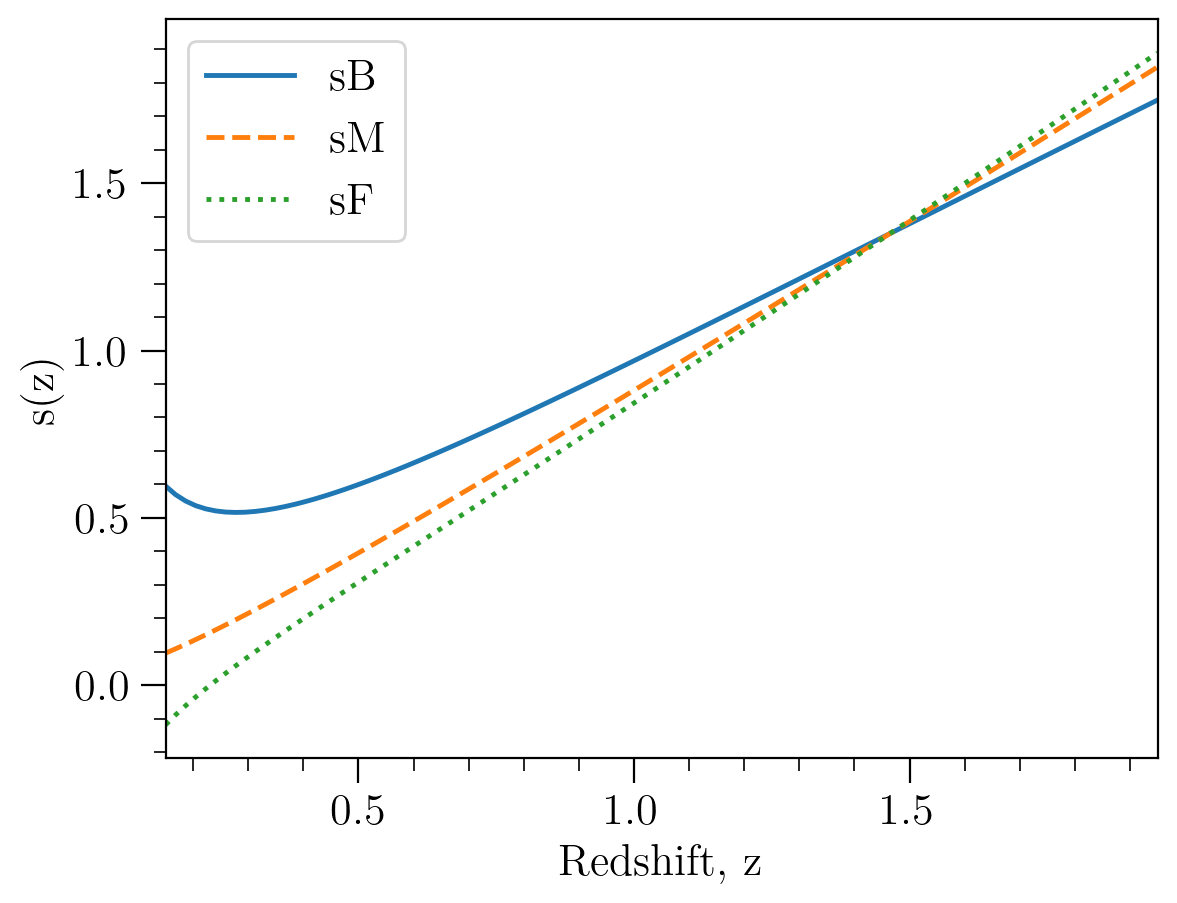

In [107]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 10/3

sB_fid = magbias_fit(sB_4fit, z_lin)
sM_fid = magbias_fit(sF_4fit, z_lin)
sF_fid = sM_fid * (m_split/(m_split-1)) - sB_fid/(m_split-1)

plt.plot(z_lin, sB_fid, '-', label=r'sB')
plt.plot(z_lin, sM_fid, '--', label=r'sM')
plt.plot(z_lin, sF_fid, ':', label=r'sF')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.legend();


###### Compare the two observables

In [108]:
# Select the marginalized covariance matrix for the magnification biases

cov_sB_all = Sigma_Matrix_oct_all_19bins[:4, :4]
cov_sM_all = Sigma_Matrix_oct_all_19bins[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sB_pars_samples_all = np.random.multivariate_normal(sB_4fit, cov_sB_all, num_samples)
sM_pars_samples_all = np.random.multivariate_normal(sF_4fit, cov_sM_all, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_all = np.array([magbias_fit(pars, z_lin) for pars in sB_pars_samples_all])
sM_samples_all = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_all])

# Calculate the 68% confidence interval
sB_lower_bound_all = np.percentile(sB_samples_all, 16, axis=0)
sB_upper_bound_all = np.percentile(sB_samples_all, 84, axis=0)
sM_lower_bound_all = np.percentile(sM_samples_all, 16, axis=0)
sM_upper_bound_all= np.percentile(sM_samples_all, 84, axis=0)

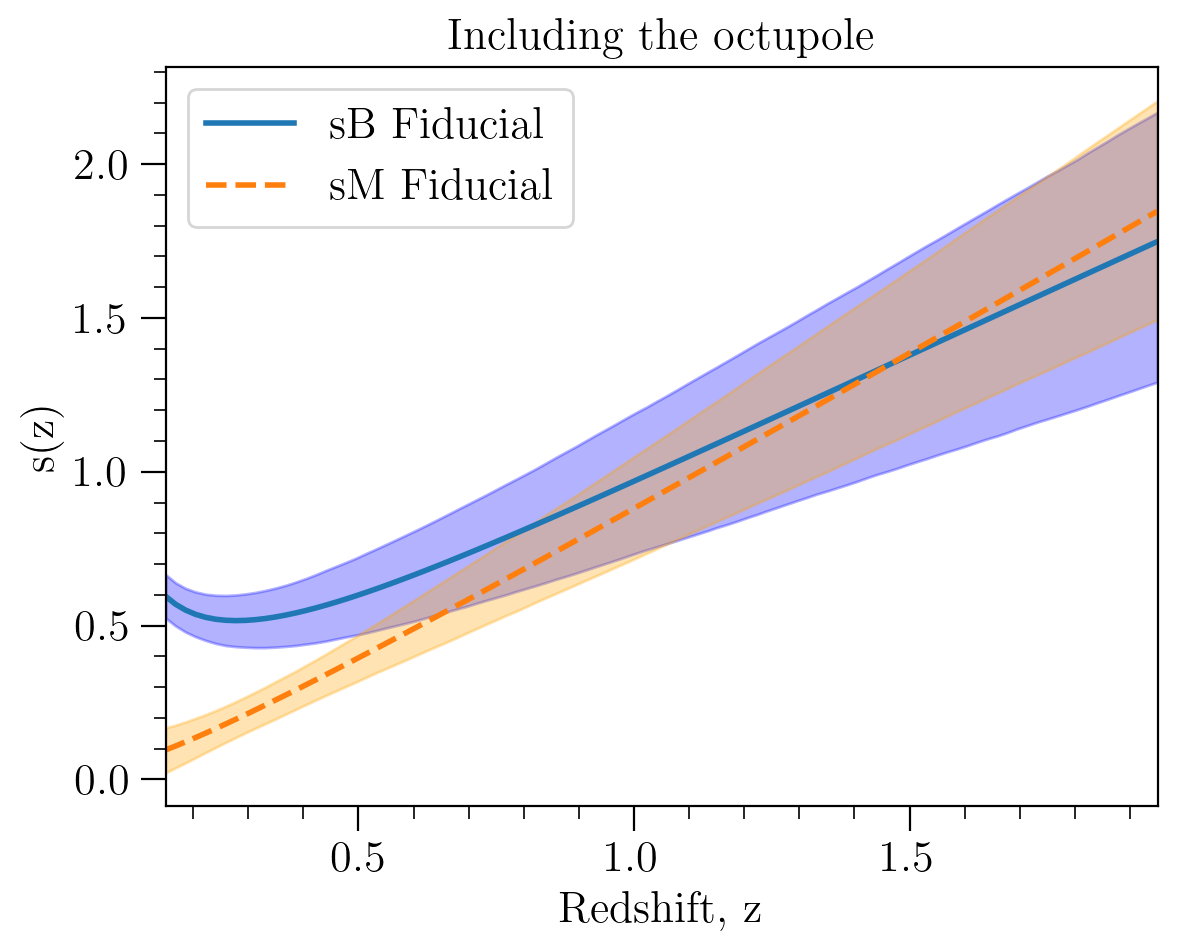

In [109]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0)
plt.plot(z_lin, sM_fid, '--', label=r'sM Fiducial', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='blue', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_all, sM_upper_bound_all, color='orange', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.title('Including the octupole')
plt.legend();

###### Compare with priors

In [110]:
# Select the marginalized covariance matrix for the magnification biases priors

cov_sB_priors = Cov_all_19bins[:4, :4]
cov_sM_priors = Cov_all_19bins[4:8, 4:8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sB_pars_samples_priors = np.random.multivariate_normal(sB_4fit, cov_sB_priors, num_samples)
sM_pars_samples_priors = np.random.multivariate_normal(sF_4fit, cov_sM_priors, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sB_pars_samples_priors])
sM_samples_priors = np.array([magbias_fit(pars, z_lin) for pars in sM_pars_samples_priors])

# Calculate the 68% confidence interval
sB_lower_bound_priors_all = np.percentile(sB_samples_priors, 16, axis=0)
sB_upper_bound_priors_all = np.percentile(sB_samples_priors, 84, axis=0)
sM_lower_bound_priors_all = np.percentile(sM_samples_priors, 16, axis=0)
sM_upper_bound_priors_all = np.percentile(sM_samples_priors, 84, axis=0)

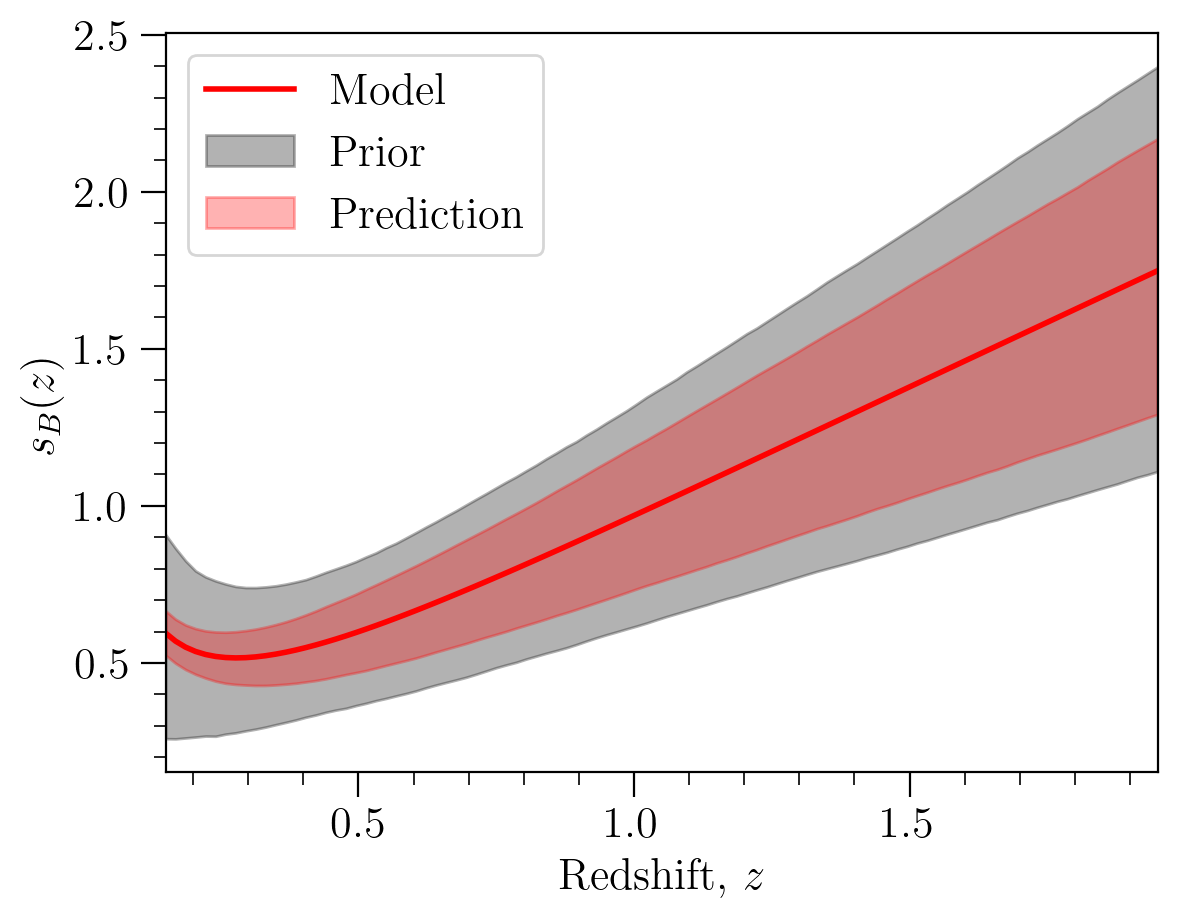

In [111]:
plt.plot(z_lin, sB_fid, '-', lw = 2.0, color='red', label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors_all, sB_upper_bound_priors_all, color='black', alpha=0.3, label='Prior')
plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='red', alpha=0.3, label='Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_B(z)$');
plt.legend(loc='upper left');
#plt.title(r'Prediction vs Prior (with octupole)')

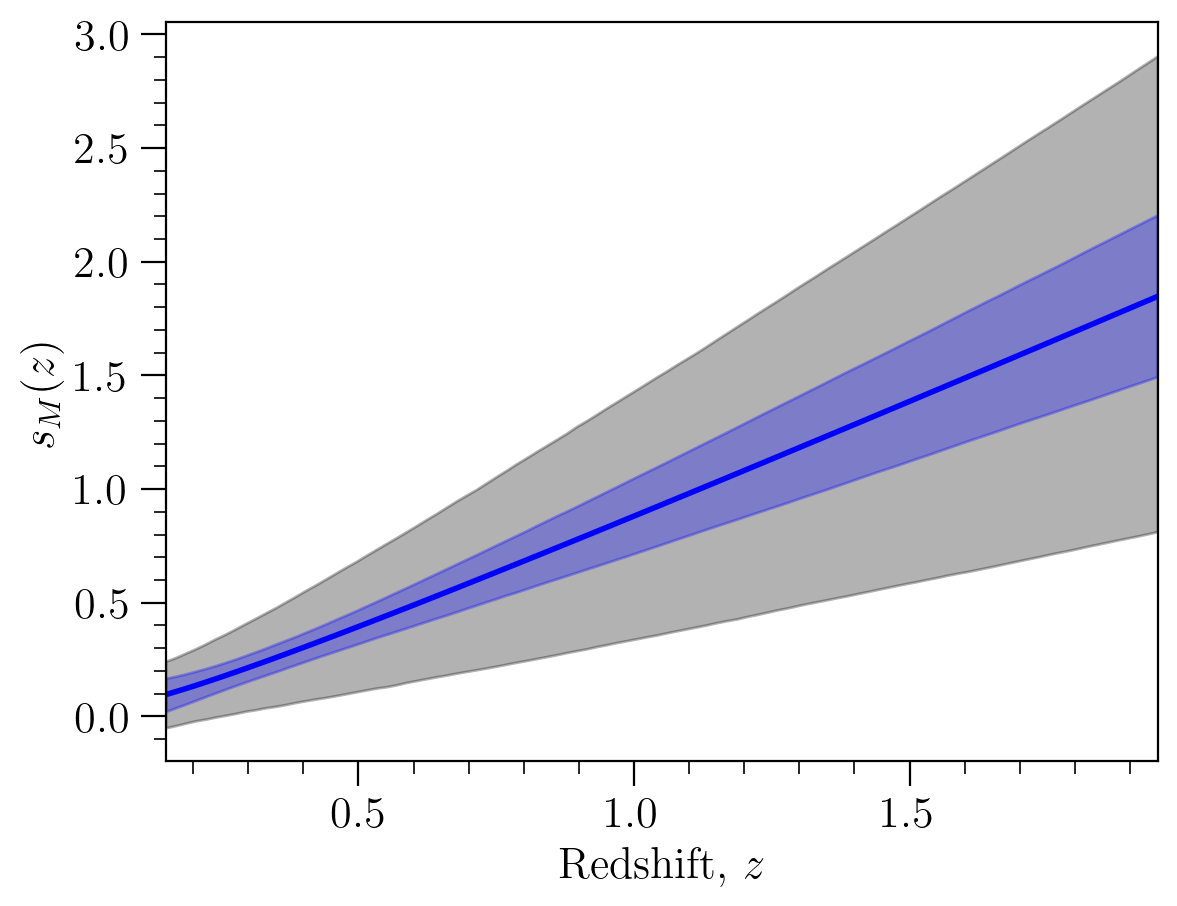

In [112]:
plt.plot(z_lin, sM_fid, '-', lw = 2.0, color='blue', label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.3, label='Prior')
plt.fill_between(z_lin, sM_lower_bound_all, sM_upper_bound_all, color='blue', alpha=0.3, label='Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_M(z)$');
#plt.title(r'Prediction vs Prior (with octupole)')

###### Compare with no-DIPOLE

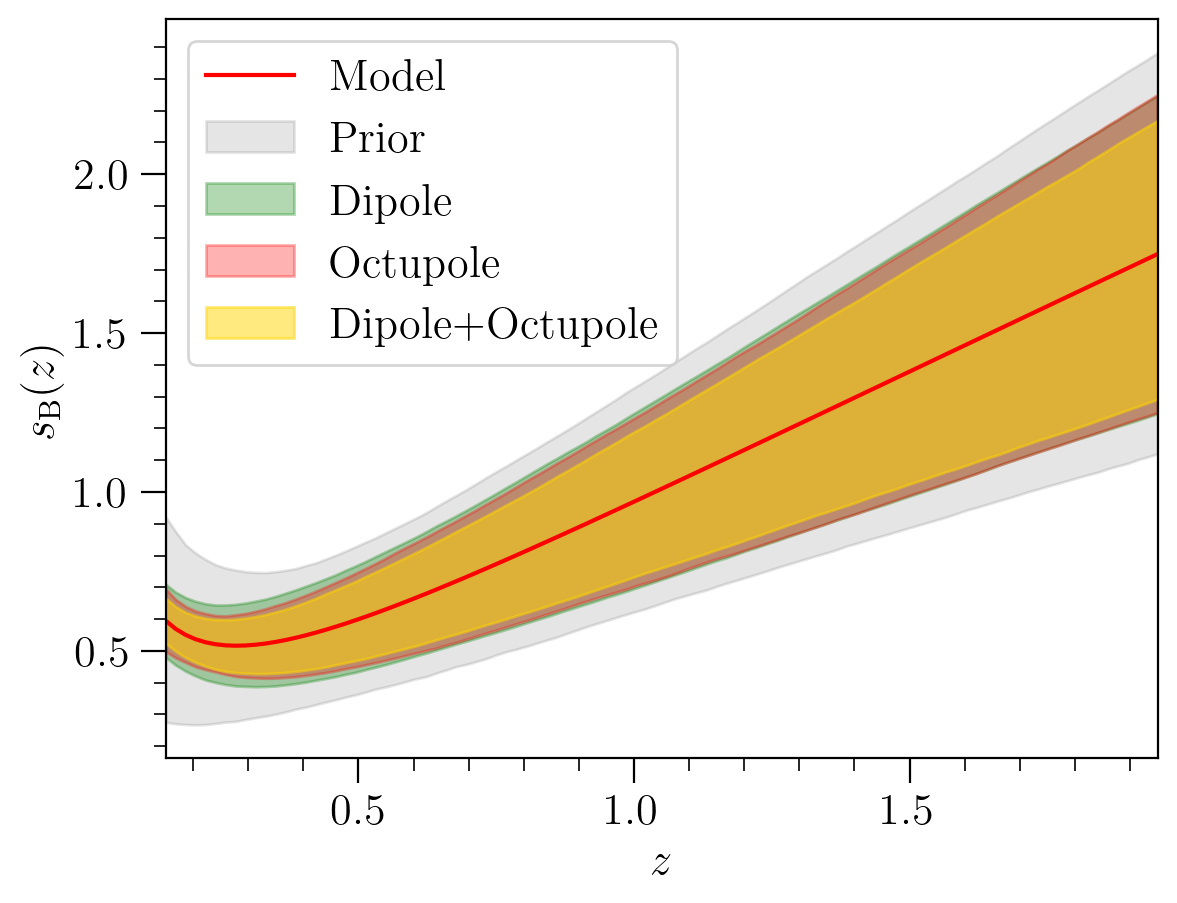

In [113]:
plt.plot(z_lin, sB_fid, '-', lw = 1.5, color='red', label=r'Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='black', alpha=0.1, label=r'Prior')
plt.fill_between(z_lin, sB_lower_bound_noct, sB_upper_bound_noct, color='green', alpha=0.3, label=r'Dipole')
plt.fill_between(z_lin, sB_lower_bound_ndip, sB_upper_bound_ndip, color='red', alpha=0.3, label=r'Octupole')
plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='gold', alpha=0.5, label=r'Dipole+Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'$z$');
plt.ylabel(r'$s_\mathrm{B}(z)$');
#plt.title(r'With and without octupole');
plt.legend(loc='upper left');

#plt.savefig("plots/sB_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

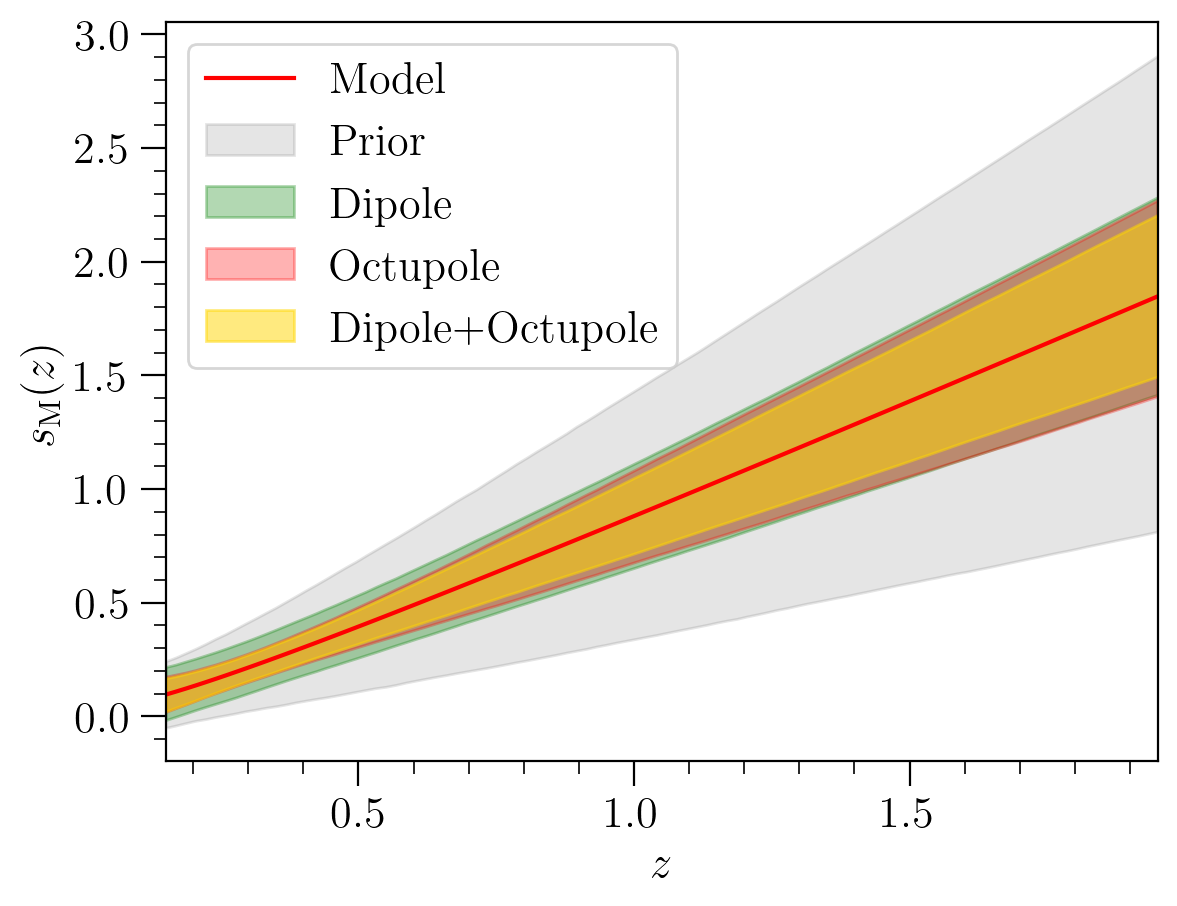

In [114]:
plt.plot(z_lin, sM_fid, '-', lw = 1.5, color='red', label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sM_lower_bound_priors, sM_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, sM_lower_bound_noct, sM_upper_bound_noct, color='green', alpha=0.3, label='Dipole')
plt.fill_between(z_lin, sM_lower_bound_ndip, sM_upper_bound_ndip, color='red', alpha=0.3, label='Octupole')
plt.fill_between(z_lin, sM_lower_bound_all, sM_upper_bound_all, color='gold', alpha=0.5, label='Dipole+Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'$z$');
plt.ylabel(r'$s_\mathrm{M}(z)$');
#plt.title(r'With and without octupole');
plt.legend(loc='upper left')

#plt.savefig("plots/sM_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

###### Magnification bias of the Faint

The magnification bias of the faint population is obtained by:

$$ s_F(z) = s_{model}(z)\frac{\bar{N}(z)}{\bar{N}_F(z)} - s_B(z)\frac{\bar{N}_B(z)}{\bar{N}_F(z)} = s_F(z) = s_{model}(z)\frac{m}{m-1} - s_B(z)\frac{1}{m-1} $$ 

We need to sample together the $s_B$ and $s_m$ parameters.

In [115]:
# Select the marginalized covariance matrix for the magnification biases together
cov_sbias_all = Sigma_Matrix_oct_all_19bins[:8, :8]

# Generate parameter samples from multivariate normal distribution
num_samples = 5000
sbias_pars_samples_all = np.random.multivariate_normal(sbias_fid, cov_sbias_all, num_samples)

# Evaluate fitting function for each parameter sample
sB_samples_all = np.array([magbias_fit(pars[:4], z_lin) for pars in sbias_pars_samples_all])
sM_samples_all = np.array([magbias_fit(pars[4:8], z_lin) for pars in sbias_pars_samples_all])

# Compute the sF for each sample
sF_samples_all = sM_samples_all*m_split/(m_split-1) - sB_samples_all/(m_split-1)

# Calculate the 68% confidence interval
sF_lower_bound_all = np.percentile(sF_samples_all, 16, axis=0)
sF_upper_bound_all = np.percentile(sF_samples_all, 84, axis=0)

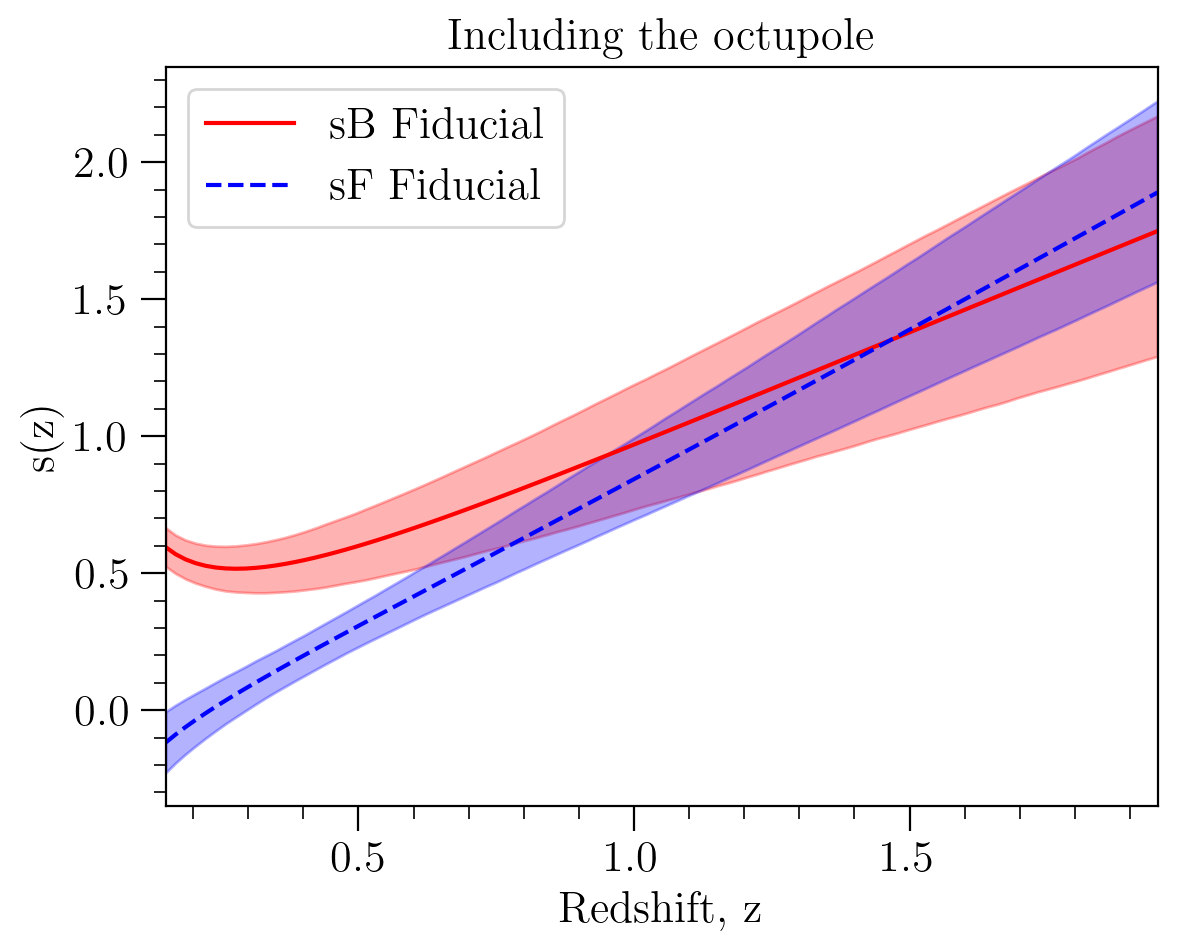

In [116]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 1.5, color='red')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 1.5, color='blue')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='red', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='blue', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.title('Including the octupole')
plt.legend();

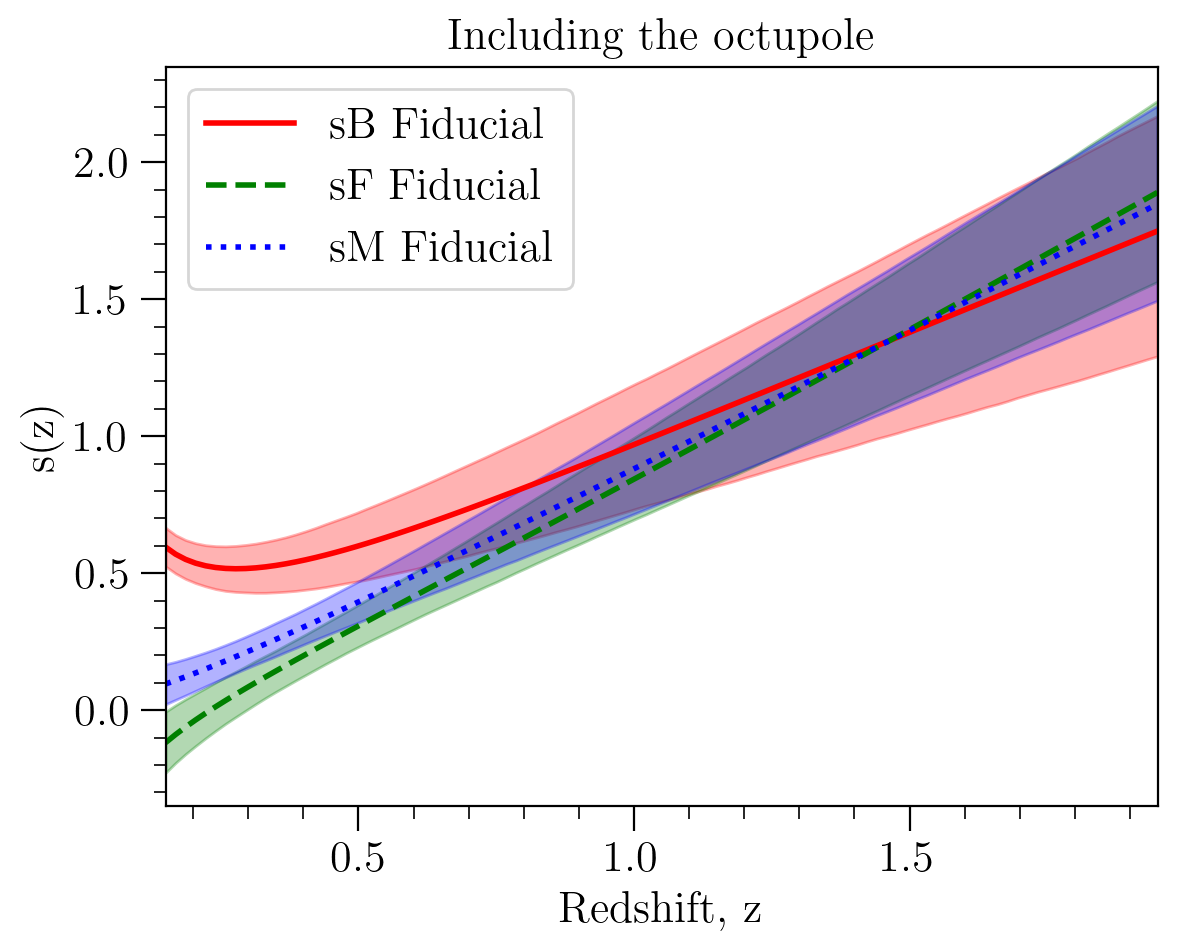

In [117]:
plt.plot(z_lin, sB_fid, '-', label=r'sB Fiducial', lw = 2.0, color='red')
plt.plot(z_lin, sF_fid, '--', label=r'sF Fiducial', lw = 2.0, color='green')
plt.plot(z_lin, sM_fid, ':', label=r'sM Fiducial', lw = 2.0, color='blue')


# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='red', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='green', alpha=0.3)
plt.fill_between(z_lin, sM_lower_bound_all, sM_upper_bound_all, color='blue', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r's(z)')
plt.title('Including the octupole')
plt.legend();

Compare with priors

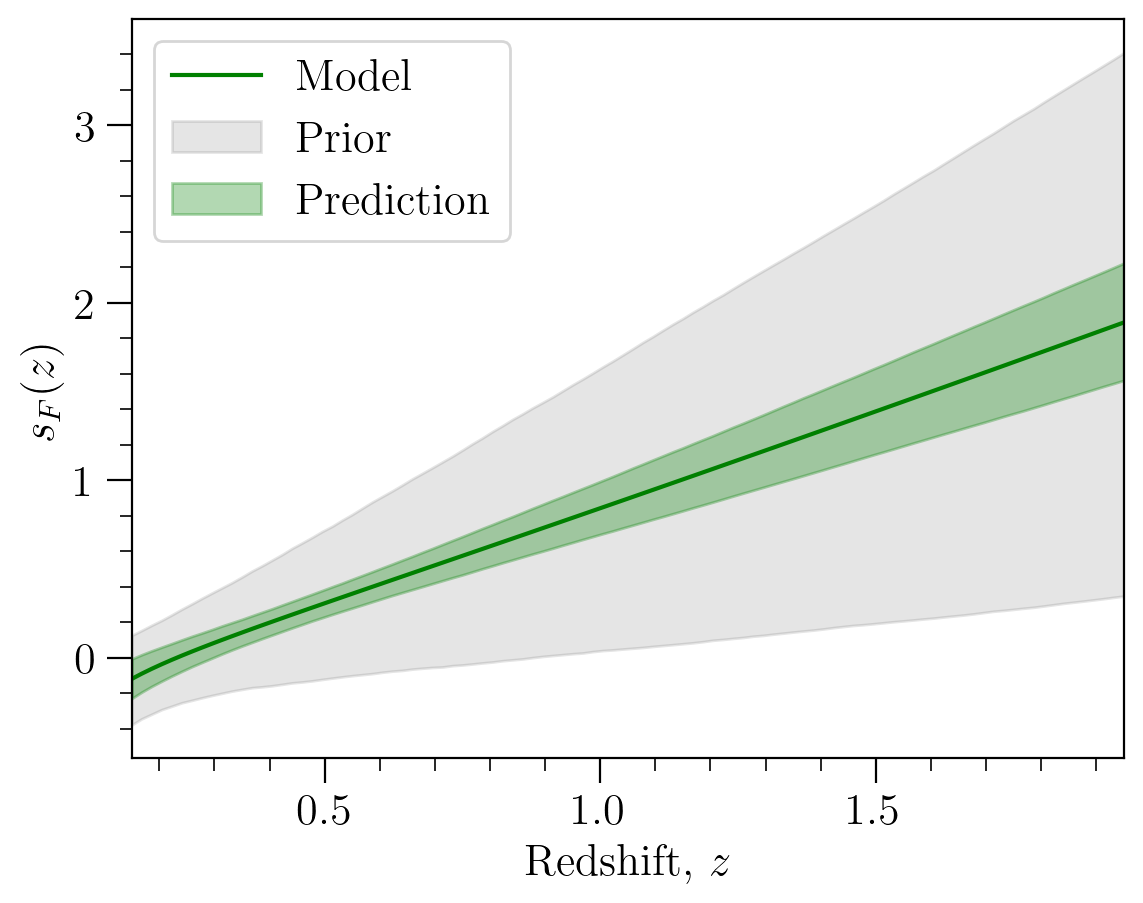

In [118]:
plt.plot(z_lin, sF_fid, '-', lw = 1.5, color='green', label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='green', alpha=0.3, label='Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s_F(z)$');
#plt.title(r'Prediction vs Prior (with octupole)')
plt.legend(loc='upper left')

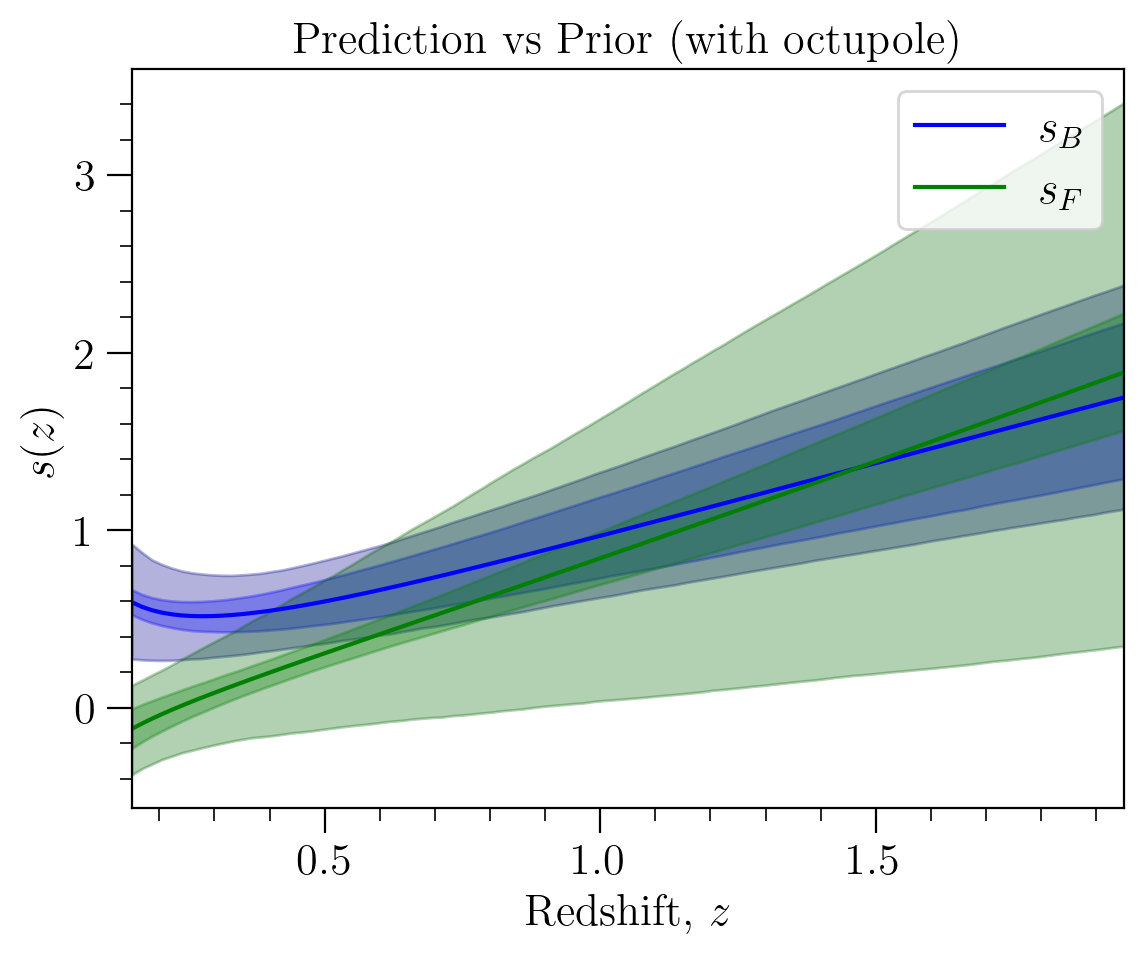

In [119]:
plt.plot(z_lin, sB_fid, '-', lw = 1.5, color='blue', label=r'$s_B$')
plt.plot(z_lin, sF_fid, '-', lw = 1.5, color='green', label=r'$s_F$')


# Shade the 68% confidence interval

plt.fill_between(z_lin, sB_lower_bound_priors, sB_upper_bound_priors, color='darkblue', alpha=0.3)
plt.fill_between(z_lin, sB_lower_bound_all, sB_upper_bound_all, color='blue', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='darkgreen', alpha=0.3)
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='green', alpha=0.3)

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, $z$');
plt.ylabel(r'$s(z)$');
plt.title(r'Prediction vs Prior (with octupole)');
plt.legend();

Compare with no octupole

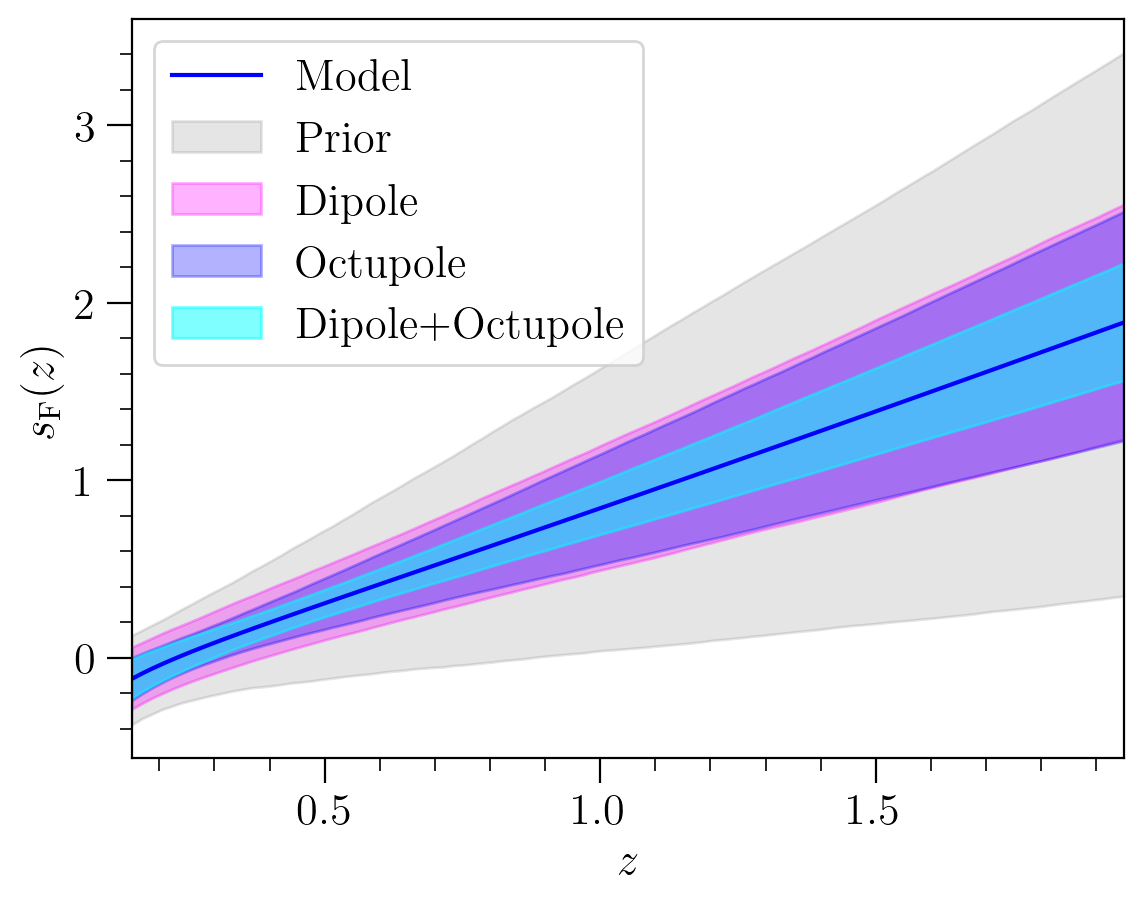

In [120]:
plt.plot(z_lin, sF_fid, '-', lw = 1.5, color='blue', label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, sF_lower_bound_priors, sF_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, sF_lower_bound_noct, sF_upper_bound_noct, color='magenta', alpha=0.3, label='Dipole')
plt.fill_between(z_lin, sF_lower_bound_ndip, sF_upper_bound_ndip, color='blue', alpha=0.3, label='Octupole')
plt.fill_between(z_lin, sF_lower_bound_all, sF_upper_bound_all, color='cyan', alpha=0.5, label='Dipole+Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'$z$');
plt.ylabel(r'$s_\mathrm{F}(z)$');
#plt.title(r'With and without octupole');
plt.legend(loc='upper left');

#plt.savefig("plots/sF_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

##### Number evolution

In [121]:
def nevol_fit(params, x):
    a, b, c, d = params
    return a + b * x + c * (1/x) + d * np.exp(-x)

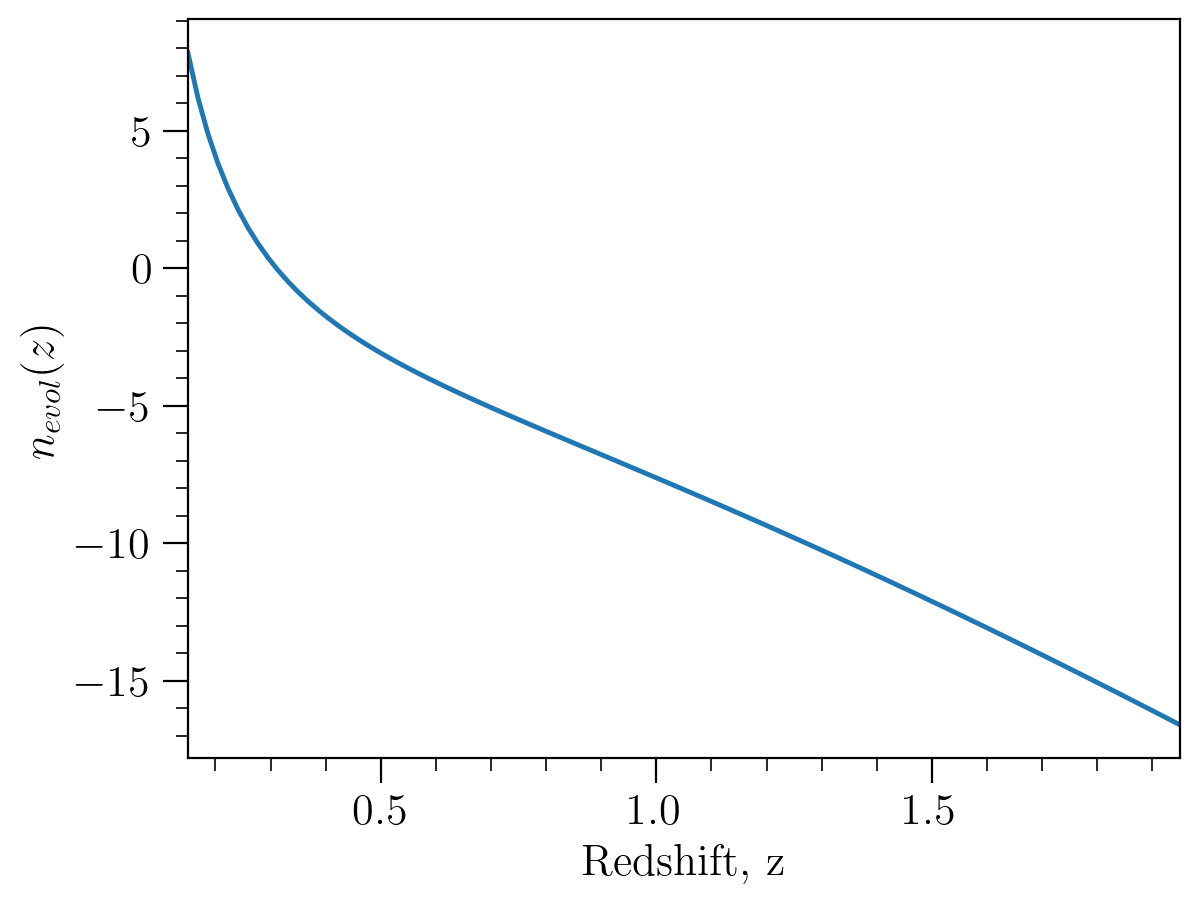

In [122]:
z_lin = np.linspace(z_bins[0], z_bins[-1], 100)
m_split = 10/3

num_evol_fid = nevol_fit(nevol_fid, z_lin)

plt.plot(z_lin, num_evol_fid, '-')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$n_{evol}(z)$');

In [123]:
# Select the marginalized covariance matrix for the number evolution
cov_numevol_all = Sigma_Matrix_oct_all_19bins[8:12, 8:12]
cov_numevol_priors = Cov_all_19bins[8:12, 8:12]


# Generate parameter samples from multivariate normal distribution
num_samples = 5000
nevol_pars_samples_all = np.random.multivariate_normal(nevol_fid, cov_numevol_all, num_samples)
nevol_samples_priors = np.random.multivariate_normal(nevol_fid, cov_numevol_priors, num_samples)


# Evaluate fitting function for each parameter sample
nevol_samples_all = np.array([nevol_fit(pars, z_lin) for pars in nevol_pars_samples_all])
nevol_samples_priors = np.array([nevol_fit(pars, z_lin) for pars in nevol_samples_priors])

# Calculate the 68% confidence interval
nevol_lower_bound_all = np.percentile(nevol_samples_all, 16, axis=0)
nevol_upper_bound_all = np.percentile(nevol_samples_all, 84, axis=0)
nevol_lower_bound_priors = np.percentile(nevol_samples_priors, 16, axis=0)
nevol_upper_bound_priors = np.percentile(nevol_samples_priors, 84, axis=0)

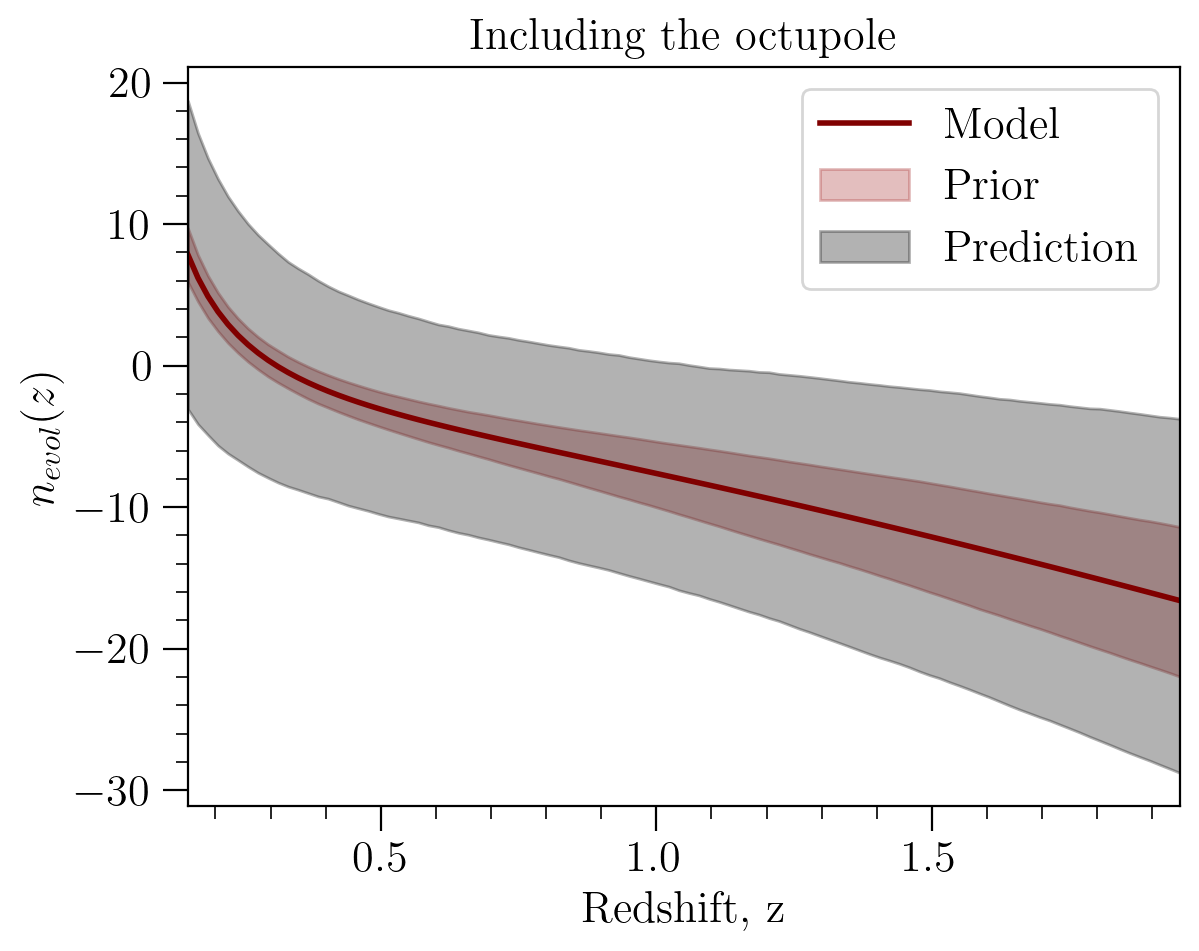

In [124]:
plt.plot(z_lin, num_evol_fid, '-', color='maroon', label=r'Model', lw = 2.0)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_lower_bound_all, nevol_upper_bound_all, color='brown', alpha=0.3, label=r'Prior')
plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.3, label=r'Prediction')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$n_{evol}(z)$')
plt.title('Including the octupole')
plt.legend();

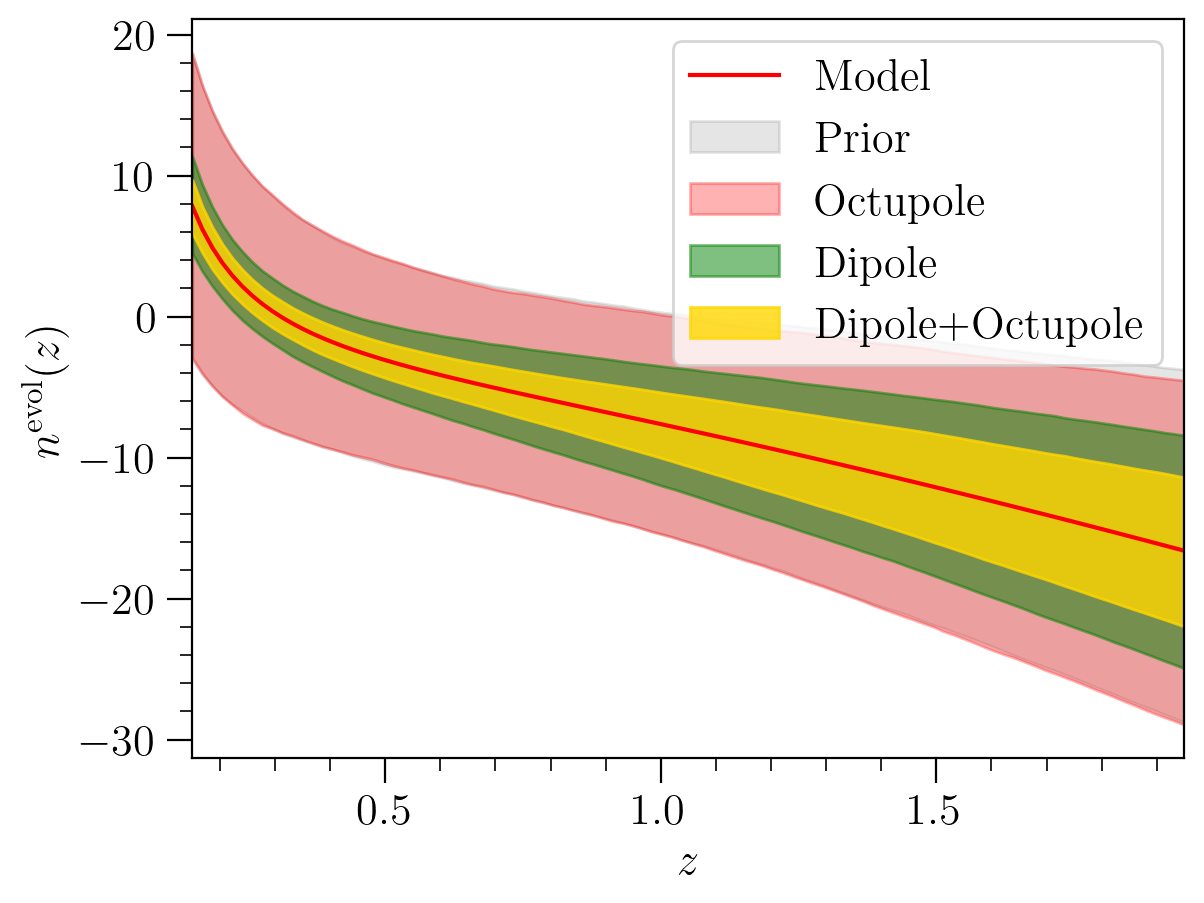

In [125]:
plt.plot(z_lin, num_evol_fid, '-', color='red', label=r'Model', lw = 1.5)

# Shade the 68% confidence interval

plt.fill_between(z_lin, nevol_lower_bound_priors, nevol_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, nevol_lower_bound_ndip, nevol_upper_bound_ndip, color='red', alpha=0.3, label='Octupole')
plt.fill_between(z_lin, nevol_lower_bound_noct, nevol_upper_bound_noct, color='green', alpha=0.5, label='Dipole')
plt.fill_between(z_lin, nevol_lower_bound_all, nevol_upper_bound_all, color='gold', alpha=0.8, label='Dipole+Octupole')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'$z$')
plt.ylabel(r'$n^\mathrm{evol}(z)$')
#plt.title('With and without octupole')
plt.legend();

#plt.savefig("plots/nevol_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

##### Evolution bias

The evolution bias is computed from the magnification biases and the evolution of the number densities.

$$ f^{evol}_{B}(z) = -\frac{d\log{N_B(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_B(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) - \frac{5}{2}s_B(z)\,\frac{d\log{F_c}}{d\log{(1+z)}} $$

$$ f^{evol}_{F}(z) = -\frac{d\log{N_F(z)}}{d\log{(1+z)}} - \frac{d\log{H(z)}}{d\log{(1+z)}} + \frac{2(1+z)}{r(z)H(z)} -5\,s_F(z)\left(1+\frac{(1+z)}{r(z)H(z)}\right) 
    - \frac{5}{2}\left[\frac{\bar{N}}{\bar{N}_F}\,s_{model}(z)\frac{d\log{F_*}}{d\log{(1+z)}}-\frac{\bar{N}_B}{\bar{N}_F}\,s_B(z)\frac{d\log{F_c}}{d\log{(1+z)}}\right] $$

We have all the ingredients defined as methods in the EvolutionBias class. We need to extract the relevant terms and then sample togeter the $n_{evol}$ and magnification bias parameters to construct the predictions for each evolution bias. 

In [126]:
m_split = 10/3

myEvolBias = EvolutionBias(n_split=m_split)

dlogH = myEvolBias.dlogH
rHterm = myEvolBias.rHterm
dFstar = myEvolBias.dLogFstar
dFcut = myEvolBias.dLogFcut

In [127]:
def fevol_bright(pars_s, pars_n, z):
    pars_sB = pars_s[:4] 
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*magbias_fit(params=pars_sB, x=z))*rHterm(z) - 5*magbias_fit(params=pars_sB, x=z) - 5/2*magbias_fit(params=pars_sB, x=z)*dFcut(z)
    
def fevol_faint(pars_s, pars_n, z):
    
    pars_sB = pars_s[:4]
    pars_sM = pars_s[4:]
    s_B = magbias_fit(params=pars_sB, x=z)
    s_M = magbias_fit(params=pars_sM, x=z)
    s_faint = s_M*m_split/(m_split-1) - s_B/(m_split-1)
    
    return - nevol_fit(params=pars_n, x=z) - dlogH(z) + (2 - 5*s_faint)*rHterm(z) - 5*s_faint + 5/2*((1/(m_split-1)) * s_B *dFcut(z) - (m_split/(m_split-1)) * s_M *dFstar(z))

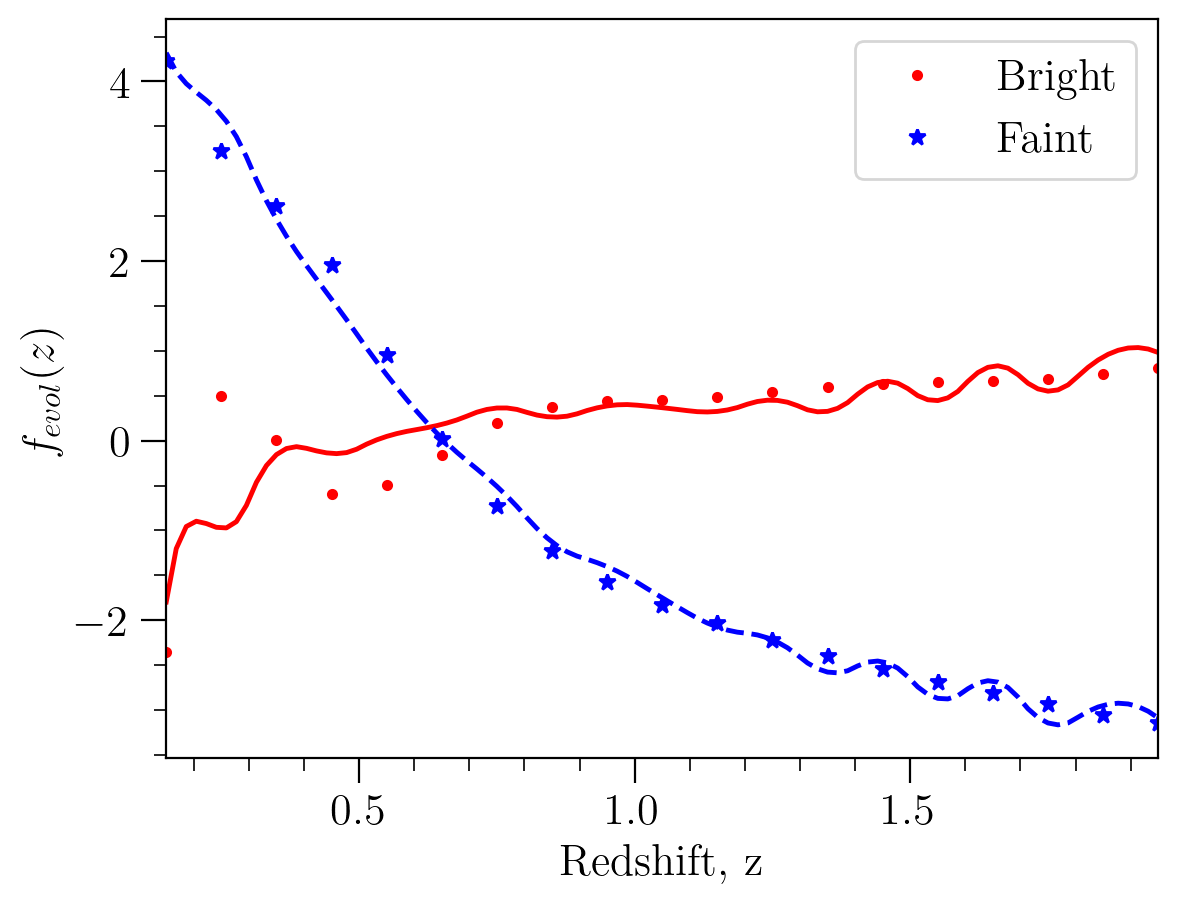

In [128]:
from scipy.interpolate import interp1d

z_lin = np.linspace(z_bins[0], z_bins[-1], 100)

fevol_B_fid = fevol_bright(pars_s = sbias_fid, pars_n = nevol_fid, z = z_lin)
fevol_F_fid = fevol_faint(pars_s = sbias_fid, pars_n = nevol_fid, z = z_lin)

plt.plot(z_lin, fevol_B_fid, 'r-')
plt.plot(z_lin, fevol_F_fid, 'b--')

feB_ = myEvolBias.fevol_bright(z_lin)
feF_ = myEvolBias.fevol_faint(z_lin)

feBi = interp1d(z_lin, feB_, kind='cubic', fill_value='extrapolate')
feFi = interp1d(z_lin, feF_, kind='cubic', fill_value='extrapolate')

feB = feBi(z_bins)
feF = feFi(z_bins)

plt.plot(z_bins, feB, 'r.', label='Bright')
plt.plot(z_bins, feF, 'b*', label='Faint')

plt.xlim(z_bins[0],z_bins[-1])

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$f_{evol}(z)$');
plt.legend();

In [129]:
# Select the marginalized covariance matrix for the number evolution

cov_all_all = Sigma_Matrix_oct_all_19bins[:12, :12]
cov_all_priors = Cov_all_19bins[:12, :12]

all_fid = np.concatenate([sbias_fid, nevol_fid])

# Generate parameter samples from multivariate normal distribution

num_samples = 5000
all_pars_samples_all = np.random.multivariate_normal(all_fid, cov_all_all, num_samples)
all_pars_samples_priors = np.random.multivariate_normal(all_fid, cov_all_priors, num_samples)

# Evaluate fitting function for each parameter sample

fevol_B_samples_all = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_all])
fevol_B_samples_priors = np.array([fevol_bright(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_priors])
fevol_F_samples_all = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_all])
fevol_F_samples_priors = np.array([fevol_faint(pars_s = pars[:8], pars_n = pars[8:12], z = z_lin) for pars in all_pars_samples_priors])

# Calculate the 68% confidence intervals

fevol_B_lower_bound_all = np.percentile(fevol_B_samples_all, 16, axis=0)
fevol_B_upper_bound_all = np.percentile(fevol_B_samples_all, 84, axis=0)
fevol_B_lower_bound_priors = np.percentile(fevol_B_samples_priors, 16, axis=0)
fevol_B_upper_bound_priors = np.percentile(fevol_B_samples_priors, 84, axis=0)

fevol_F_lower_bound_all = np.percentile(fevol_F_samples_all, 16, axis=0)
fevol_F_upper_bound_all = np.percentile(fevol_F_samples_all, 84, axis=0)
fevol_F_lower_bound_priors = np.percentile(fevol_F_samples_priors, 16, axis=0)
fevol_F_upper_bound_priors = np.percentile(fevol_F_samples_priors, 84, axis=0)

Text(0.5, 1.0, 'Including the octupole')

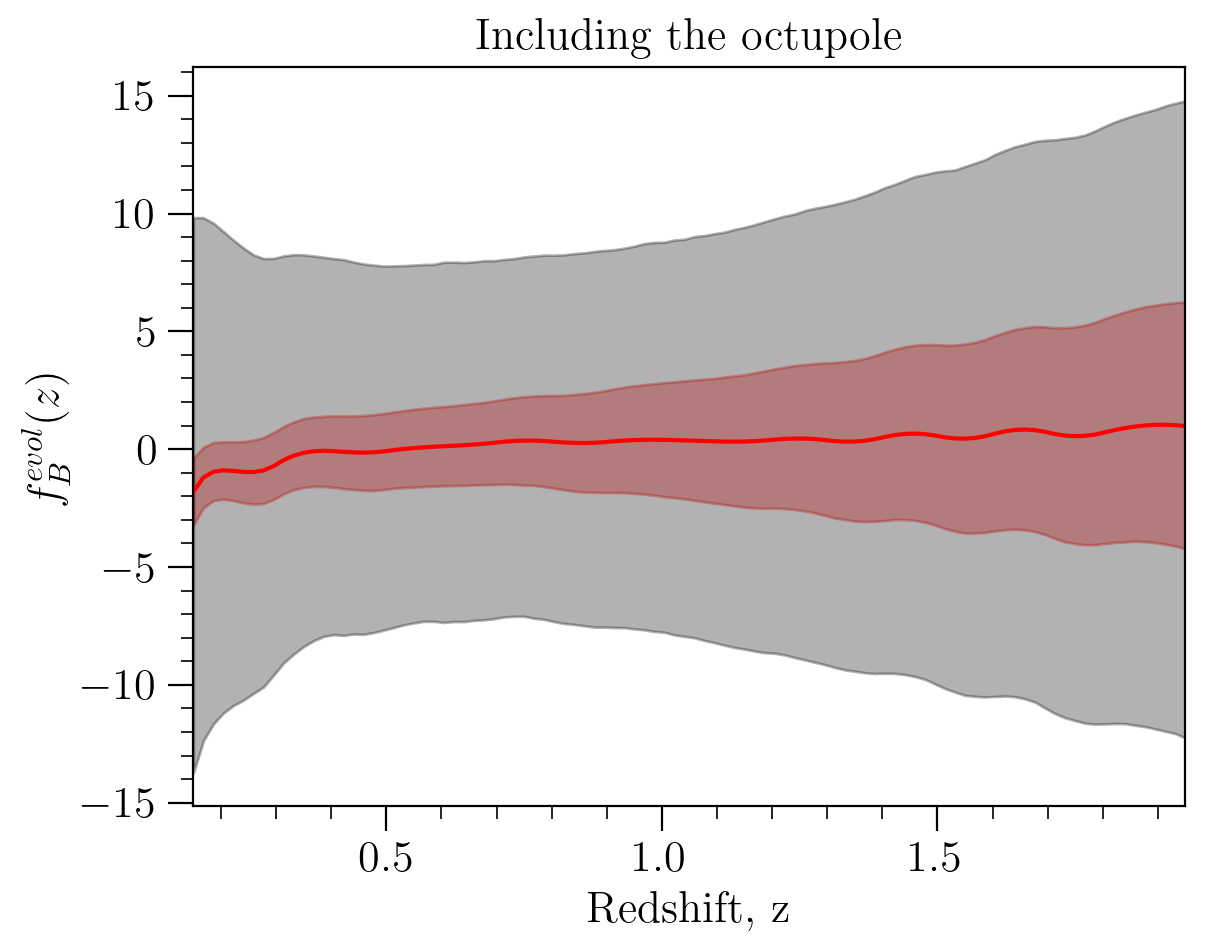

In [130]:
plt.plot(z_lin, fevol_B_fid, '-', color='red', lw = 1.5)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_B_lower_bound_all, fevol_B_upper_bound_all, color='red', alpha=0.3)
plt.fill_between(z_lin, fevol_B_lower_bound_priors, fevol_B_upper_bound_priors, color='black', alpha=0.3)


plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z')
plt.ylabel(r'$f^{evol}_B(z)$')
plt.title('Including the octupole')

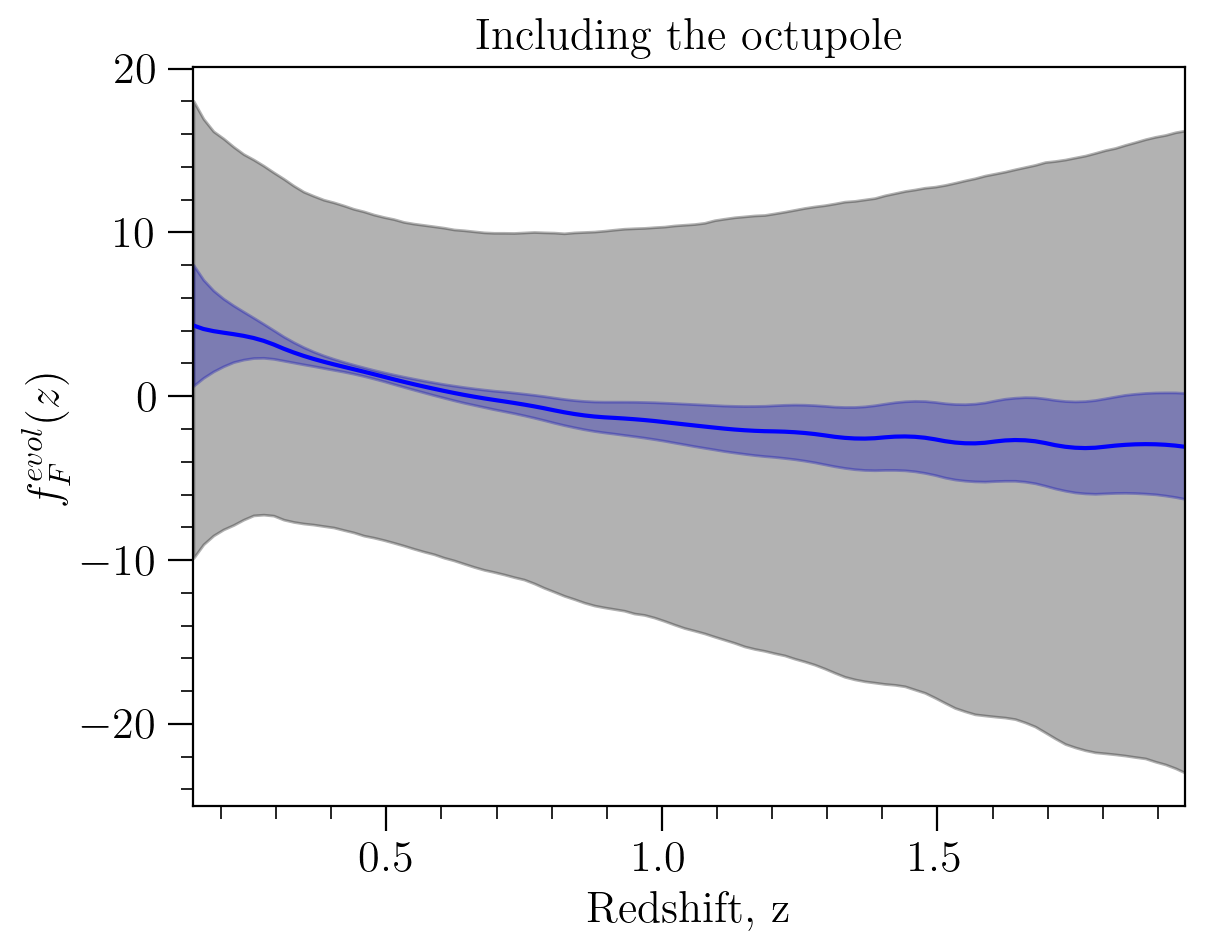

In [131]:
plt.plot(z_lin, fevol_F_fid, '-', color='blue', lw = 1.5)

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_F_lower_bound_all, fevol_F_upper_bound_all, color='blue', alpha=0.3)
plt.fill_between(z_lin, fevol_F_lower_bound_priors, fevol_F_upper_bound_priors, color='black', alpha=0.3)

plt.xlim(0.15,1.95)

plt.xlabel(r'Redshift, z');
plt.ylabel(r'$f^{evol}_F(z)$');
plt.title('Including the octupole');

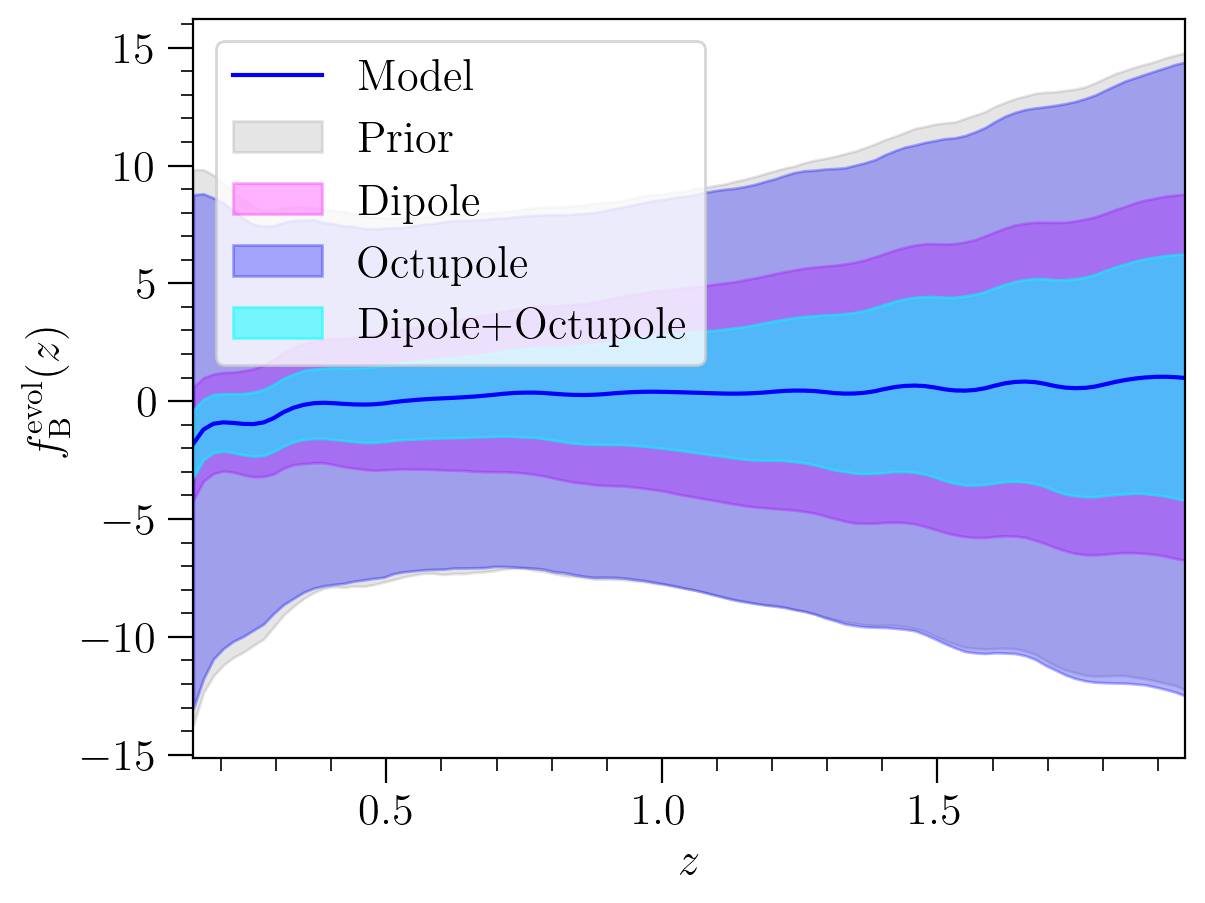

In [132]:
plt.plot(z_lin, fevol_B_fid, '-', color='blue', lw = 1.5, label = 'Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_B_lower_bound_priors, fevol_B_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, fevol_B_lower_bound_noct, fevol_B_upper_bound_noct, color='magenta', alpha=0.3, label='Dipole')
plt.fill_between(z_lin, fevol_B_lower_bound_ndip, fevol_B_upper_bound_ndip, color='blue', alpha=0.3, label='Octupole')
plt.fill_between(z_lin, fevol_B_lower_bound_all, fevol_B_upper_bound_all, color='cyan', alpha=0.5, label='Dipole+Octupole')

plt.xlim(0.15,1.95)

plt.xlabel(r'$z$')
plt.ylabel(r'$f^\mathrm{evol}_\mathrm{B}(z)$')
#plt.title('With and without the octupole');
plt.legend(loc='upper left')

#plt.savefig("plots/fevolB_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')

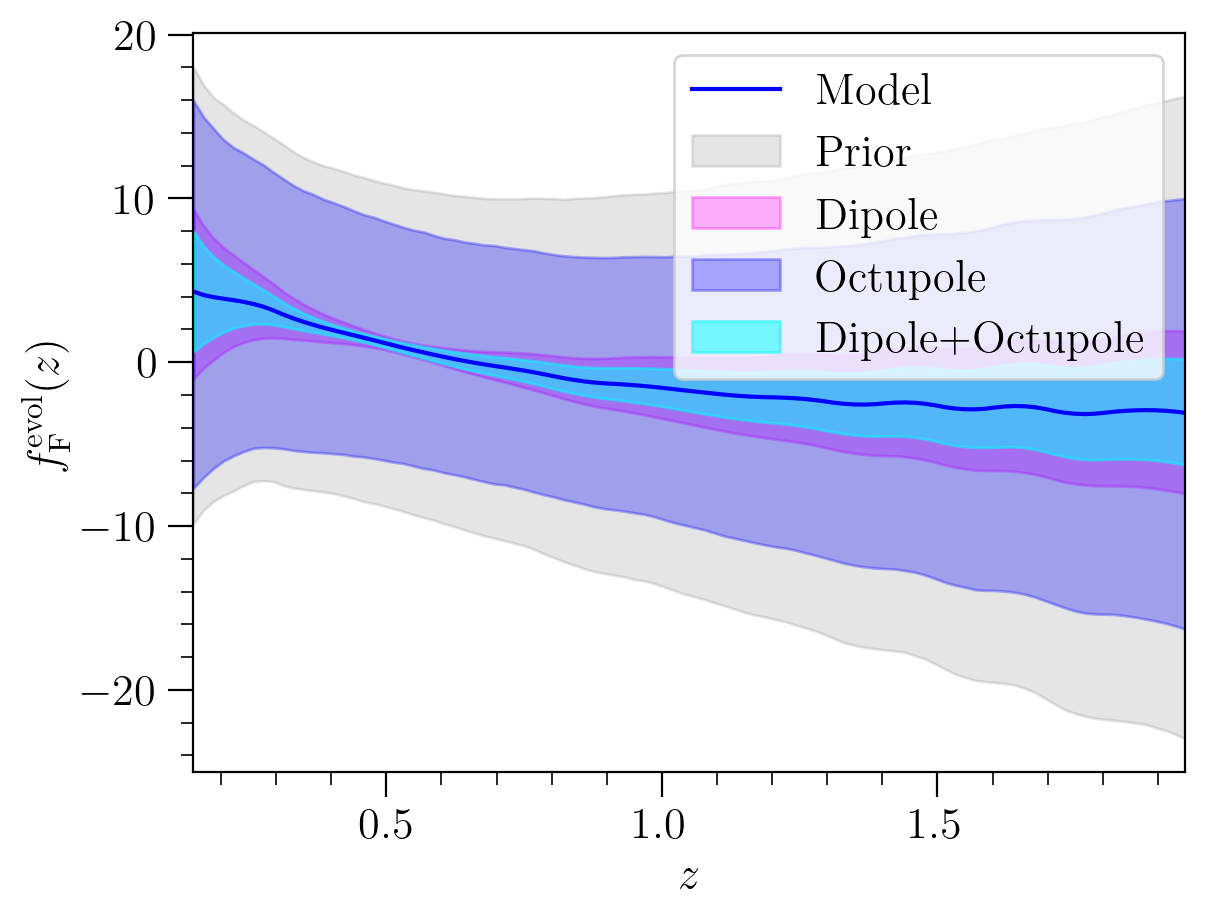

In [133]:
plt.plot(z_lin, fevol_F_fid, '-', color='blue', lw = 1.5, label='Model')

# Shade the 68% confidence interval

plt.fill_between(z_lin, fevol_F_lower_bound_priors, fevol_F_upper_bound_priors, color='black', alpha=0.1, label='Prior')
plt.fill_between(z_lin, fevol_F_lower_bound_noct, fevol_F_upper_bound_noct, color='magenta', alpha=0.3, label='Dipole')
plt.fill_between(z_lin, fevol_F_lower_bound_ndip, fevol_F_upper_bound_ndip, color='blue', alpha=0.3, label='Octupole')
plt.fill_between(z_lin, fevol_F_lower_bound_all, fevol_F_upper_bound_all, color='cyan', alpha=0.5, label='Dipole+Octupole')

plt.xlim(0.15,1.95)

plt.xlabel(r'$z$');
plt.ylabel(r'$f^\mathrm{evol}_\mathrm{F}(z)$');
#plt.title('With and without octupole');
plt.legend(loc='upper right')

#plt.savefig("plots/fevolF_prediction_50x50_full_vs_ndip_vs_prior50.pdf", bbox_inches='tight', format='pdf')